# Mount Drive:

In [1]:
#Import drive
from google.colab import drive
#Mount Google Drive%
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('drive/My Drive/Work/Thesis_Julien_Dejasmin/Work/code/Binary_activations_V2/MNIST_Binary_V2')
!ls

config.py   distributions  README.md	     trained_models
data	    experiments    requirements.txt  utils
DataLoader  __pycache__    results	     visualize


# Import:

In [0]:
!pip install pytorch-ignite

     |████████████████████████████████| 112kB 2.7MB/s 


In [0]:
try:
  from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
  from ignite.metrics import Accuracy, Loss, ConfusionMatrix
  from ignite.handlers import ModelCheckpoint
  from utils.training import run, evaluate
except ImportError:
  raise RuntimeError("no module Ignite, to install Ignite: 'pip install pytorch-ignite'.")

from tqdm import tqdm

In [0]:
import torch
from torch import nn
from torch.optim import SGD
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np
from functools import partial

from utils.models import get_my_model_Omniglot, fetch_last_checkpoint_model_filename
from DataLoader.dataLoaders import get_omniglot_dataloaders_classification
from utils.functions import Hardsigmoid

# Dataset:

In [4]:
batch_size_train = 1000
batch_size_test = 64
# Dataset
train_loader, valid_loader, test_loader = get_omniglot_dataloaders_classification(batch_size_train, batch_size_test)

Files already downloaded and verified
Number of training examples: 16
Number of testing examples: 31


# Training:

## Training parameters:

In [0]:
# parameters default values
epochs = 50
lr = 1e-3
momentum = 0.9
log_interval = 10  # how many batches to wait before logging training status
criterion =  F.nll_loss

## Run No binary Network:

In [0]:
# parameters model to load no Binary model
binary = False

model, name_model = get_my_model_Omniglot(binary)
print(name_model)

Omniglot_classif_NonBinaryNet


In [0]:
path_model_checkpoint = 'trained_models/Omniglot_classif/No_binary_models/'
path_save_plot = 'results/Omniglot_results/plot_acc_loss/Omniglot_classif/'

run(model, path_model_checkpoint, path_save_plot, name_model, train_loader, valid_loader, epochs, lr, momentum, criterion, log_interval)

### Test no binary network:

In [0]:
# load model pre trained
path_model = 'trained_models/Omniglot_classif/No_binary_models/'
if torch.cuda.is_available():
  model.load_state_dict(torch.load(fetch_last_checkpoint_model_filename(path_model)))
else:
  model.load_state_dict(torch.load(fetch_last_checkpoint_model_filename(path_model), map_location=torch.device('cpu')))
print("Model Loaded", name_model)

Model Loaded Omniglot_classif_NonBinaryNet


In [0]:
evaluate(model_no_binary, test_loader)

Test Results - Avg accuracy: 94.97 Avg loss: 0.22


In [0]:
evaluate(model_no_binary, valid_loader)

Test Results - Avg accuracy: 92.74 Avg loss: 0.30


In [0]:
evaluate(model_no_binary, train_loader)

Test Results - Avg accuracy: 93.30 Avg loss: 0.27


## Run Binary Network:

In [0]:
# parameters model to load no Binary model
binary = True
model, name_model = get_my_model_Omniglot(binary)
print(name_model)

In [0]:
path_model_checkpoint = 'trained_models/Omniglot_classif/Binary_models/'
path_save_plot = 'results/Omniglot_results/plot_acc_loss/Omniglot_classif/'

run(model, path_model_checkpoint, path_save_plot, name_model, train_loader, valid_loader, epochs, lr, momentum, criterion, log_interval)

### Test binary network:

In [0]:
# load model pre trained
path_model = 'trained_models/Omniglot_classif/Binary_models/'
if torch.cuda.is_available():
  model.load_state_dict(torch.load(fetch_last_checkpoint_model_filename(path_model)))
else:
  model.load_state_dict(torch.load(fetch_last_checkpoint_model_filename(path_model), map_location=torch.device('cpu')))
print("Model Loaded", name_model)

In [0]:
evaluate(model_binary, test_loader)

Test Results - Avg accuracy: 93.05 Avg loss: 0.27


In [0]:
evaluate(model_binary, valid_loader)

Test Results - Avg accuracy: 93.26 Avg loss: 0.29


In [0]:
evaluate(model_binary, train_loader)

Test Results - Avg accuracy: 93.38 Avg loss: 0.28


# Visualization:

In [0]:
from visualize.viz import visTensor, get_activation, viz_activations, viz_filters
from visualize.viz import viz_heatmap, test_predict_few_examples, standardize_and_clip, format_for_plotting
from visualize.viz import apply_transforms, GradientAscent, get_filter_layer2
from visualize.viz import get_region_layer1, get_region_layer2, get_regions_interest, get_all_regions_max

# for regions extraction
import collections
from functools import partial
import cv2

## Load models:

In [6]:
# parameters model to load no Binary model
binary = False
model_no_binary, name_model_no_binary = get_my_model_Omniglot(binary)

path_model = 'trained_models/Omniglot_classif/No_binary_models/'
if torch.cuda.is_available():
  model_no_binary.load_state_dict(torch.load(fetch_last_checkpoint_model_filename(path_model)))
else:
  model_no_binary.load_state_dict(torch.load(fetch_last_checkpoint_model_filename(path_model), map_location=torch.device('cpu')))
print("Model Loaded", name_model_no_binary)

Model Loaded Omniglot_classif_NonBinaryNet


In [7]:
# parameters model to load no Binary model
binary = True
model_binary, name_model_binary = get_my_model_Omniglot(binary)

path_model = 'trained_models/Omniglot_classif/Binary_models/'
if torch.cuda.is_available():
  model_binary.load_state_dict(torch.load(fetch_last_checkpoint_model_filename(path_model)))
else:
  model_binary.load_state_dict(torch.load(fetch_last_checkpoint_model_filename(path_model), map_location=torch.device('cpu')))
print("Model Loaded", name_model_binary)

Model Loaded Omniglot_classif_Stochastic_ST_first_conv_binary


In [0]:
print(model_no_binary)

NoBinaryNetOmniglotClassification(
  (layer1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batchNorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act_layer1): ReLU()
  (layer2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batchNorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act_layer2): ReLU()
  (layer3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batchNorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act_layer3): ReLU()
  (layer4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batchNorm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act_layer4): ReLU()
  (layer5): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batchNorm5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [0]:
print(model_binary)

BinaryNetOmniglotClassification(
  (layer1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batchNorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act_layer1): StochasticBinaryActivation(
    (act): Hardsigmoid(
      (act): Hardtanh(min_val=-1.0, max_val=1.0)
    )
  )
  (layer2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batchNorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act_layer2): ReLU()
  (layer3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batchNorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act_layer3): ReLU()
  (layer4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batchNorm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act_layer4): ReLU()
  (layer5): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padd

## Visualization few predictions:

No binary model


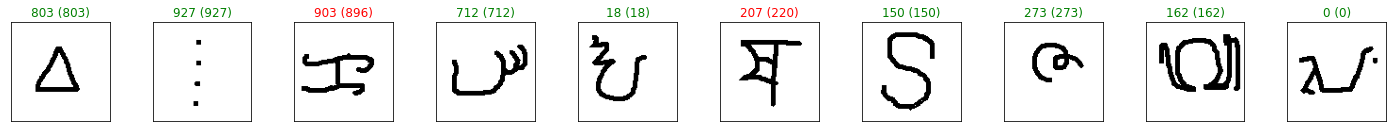

Binary model


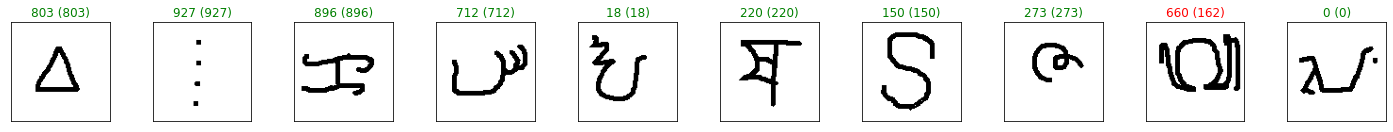

In [0]:
print('No binary model')
test_predict_few_examples(model_no_binary, test_loader)
plt.show()
print('Binary model')
test_predict_few_examples(model_binary, test_loader)
plt.show()

## Visualization Activations values for a specific data:

act_layer1 for label 564


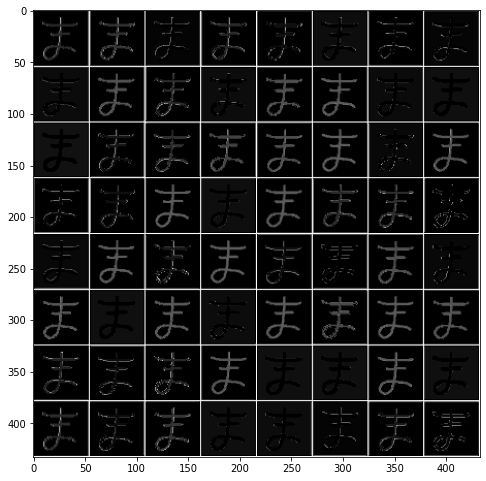

act_layer2 for label 564


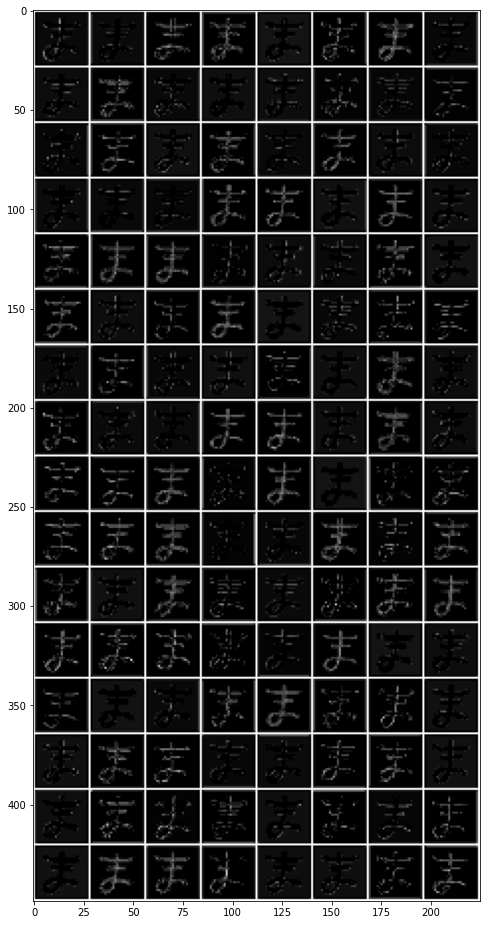

act_layer3 for label 564


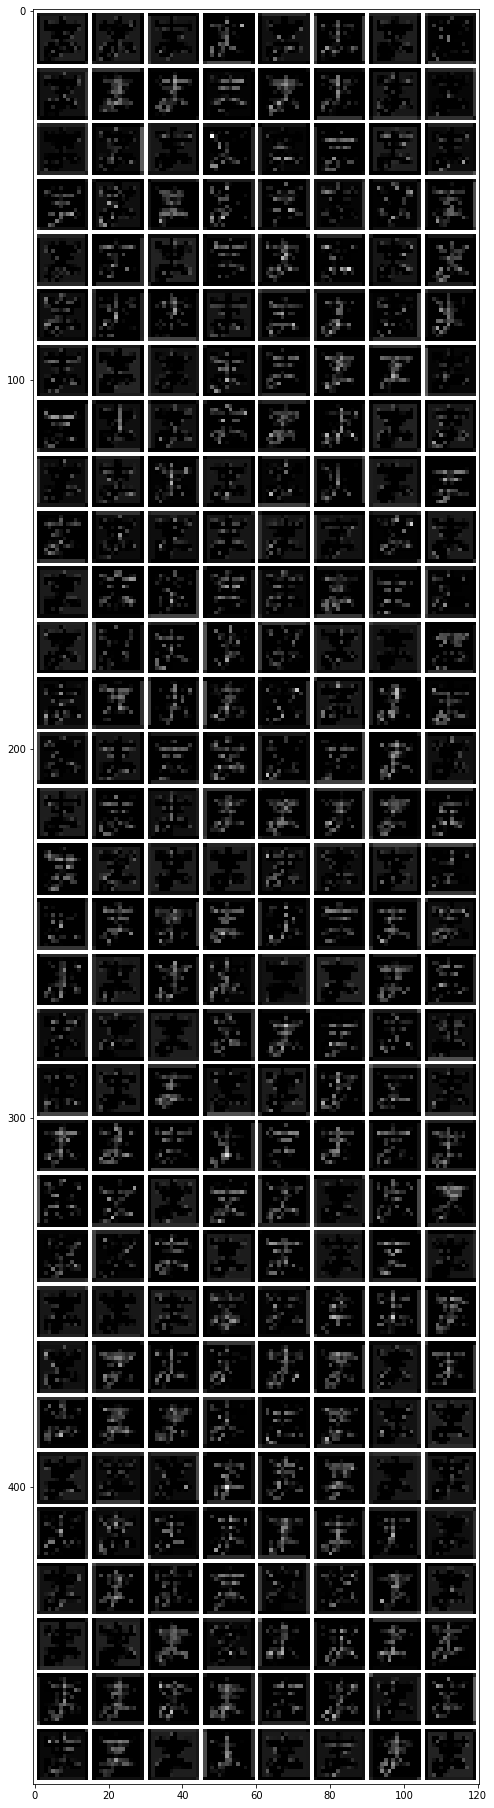

act_layer4 for label 564


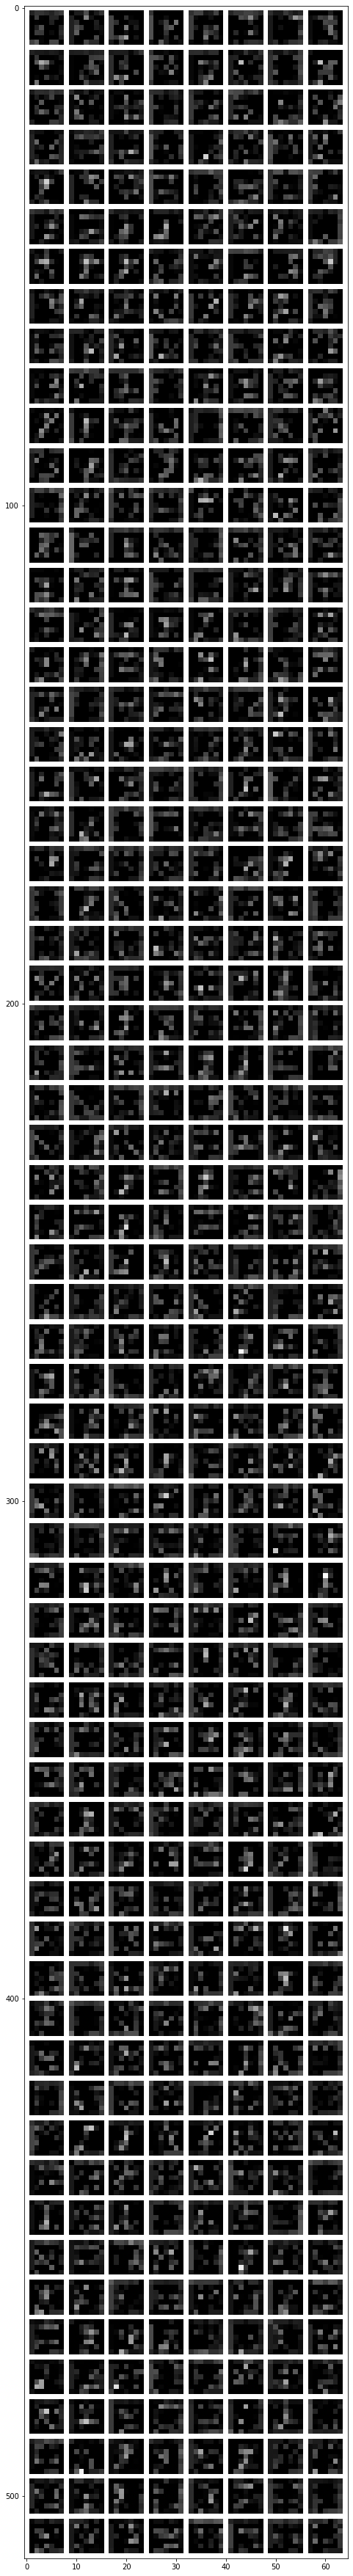

act_layer5 for label 564


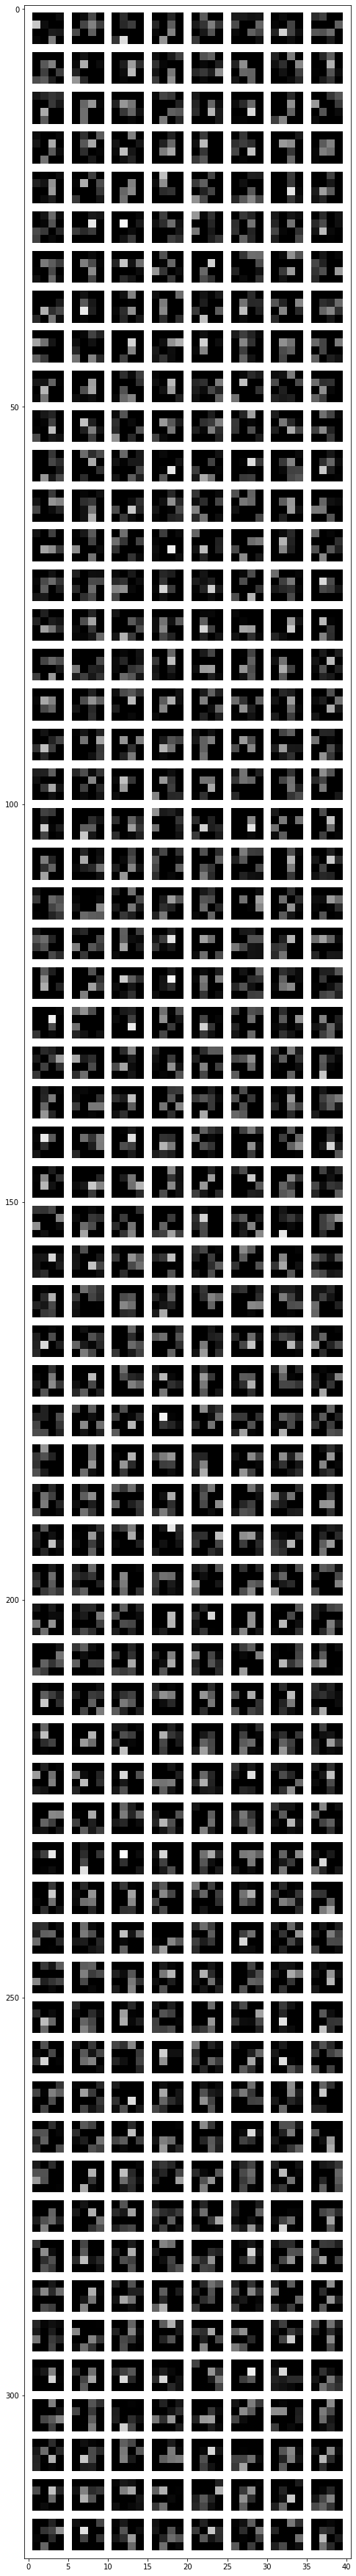

act_fc1 for label 564


IndexError: ignored

In [0]:
index_data = 10
viz_activations(model_no_binary, test_loader, index_data)

act_layer1.act for label 564


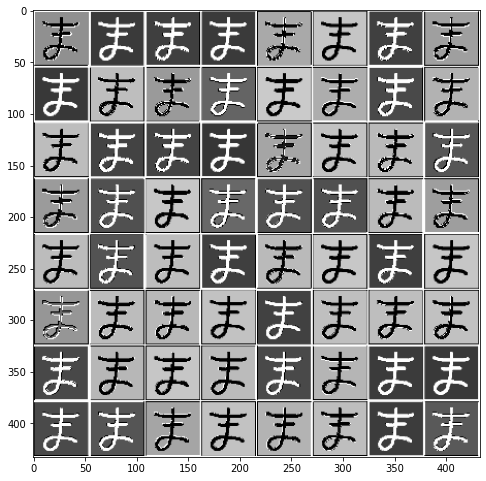

act_layer2 for label 564


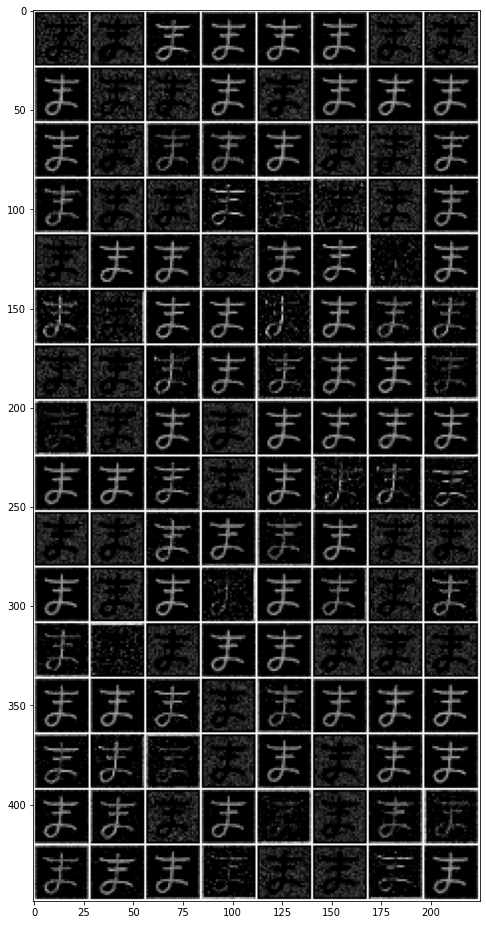

act_layer3 for label 564


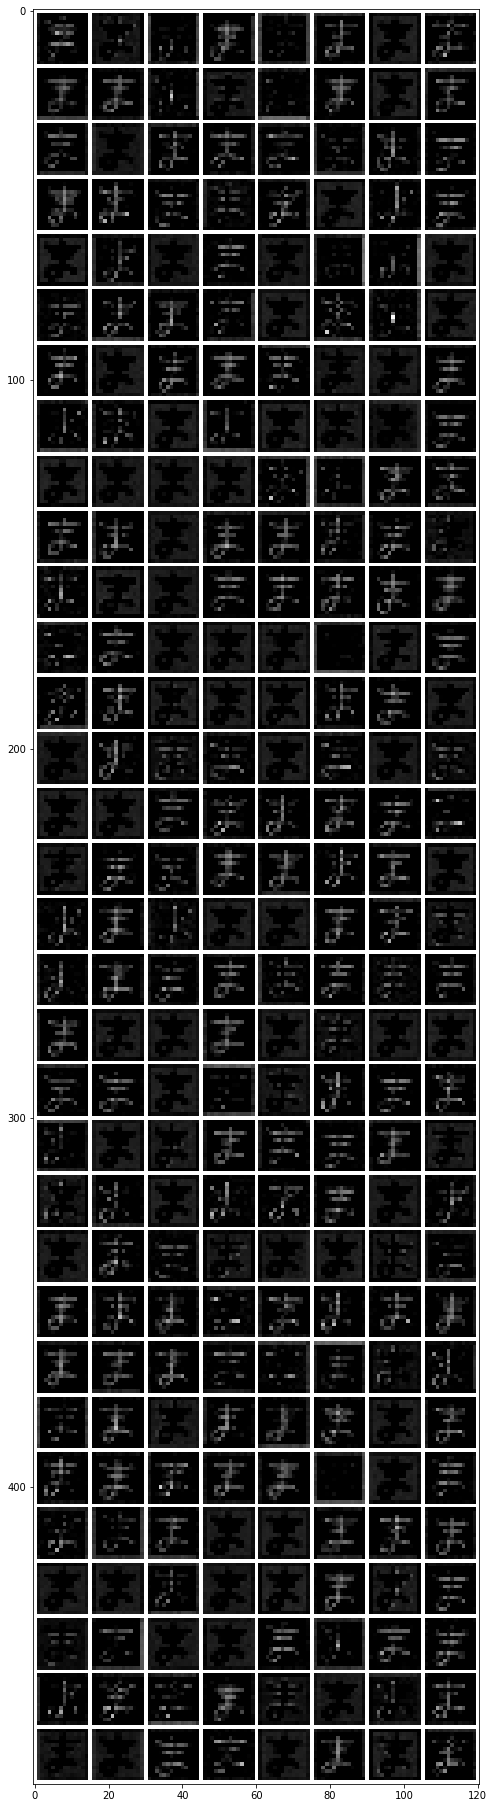

act_layer4 for label 564


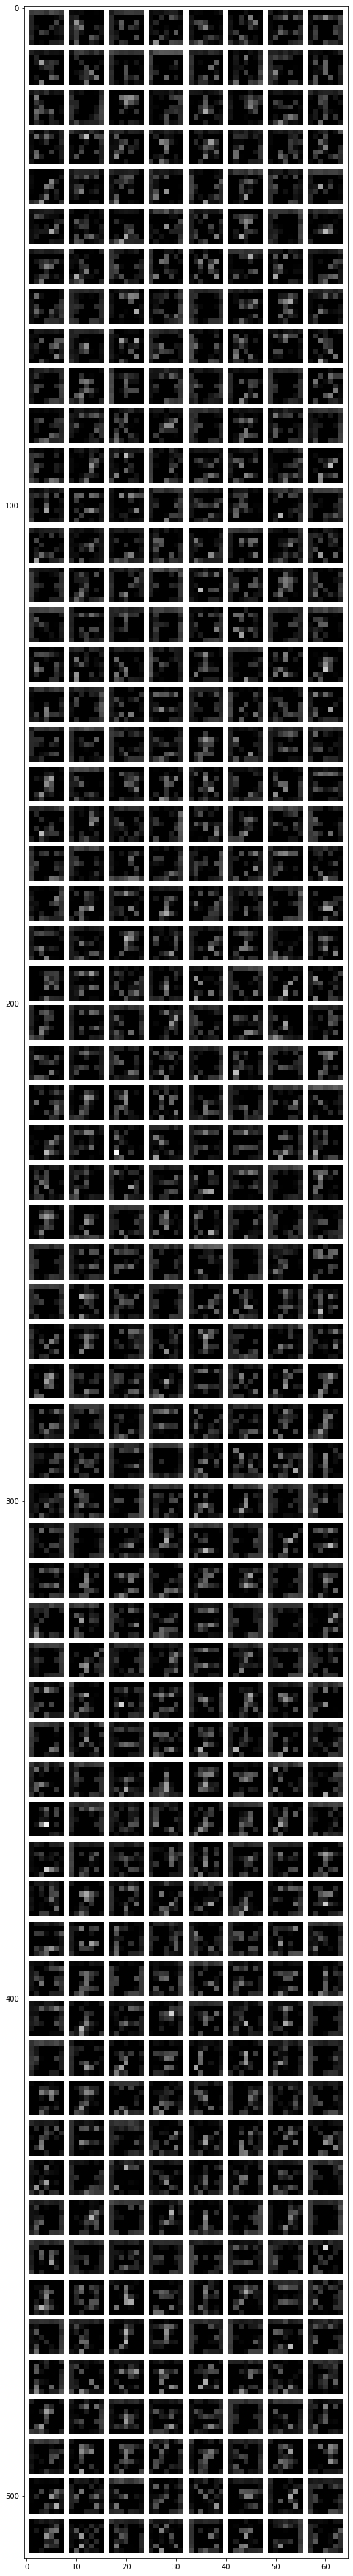

act_layer5 for label 564


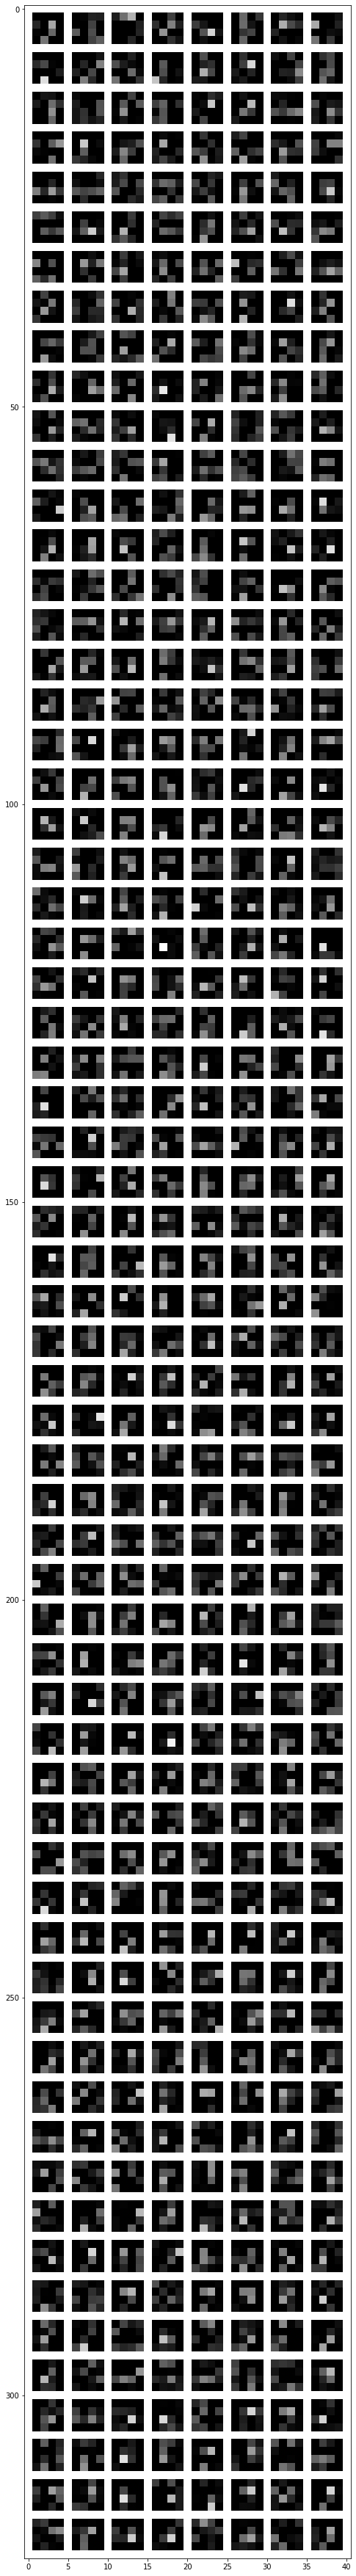

act_fc1 for label 564


IndexError: ignored

In [0]:
index_data = 10
viz_activations(model_binary, test_loader, index_data)

## Visualization heatmap for a specific data:

layer:act_layer1 :heatrmap for an image of label 564 with model Omniglot_classif_NonBinaryNet


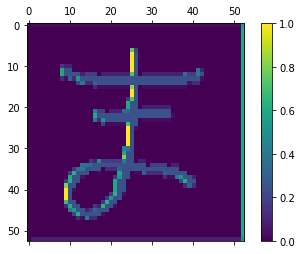

layer:act_layer2 :heatrmap for an image of label 564 with model Omniglot_classif_NonBinaryNet


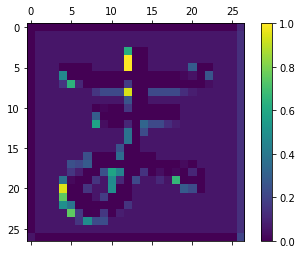

layer:act_layer3 :heatrmap for an image of label 564 with model Omniglot_classif_NonBinaryNet


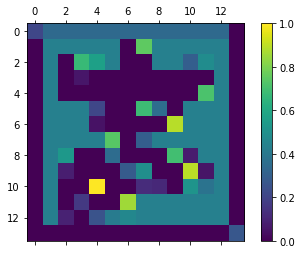

layer:act_layer4 :heatrmap for an image of label 564 with model Omniglot_classif_NonBinaryNet


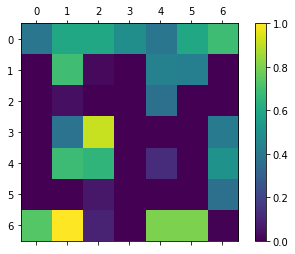

layer:act_layer5 :heatrmap for an image of label 564 with model Omniglot_classif_NonBinaryNet


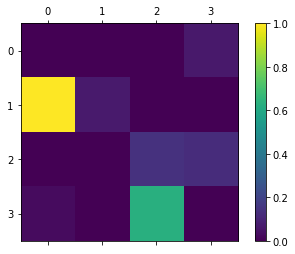

layer:act_fc1 :heatrmap for an image of label 564 with model Omniglot_classif_NonBinaryNet


TypeError: ignored

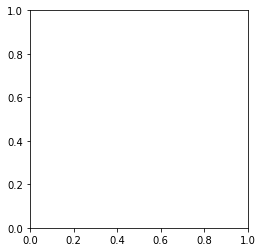

In [0]:
index_data = 10
viz_heatmap(model_no_binary, name_model_no_binary, test_loader, index_data)

layer:act_layer1.act :heatrmap for an image of label 564 with model Omniglot_classif_Stochastic_ST_first_conv_binary


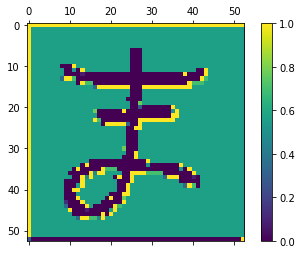

layer:act_layer2 :heatrmap for an image of label 564 with model Omniglot_classif_Stochastic_ST_first_conv_binary


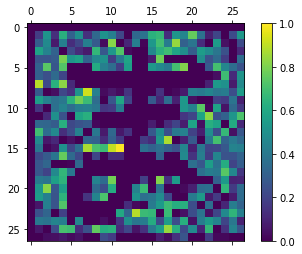

layer:act_layer3 :heatrmap for an image of label 564 with model Omniglot_classif_Stochastic_ST_first_conv_binary


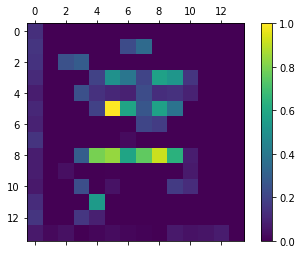

layer:act_layer4 :heatrmap for an image of label 564 with model Omniglot_classif_Stochastic_ST_first_conv_binary


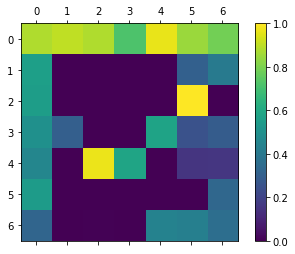

layer:act_layer5 :heatrmap for an image of label 564 with model Omniglot_classif_Stochastic_ST_first_conv_binary


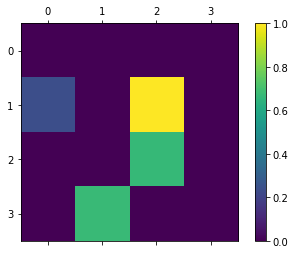

layer:act_fc1 :heatrmap for an image of label 564 with model Omniglot_classif_Stochastic_ST_first_conv_binary


TypeError: ignored

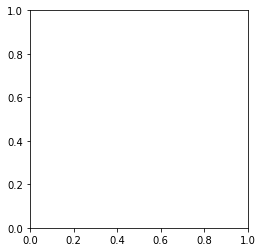

In [0]:
index_data = 10
viz_heatmap(model_binary, name_model_binary, test_loader, index_data)

## Visualization filters trained:

Visualization filters learned for layer: layer1


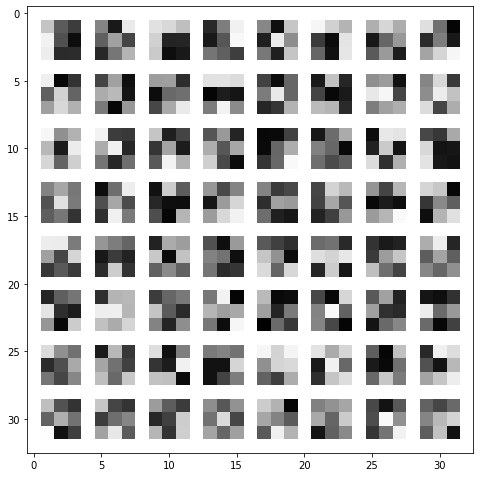

Visualization filters learned for layer: layer2


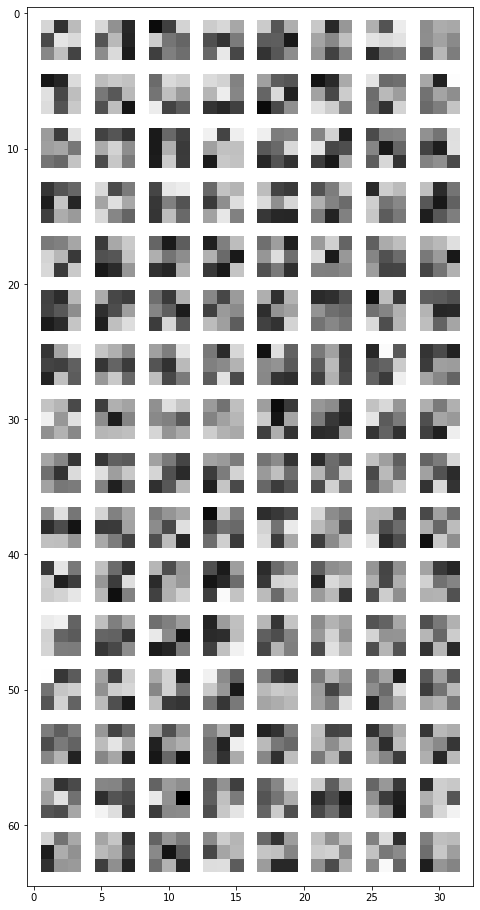

Visualization filters learned for layer: layer3


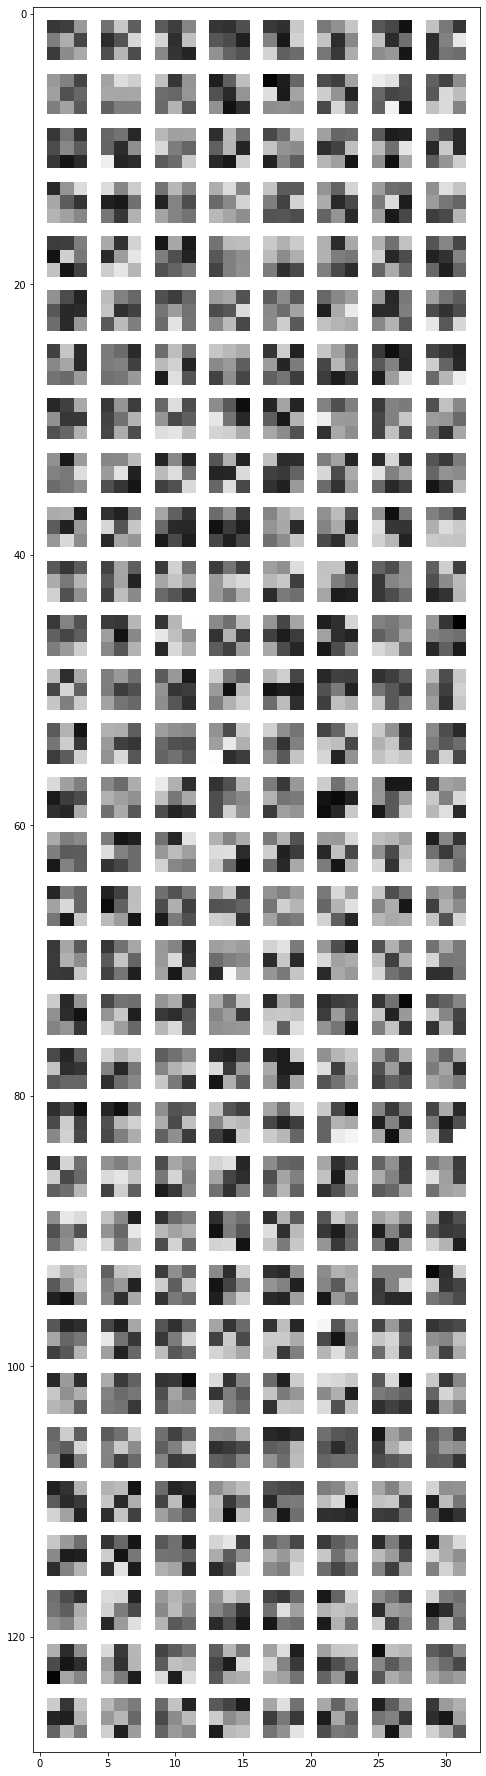

Visualization filters learned for layer: layer4


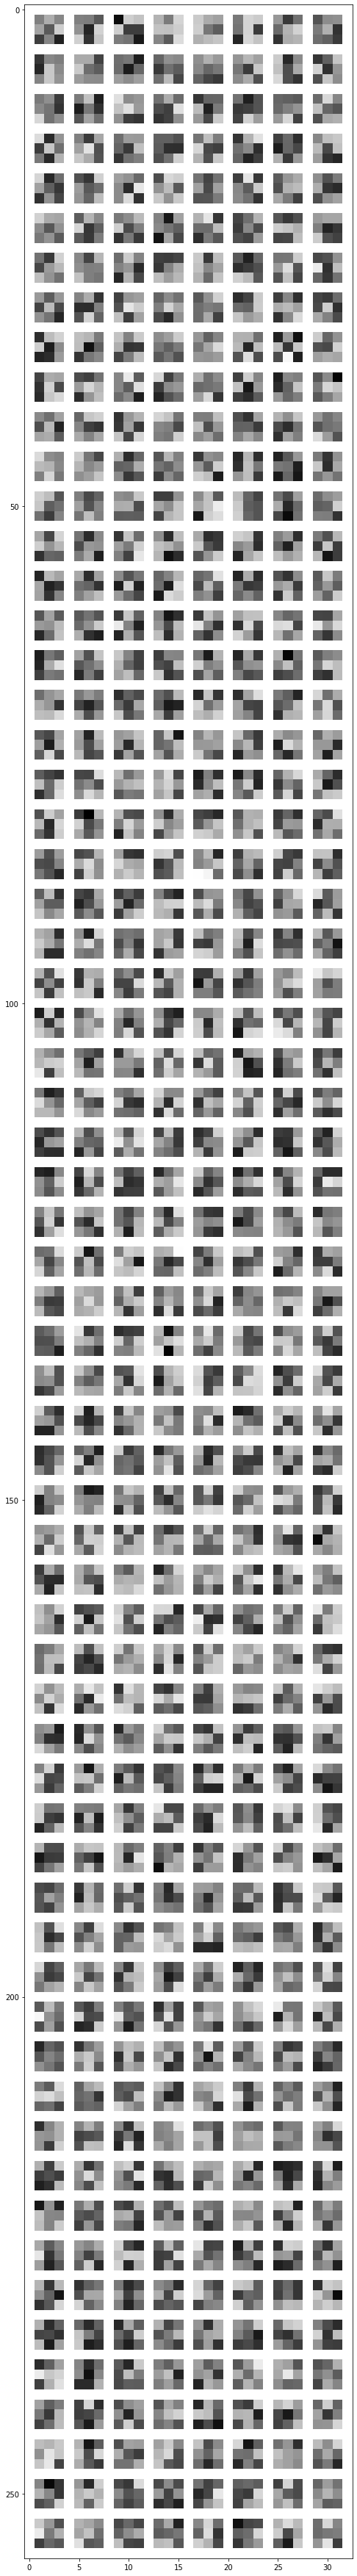

Visualization filters learned for layer: layer5


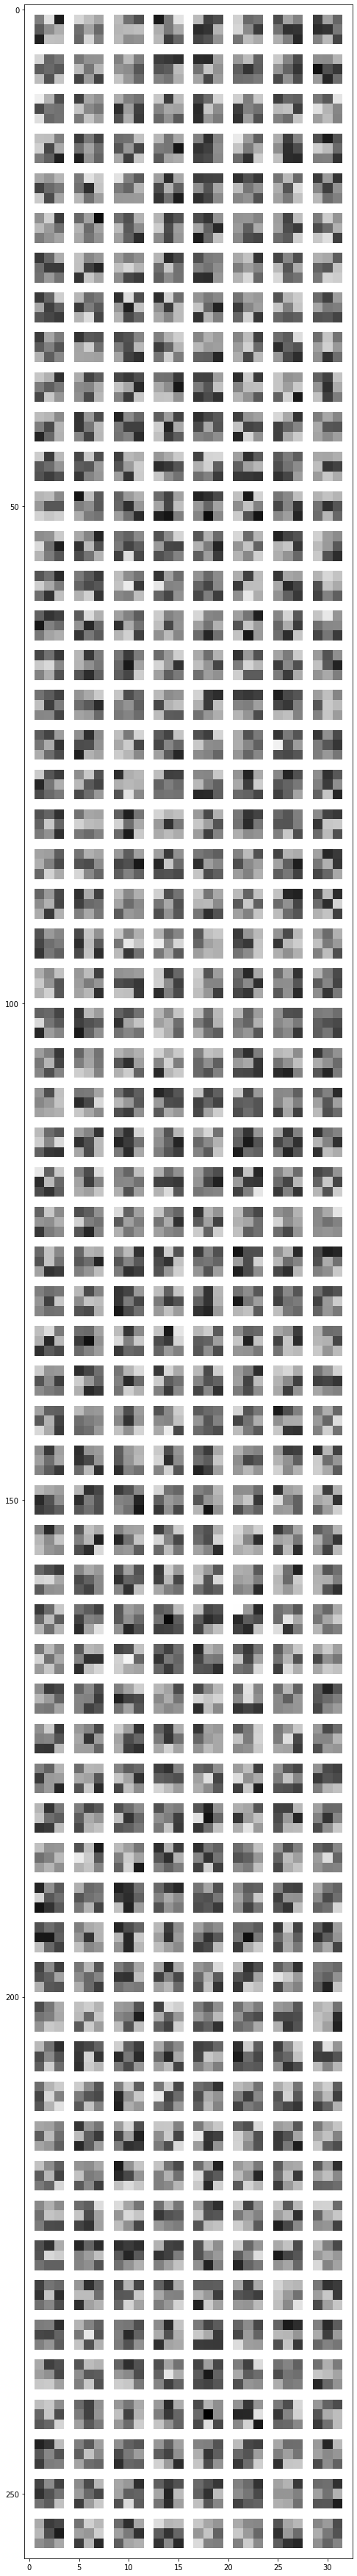

In [0]:
viz_filters(model_no_binary)

Visualization filters learned for layer: layer1


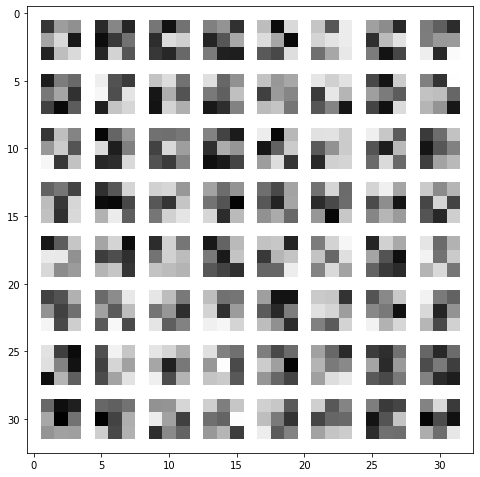

Visualization filters learned for layer: layer2


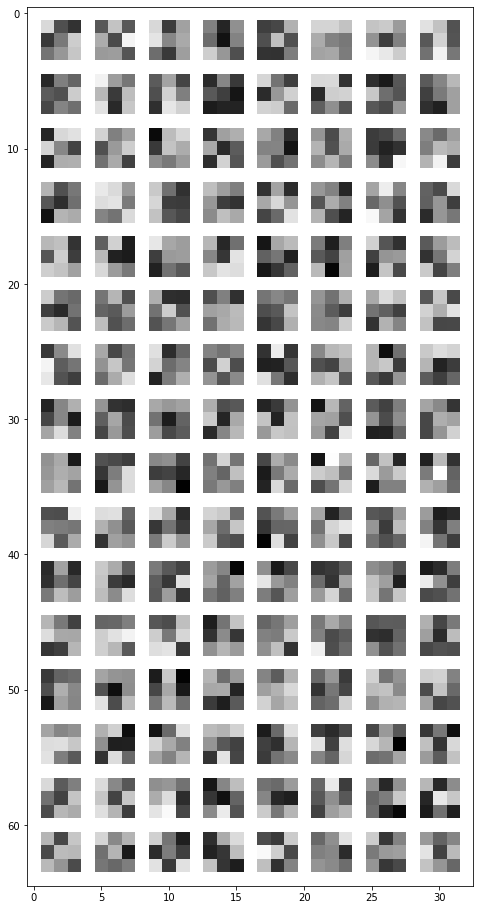

Visualization filters learned for layer: layer3


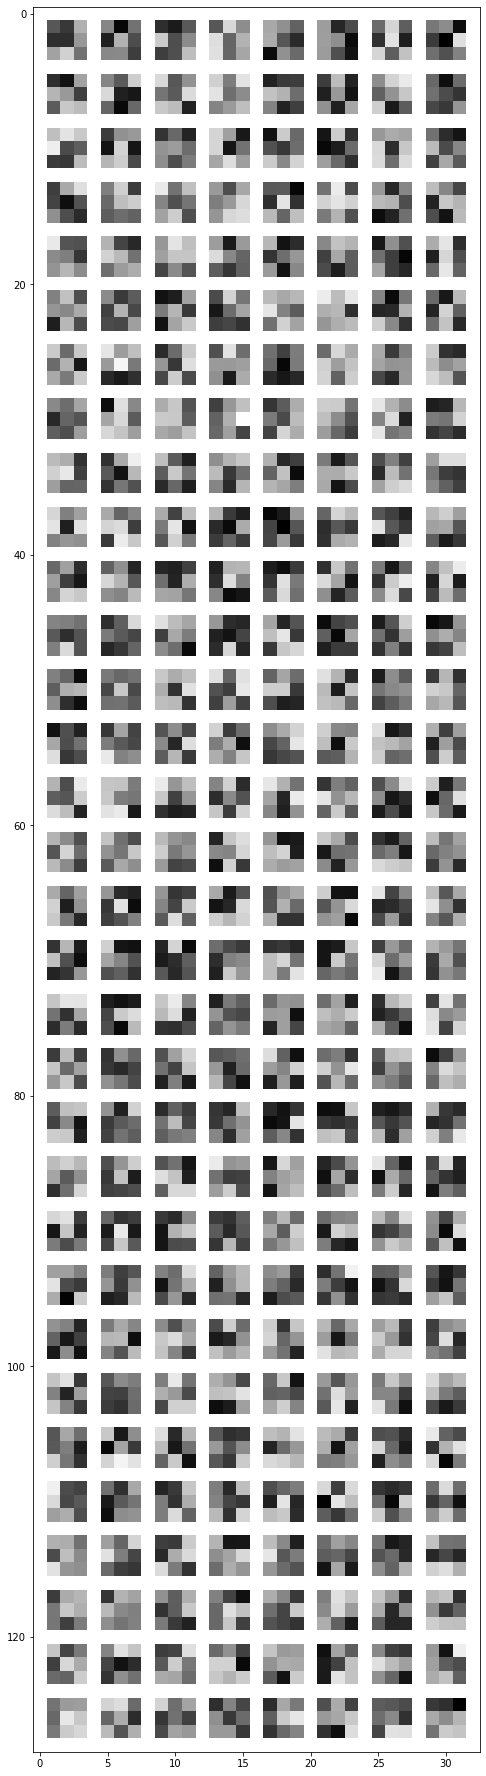

Visualization filters learned for layer: layer4


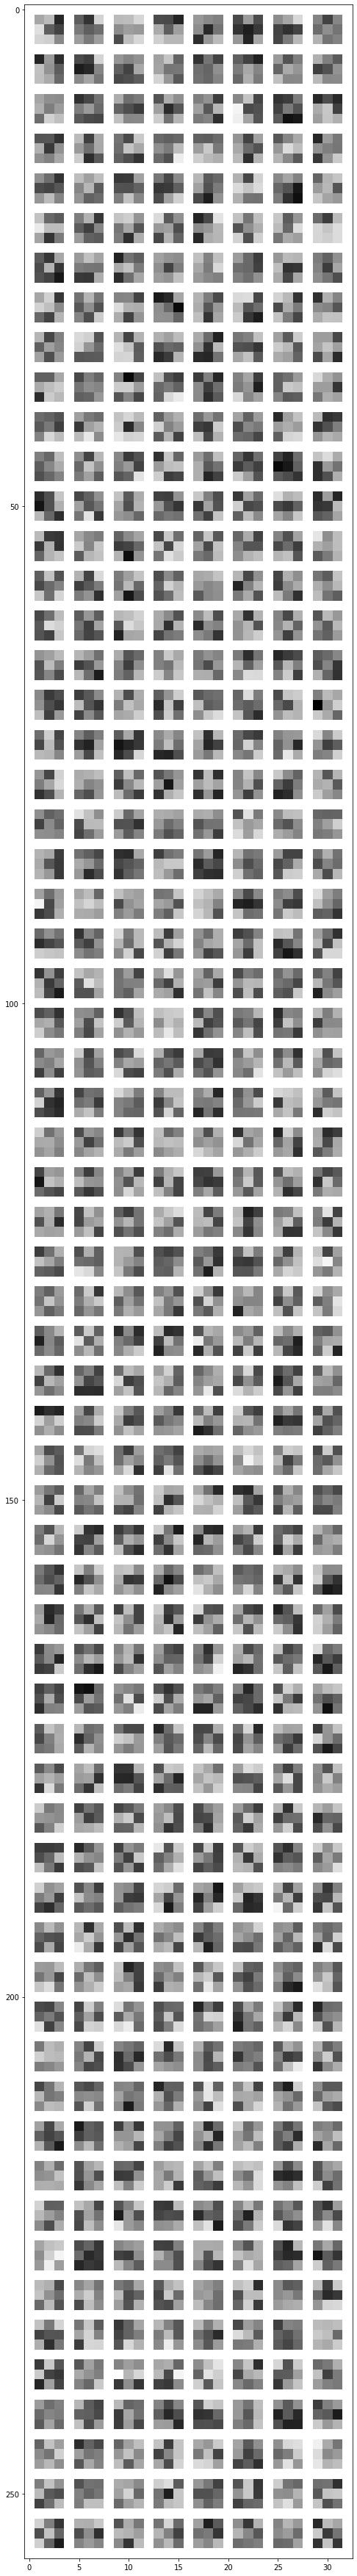

Visualization filters learned for layer: layer5


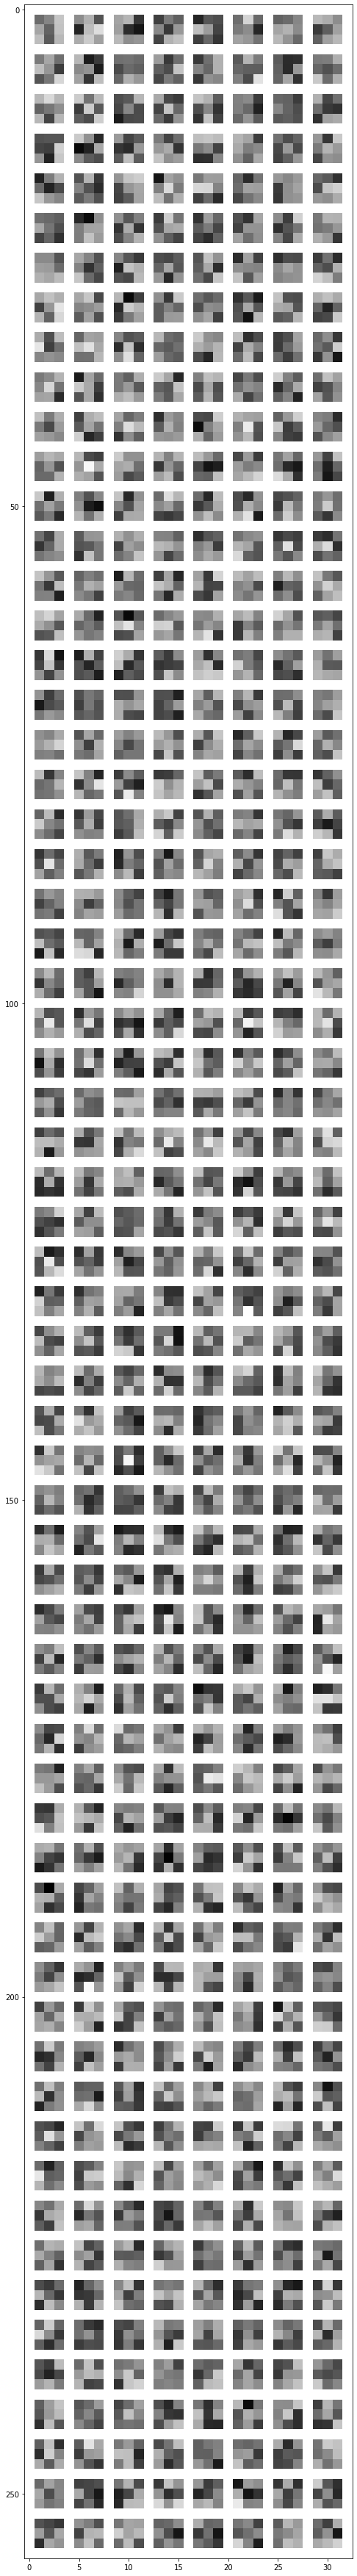

In [0]:
viz_filters(model_binary)

## Visualization image that maximizes a specific activation in a specific layer for a specifc filter:

### No binary model:

In [0]:
g_ascent_no_binary = GradientAscent(model_no_binary, nb_channels=1, img_size=105, zoom=True, filter_size=3)
g_ascent_no_binary.use_gpu = True

In [0]:
conv1_no_binary = model_no_binary.layer1
# conv1_filters_no_binary = [0,5,10,15,20,25,30,35,40,45,50,55,60,63]  
conv1_filters_no_binary = np.arange(64)
mean_gradient_layer1 = False
ind_x_layer1 = 25
ind_y_layer1 = 25

conv2_no_binary = model_no_binary.layer2
conv2_filters_no_binary =  [0,5,10,15,20,25,30,35,40,45,50,55,60,63]
mean_gradient_layer2 = False
ind_x_layer2 = 12
ind_y_layer2 = 12

conv3_no_binary = model_no_binary.layer3
conv3_filters_no_binary =  [0,5,10,15,20,25,30,35,40,45,50,55,60,63]
mean_gradient_layer3 = False
ind_x_layer3 = 6
ind_y_layer3 = 6

conv4_no_binary = model_no_binary.layer4
conv4_filters_no_binary =  [0,5,10,15,20,25,30,35,40,45,50,55,60,63]
mean_gradient_layer4 = False
ind_x_layer4 = 3
ind_y_layer4 = 3

lr= 0.0001
num_iter=1000
MNIST = False

/content/drive/My Drive/Work/Thesis_Julien_Dejasmin/Work/code/Binary_activations_V2/MNIST_Binary_V2/visualize/viz.py:325: UserWarning: Attempting to set identical left == right == 50 results in singular transformations; automatically expanding.
  ax.axis([xmin, xmax, ymin, ymax])
/content/drive/My Drive/Work/Thesis_Julien_Dejasmin/Work/code/Binary_activations_V2/MNIST_Binary_V2/visualize/viz.py:325: UserWarning: Attempting to set identical bottom == top == 50 results in singular transformations; automatically expanding.
  ax.axis([xmin, xmax, ymin, ymax])


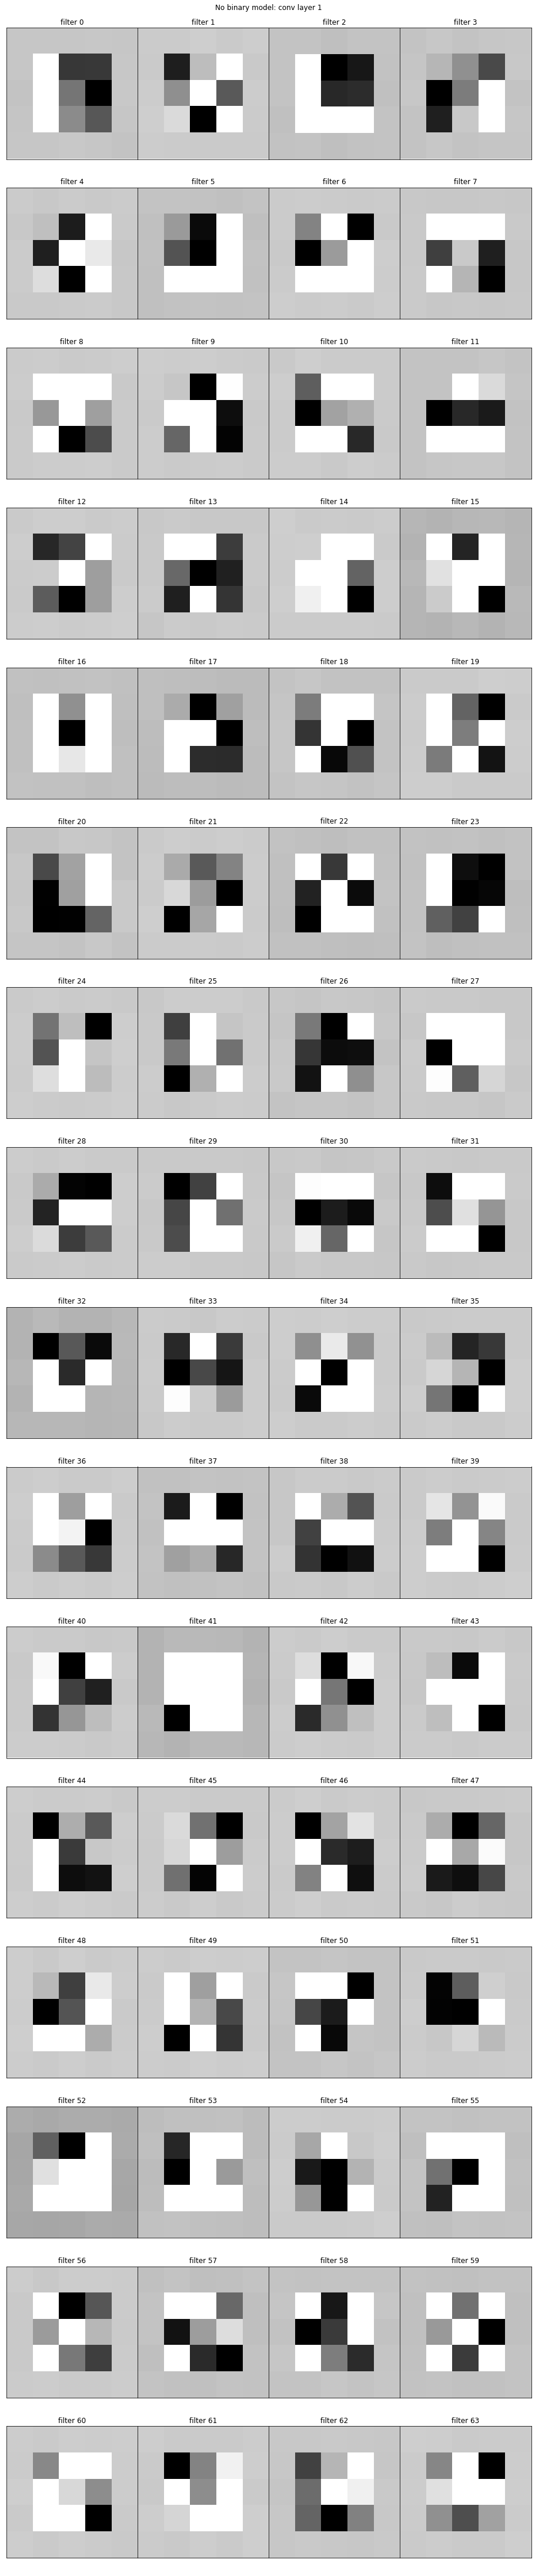

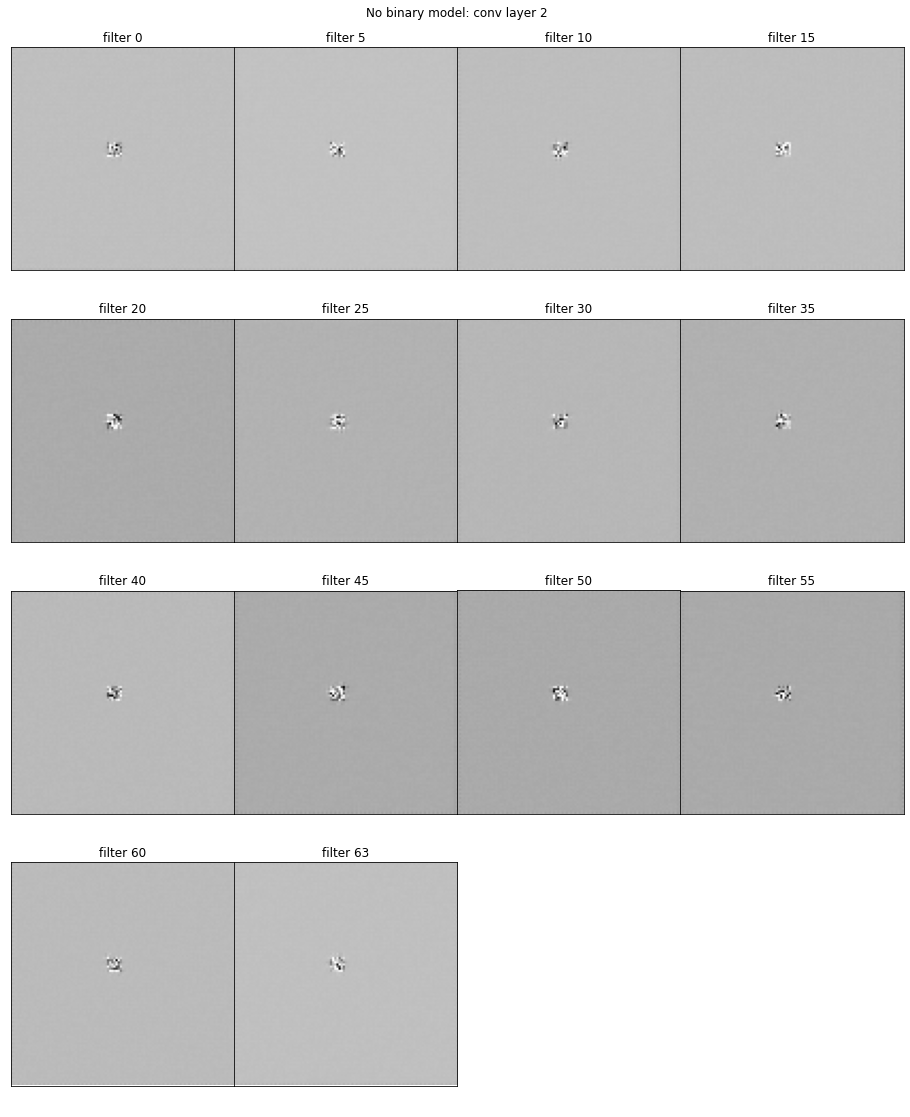

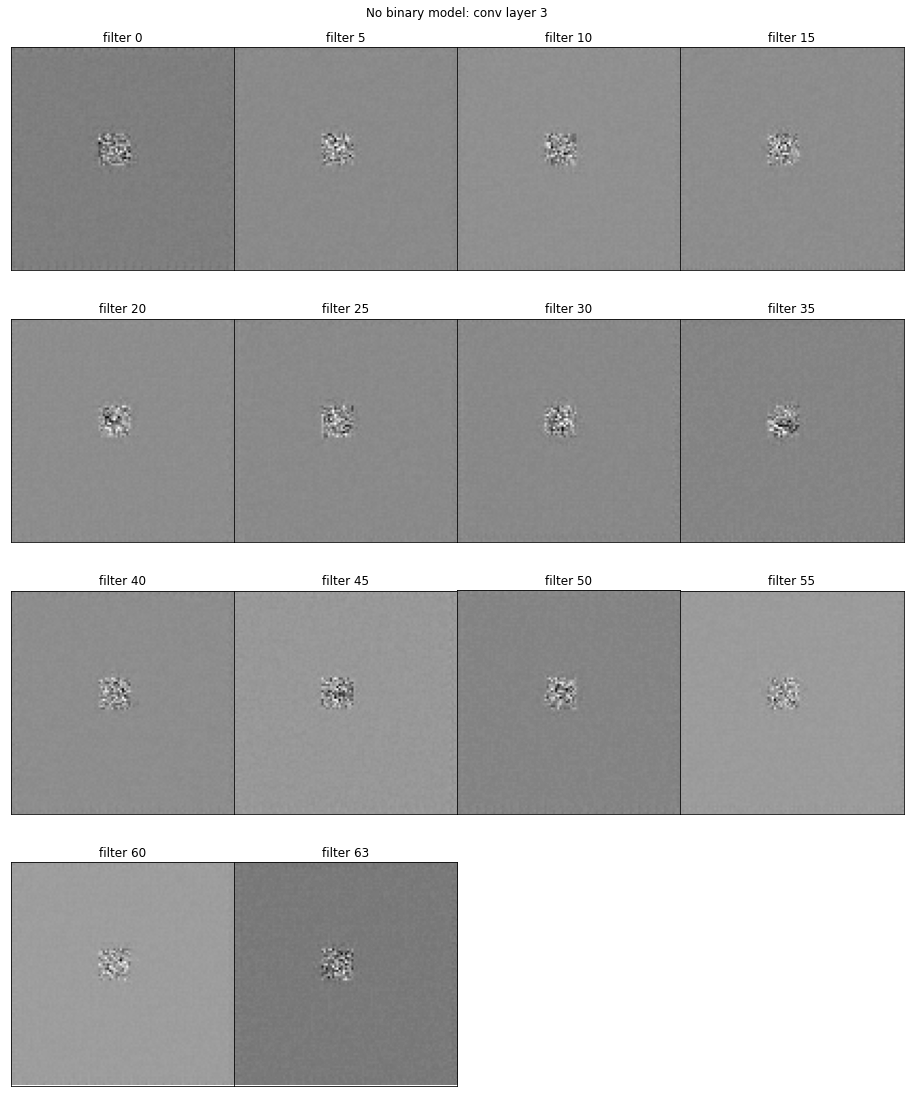

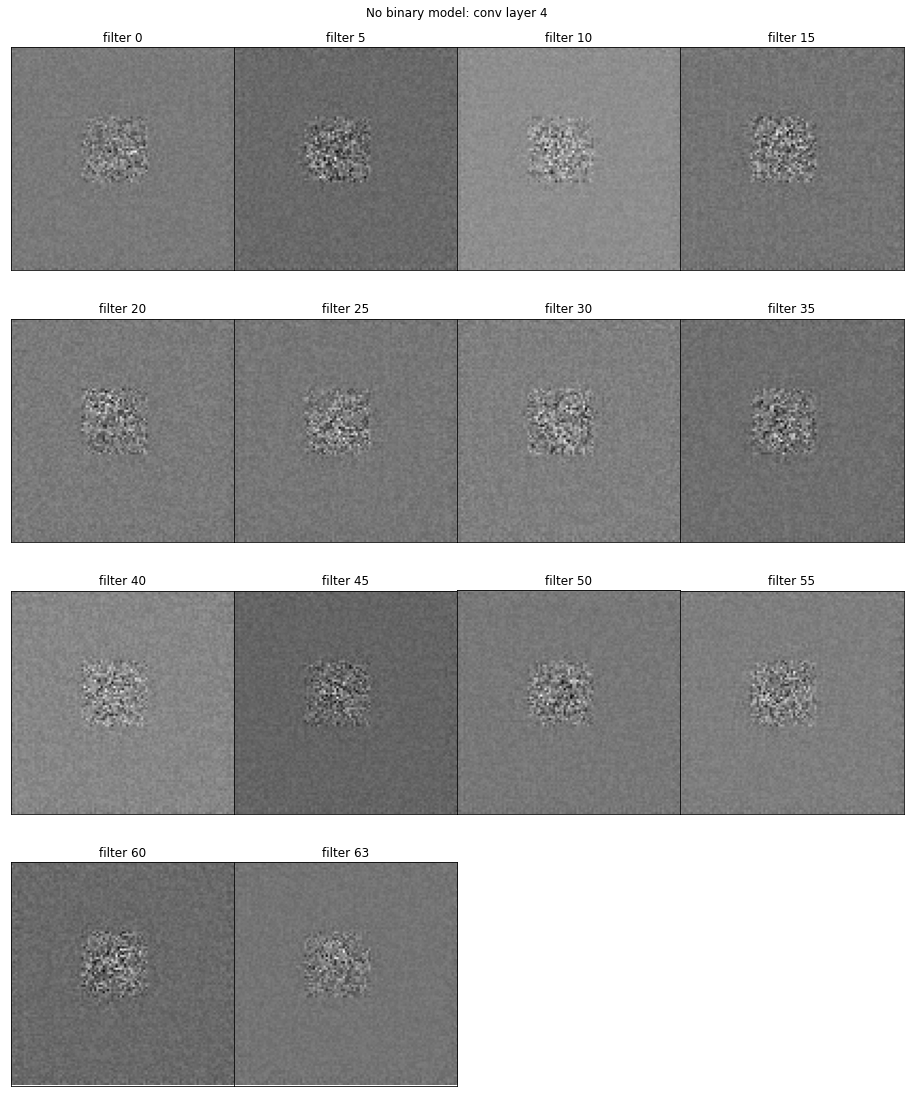

In [0]:
g_ascent_no_binary.visualize(conv1_no_binary, MNIST, conv1_filters_no_binary, mean_gradient_layer1,
                             ind_x_layer1, ind_y_layer1, lr=lr, num_iter=num_iter, title='No binary model: conv layer 1', first_conv_layer=True)
g_ascent_no_binary.visualize(conv2_no_binary, MNIST, conv2_filters_no_binary, mean_gradient_layer2,
                             ind_x_layer2, ind_y_layer2, lr=lr, num_iter=num_iter, title='No binary model: conv layer 2')
g_ascent_no_binary.visualize(conv3_no_binary, MNIST, conv3_filters_no_binary, mean_gradient_layer3,
                             ind_x_layer3, ind_y_layer3, lr=lr, num_iter=num_iter, title='No binary model: conv layer 3')
g_ascent_no_binary.visualize(conv4_no_binary, MNIST, conv4_filters_no_binary, mean_gradient_layer4,
                             ind_x_layer4, ind_y_layer4, lr=lr, num_iter=num_iter, title='No binary model: conv layer 4')

In [0]:
g_ascent_no_binary = GradientAscent(model_no_binary, nb_channels=1, img_size=105, zoom=True, filter_size=3)
g_ascent_no_binary.use_gpu = True

conv1_no_binary = model_no_binary.layer1
# conv1_filters_no_binary = [0,5,10,15,20,25,30,35,40,45,50,55,60,63]  
conv1_filters_no_binary = np.arange(64)
mean_gradient_layer1 = True
ind_x_layer1 = 25
ind_y_layer1 = 25

conv2_no_binary = model_no_binary.layer2
conv2_filters_no_binary =  [0,5,10,15,20,25,30,35,40,45,50,55,60,63]
mean_gradient_layer2 = True
ind_x_layer2 = 12
ind_y_layer2 = 12

conv3_no_binary = model_no_binary.layer3
conv3_filters_no_binary =  [0,5,10,15,20,25,30,35,40,45,50,55,60,63]
mean_gradient_layer3 = True
ind_x_layer3 = 6
ind_y_layer3 = 6

conv4_no_binary = model_no_binary.layer4
conv4_filters_no_binary =  [0,5,10,15,20,25,30,35,40,45,50,55,60,63]
mean_gradient_layer4 = True
ind_x_layer4 = 3
ind_y_layer4 = 3

lr= 0.0001
num_iter=1000
MNIST = False

In [0]:
g_ascent_no_binary.visualize(conv1_no_binary, MNIST, conv1_filters_no_binary, mean_gradient_layer1,
                             ind_x_layer1, ind_y_layer1, lr=lr, num_iter=num_iter, title='No binary model: conv layer 1', first_conv_layer=True)
g_ascent_no_binary.visualize(conv2_no_binary, MNIST, conv2_filters_no_binary, mean_gradient_layer2,
                             ind_x_layer2, ind_y_layer2, lr=lr, num_iter=num_iter, title='No binary model: conv layer 2')
g_ascent_no_binary.visualize(conv3_no_binary, MNIST, conv3_filters_no_binary, mean_gradient_layer3,
                             ind_x_layer3, ind_y_layer3, lr=lr, num_iter=num_iter, title='No binary model: conv layer 3')
g_ascent_no_binary.visualize(conv4_no_binary, MNIST, conv4_filters_no_binary, mean_gradient_layer4,
                             ind_x_layer4, ind_y_layer4, lr=lr, num_iter=num_iter, title='No binary model: conv layer 4')

Output hidden; open in https://colab.research.google.com to view.

### Binary model:

In [0]:
g_ascent_binary = GradientAscent(model_binary, nb_channels=1, img_size=105, zoom=True, filter_size=3)
g_ascent_binary.use_gpu = True

In [0]:
conv1_binary = model_binary.layer1
# conv1_filters_binary = [0,5,10,15,20,25,30,35,40,45,50,55,60,63]
conv1_filters_binary = np.arange(64)
mean_gradient_layer1 = False
ind_x_layer1 = 25
ind_y_layer1 = 25

conv2_binary = model_binary.layer2
conv2_filters_binary =  [0,5,10,15,20,25,30,35,40,45,50,55,60,63]
mean_gradient_layer2 = False
ind_x_layer2 = 12
ind_y_layer2 = 12

conv3_binary = model_binary.layer3
conv3_filters_binary =  [0,5,10,15,20,25,30,35,40,45,50,55,60,63]
mean_gradient_layer3 = False
ind_x_layer3 = 6
ind_y_layer3 = 6

conv4_binary = model_binary.layer4
conv4_filters_binary =  [0,5,10,15,20,25,30,35,40,45,50,55,60,63]
mean_gradient_layer4 = False
ind_x_layer4 = 3
ind_y_layer4 = 3

lr=0.0001
num_iter=1000
MNIST = False

In [0]:
g_ascent_binary.visualize(conv1_binary, MNIST, conv1_filters_binary, mean_gradient_layer1,
                             ind_x_layer1, ind_y_layer1, lr=lr, num_iter=num_iter, title='Binary model: conv layer 1', first_conv_layer=True)
g_ascent_binary.visualize(conv2_binary, MNIST, conv2_filters_binary, mean_gradient_layer2,
                             ind_x_layer2, ind_y_layer2, lr=lr, num_iter=num_iter, title='Binary model: conv layer 2')
g_ascent_binary.visualize(conv3_binary, MNIST, conv3_filters_binary, mean_gradient_layer3,
                             ind_x_layer3, ind_y_layer3, lr=lr, num_iter=num_iter, title='Binary model: conv layer 3')
g_ascent_binary.visualize(conv4_binary, MNIST, conv4_filters_binary, mean_gradient_layer4,
                             ind_x_layer4, ind_y_layer4, lr=lr, num_iter=num_iter, title='Binary model: conv layer 4')

## Visuazation regions that maximizes a specific layer and filter:

### Run:

#### Extract and save regions and activations:

##### No binary model:

In [8]:
dataiter = iter(train_loader)
images, _ = dataiter.next()

print(images.shape)

torch.Size([1000, 1, 105, 105])


In [0]:
# a dictionary that keeps saving the activations as they come
activations_no_binary = collections.defaultdict(list)

def save_activation_no_binary(name, mod, inp, out):
    activations_no_binary[name].append(out.cpu())

In [10]:
for name, m in model_no_binary.named_modules():
    if type(m)==nn.Conv2d:
      # partial to assign the layer name to each hook
      m.register_forward_hook(partial(save_activation_no_binary, name))

out = model_no_binary(images)

activations_no_binary = {name: torch.cat(outputs, 0) for name, outputs in activations_no_binary.items()}

for k,v in activations_no_binary.items():
      print (k, v.size())

layer1 torch.Size([1000, 64, 53, 53])
layer2 torch.Size([1000, 128, 27, 27])
layer3 torch.Size([1000, 256, 14, 14])
layer4 torch.Size([1000, 512, 7, 7])
layer5 torch.Size([1000, 512, 4, 4])


In [11]:
stride = 2
padding = 1
filter_size = 3
len_img_w = 105
len_img_h = 105
loader = train_loader

region_final, activation_final, activation_final_normalized = get_all_regions_max(images, loader, activations_no_binary, stride, padding, filter_size, len_img_h, len_img_w)

Streaming output truncated to the last 5000 lines.
(2, 2)
(3, 2)
norm null for filter: 26, image: 759 with activation:-0.32322463393211365, index(6,31)
norm null for filter: 28, image: 759 with activation:0.05451379343867302, index(6,31)
(2, 2)
norm null for filter: 35, image: 759 with activation:-0.2683180272579193, index(6,31)
(2, 3)
(2, 2)
norm null for filter: 44, image: 759 with activation:0.16747614741325378, index(6,31)
(2, 2)
norm null for filter: 46, image: 759 with activation:0.11367986351251602, index(6,31)
norm null for filter: 47, image: 759 with activation:-0.3277113139629364, index(6,31)
(2, 2)
(2, 2)
treating image n 760/1000, for layer: layer1
(2, 2)
(2, 2)
(2, 2)
(2, 3)
(2, 2)
(2, 2)
treating image n 761/1000, for layer: layer1
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
treating image n 762/1000, for layer: layer1
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(3, 2)
(2, 3)
(2, 2)
(2, 2)
treating image n 763/1000, for layer: layer1
(2, 2)
(2, 2)
(3, 2)
(2, 2)
(3, 2)
norm null for filter: 28, im

In [12]:
region_layer1_no_binary = region_final['layer1']
region_layer2_no_binary = region_final['layer2']
region_layer3_no_binary = region_final['layer3']
region_layer4_no_binary = region_final['layer4']
activation_layer1_no_binary = activation_final['layer1']
activation_layer2_no_binary = activation_final['layer2']
activation_layer3_no_binary = activation_final['layer3']
activation_layer4_no_binary = activation_final['layer4']

activation_layer1_no_binary_normalized = activation_final_normalized['layer1']
activation_layer2_no_binary_normalized = activation_final_normalized['layer2']
activation_layer3_no_binary_normalized = activation_final_normalized['layer3']
activation_layer4_no_binary_normalized = activation_final_normalized['layer4']

print(region_layer1_no_binary.shape)
print(region_layer2_no_binary.shape)
print(region_layer3_no_binary.shape)
print(region_layer4_no_binary.shape)
print(activation_layer1_no_binary.shape)
print(activation_layer2_no_binary.shape)
print(activation_layer3_no_binary.shape)
print(activation_layer4_no_binary.shape)

print(activation_layer1_no_binary_normalized.shape)
print(activation_layer2_no_binary_normalized.shape)
print(activation_layer3_no_binary_normalized.shape)
print(activation_layer4_no_binary_normalized.shape)

(1000, 64, 3, 3)
(1000, 128, 7, 7)
(1000, 256, 15, 15)
(1000, 512, 31, 31)
(1000, 64)
(1000, 128)
(1000, 256)
(1000, 512)
(1000, 64)
(1000, 128)
(1000, 256)
(1000, 512)


In [0]:
np.save('results/Omniglot_results/regions/No_binary_Omnilgot_regions_max_layer1.npy', region_layer1_no_binary)
np.save('results/Omniglot_results/regions/No_binary_Omnilgot_regions_max_layer2.npy', region_layer2_no_binary)
np.save('results/Omniglot_results/regions/No_binary_Omnilgot_regions_max_layer3.npy', region_layer3_no_binary)
np.save('results/Omniglot_results/regions/No_binary_Omnilgot_regions_max_layer4.npy', region_layer4_no_binary)
np.save('results/Omniglot_results/regions/No_binary_Omnilgot_activations_max_layer1.npy', activation_layer1_no_binary)
np.save('results/Omniglot_results/regions/No_binary_Omnilgot_activations_max_layer2.npy', activation_layer2_no_binary)
np.save('results/Omniglot_results/regions/No_binary_Omnilgot_activations_max_layer3.npy', activation_layer3_no_binary)
np.save('results/Omniglot_results/regions/No_binary_Omnilgot_activations_max_layer4.npy', activation_layer4_no_binary)

np.save('results/Omniglot_results/regions/No_binary_Omnilgot_normalized_activations_max_layer1.npy', activation_layer1_no_binary_normalized)
np.save('results/Omniglot_results/regions/No_binary_Omnilgot_normalized_activations_max_layer2.npy', activation_layer2_no_binary_normalized)
np.save('results/Omniglot_results/regions/No_binary_Omnilgot_normalized_activations_max_layer3.npy', activation_layer3_no_binary_normalized)
np.save('results/Omniglot_results/regions/No_binary_Omnilgot_normalized_activations_max_layer4.npy', activation_layer4_no_binary_normalized)

##### Binary model:

In [0]:
# a dictionary that keeps saving the activations as they come
activations_binary = collections.defaultdict(list)

def save_activation_binary(name, mod, inp, out):
    activations_binary[name].append(out.cpu())

In [15]:
for name, m in model_binary.named_modules():
    if type(m)==nn.Conv2d:
      # partial to assign the layer name to each hook
      m.register_forward_hook(partial(save_activation_binary, name))

out = model_binary(images)

activations_binary = {name: torch.cat(outputs, 0) for name, outputs in activations_binary.items()}

for k,v in activations_binary.items():
      print (k, v.size())

layer1 torch.Size([1000, 64, 53, 53])
layer2 torch.Size([1000, 128, 27, 27])
layer3 torch.Size([1000, 256, 14, 14])
layer4 torch.Size([1000, 512, 7, 7])
layer5 torch.Size([1000, 512, 4, 4])


In [16]:
stride = 2
padding = 1
filter_size = 3
len_img_w = 105
len_img_h = 105
loader = train_loader

region_final_binary, activation_final_binary, activation_final_normalized_binary = get_all_regions_max(images, loader, activations_binary, stride, padding, filter_size, len_img_h, len_img_w)

region_layer1_binary = region_final_binary['layer1']
region_layer2_binary = region_final_binary['layer2']
region_layer3_binary = region_final_binary['layer3']
region_layer4_binary = region_final_binary['layer4']
activation_layer1_binary = activation_final_binary['layer1']
activation_layer2_binary = activation_final_binary['layer2']
activation_layer3_binary = activation_final_binary['layer3']
activation_layer4_binary = activation_final_binary['layer4']

activation_layer1_binary_normalized = activation_final_normalized_binary['layer1']
activation_layer2_binary_normalized = activation_final_normalized_binary['layer2']
activation_layer3_binary_normalized = activation_final_normalized_binary['layer3']
activation_layer4_binary_normalized = activation_final_normalized_binary['layer4']

print(region_layer1_binary.shape)
print(region_layer2_binary.shape)
print(region_layer3_binary.shape)
print(region_layer4_binary.shape)
print(activation_layer1_binary.shape)
print(activation_layer2_binary.shape)
print(activation_layer3_binary.shape)
print(activation_layer4_binary.shape)

print(activation_layer1_binary_normalized.shape)
print(activation_layer2_binary_normalized.shape)
print(activation_layer3_binary_normalized.shape)
print(activation_layer4_binary_normalized.shape)

Streaming output truncated to the last 5000 lines.
(2, 2)
(3, 2)
(3, 2)
(3, 2)
(2, 2)
treating image n 800/1000, for layer: layer1
(3, 2)
(2, 2)
(2, 3)
norm null for filter: 8, image: 800 with activation:-0.007676407694816589, index(15,29)
(3, 2)
(3, 2)
(3, 2)
(2, 2)
treating image n 801/1000, for layer: layer1
(3, 2)
(2, 2)
(2, 3)
norm null for filter: 8, image: 801 with activation:-0.007676407694816589, index(20,26)
(3, 2)
(2, 2)
(3, 2)
(3, 2)
(2, 2)
treating image n 802/1000, for layer: layer1
(2, 2)
(2, 3)
norm null for filter: 8, image: 802 with activation:-0.007676407694816589, index(7,26)
(3, 2)
(3, 2)
(3, 2)
(2, 2)
treating image n 803/1000, for layer: layer1
norm null for filter: 8, image: 803 with activation:-0.007676407694816589, index(8,14)
(3, 2)
(3, 2)
(3, 2)
(2, 2)
treating image n 804/1000, for layer: layer1
norm null for filter: 8, image: 804 with activation:-0.007676407694816589, index(13,22)
(3, 2)
(3, 2)
(3, 2)
(2, 2)
treating image n 805/1000, for layer: layer1
(3,

In [0]:
np.save('results/Omniglot_results/regions/Binary_Omnilgot_regions_max_layer1.npy', region_layer1_binary)
np.save('results/Omniglot_results/regions/Binary_Omnilgot_regions_max_layer2.npy', region_layer2_binary)
np.save('results/Omniglot_results/regions/Binary_Omnilgot_regions_max_layer3.npy', region_layer3_binary)
np.save('results/Omniglot_results/regions/Binary_Omnilgot_regions_max_layer4.npy', region_layer4_binary)
np.save('results/Omniglot_results/regions/Binary_Omnilgot_activations_max_layer1.npy', activation_layer1_binary)
np.save('results/Omniglot_results/regions/Binary_Omnilgot_activations_max_layer2.npy', activation_layer2_binary)
np.save('results/Omniglot_results/regions/Binary_Omnilgot_activations_max_layer3.npy', activation_layer3_binary)
np.save('results/Omniglot_results/regions/Binary_Omnilgot_activations_max_layer4.npy', activation_layer4_binary)

np.save('results/Omniglot_results/regions/Binary_Omnilgot_normalized_activations_max_layer1.npy', activation_layer1_binary_normalized)
np.save('results/Omniglot_results/regions/Binary_Omnilgot_normalized_activations_max_layer2.npy', activation_layer2_binary_normalized)
np.save('results/Omniglot_results/regions/Binary_Omnilgot_normalized_activations_max_layer3.npy', activation_layer3_binary_normalized)
np.save('results/Omniglot_results/regions/Binary_Omnilgot_normalized_activations_max_layer4.npy', activation_layer4_binary_normalized)

### Visualize max regions:

#### Load regions and activations:

In [0]:
region_layer1_no_binary = np.load('results/Omniglot_results/regions/No_binary_Omnilgot_regions_max_layer1.npy', allow_pickle=True)
region_layer2_no_binary = np.load('results/Omniglot_results/regions/No_binary_Omnilgot_regions_max_layer2.npy', allow_pickle=True)
region_layer3_no_binary = np.load('results/Omniglot_results/regions/No_binary_Omnilgot_regions_max_layer3.npy', allow_pickle=True)
region_layer4_no_binary = np.load('results/Omniglot_results/regions/No_binary_Omnilgot_regions_max_layer4.npy', allow_pickle=True)

activation_layer1_no_binary = np.load('results/Omniglot_results/regions/No_binary_Omnilgot_activations_max_layer1.npy', allow_pickle=True)
activation_layer2_no_binary = np.load('results/Omniglot_results/regions/No_binary_Omnilgot_activations_max_layer2.npy', allow_pickle=True)
activation_layer3_no_binary = np.load('results/Omniglot_results/regions/No_binary_Omnilgot_activations_max_layer3.npy', allow_pickle=True)
activation_layer4_no_binary = np.load('results/Omniglot_results/regions/No_binary_Omnilgot_activations_max_layer4.npy', allow_pickle=True)

activation_layer1_no_binary_normalized = np.load('results/Omniglot_results/regions/No_binary_Omnilgot_normalized_activations_max_layer1.npy', allow_pickle=True)
activation_layer2_no_binary_normalized = np.load('results/Omniglot_results/regions/No_binary_Omnilgot_normalized_activations_max_layer2.npy', allow_pickle=True)
activation_layer3_no_binary_normalized = np.load('results/Omniglot_results/regions/No_binary_Omnilgot_normalized_activations_max_layer3.npy', allow_pickle=True)
activation_layer4_no_binary_normalized = np.load('results/Omniglot_results/regions/No_binary_Omnilgot_normalized_activations_max_layer4.npy', allow_pickle=True)

In [0]:
region_layer1_binary = np.load('results/Omniglot_results/regions/Binary_Omnilgot_regions_max_layer1.npy', allow_pickle=True)
region_layer2_binary = np.load('results/Omniglot_results/regions/Binary_Omnilgot_regions_max_layer2.npy', allow_pickle=True)
region_layer3_binary = np.load('results/Omniglot_results/regions/Binary_Omnilgot_regions_max_layer3.npy', allow_pickle=True)
region_layer4_binary = np.load('results/Omniglot_results/regions/Binary_Omnilgot_regions_max_layer4.npy', allow_pickle=True)

activation_layer1_binary = np.load('results/Omniglot_results/regions/Binary_Omnilgot_activations_max_layer1.npy', allow_pickle=True)
activation_layer2_binary = np.load('results/Omniglot_results/regions/Binary_Omnilgot_activations_max_layer2.npy', allow_pickle=True)
activation_layer3_binary = np.load('results/Omniglot_results/regions/Binary_Omnilgot_activations_max_layer3.npy', allow_pickle=True)
activation_layer4_binary = np.load('results/Omniglot_results/regions/Binary_Omnilgot_activations_max_layer4.npy', allow_pickle=True)

activation_layer1_binary_normalized = np.load('results/Omniglot_results/regions/Binary_Omnilgot_normalized_activations_max_layer1.npy', allow_pickle=True)
activation_layer2_binary_normalized = np.load('results/Omniglot_results/regions/Binary_Omnilgot_normalized_activations_max_layer2.npy', allow_pickle=True)
activation_layer3_binary_normalized = np.load('results/Omniglot_results/regions/Binary_Omnilgot_normalized_activations_max_layer3.npy', allow_pickle=True)
activation_layer4_binary_normalized = np.load('results/Omniglot_results/regions/Binary_Omnilgot_normalized_activations_max_layer4.npy', allow_pickle=True)

#### Viz:

##### No binary model layer1:

Visualization filters learned for layer: layer1


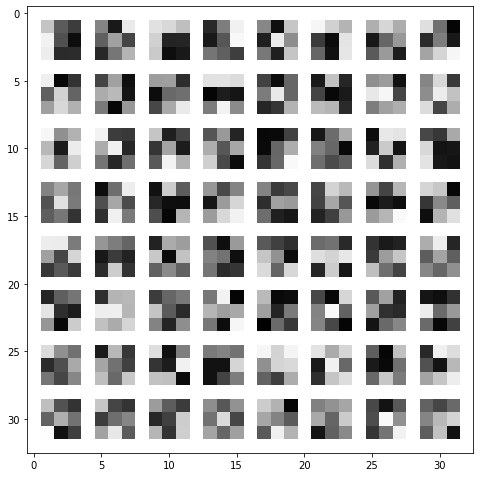

Visualization filters learned for layer: layer2


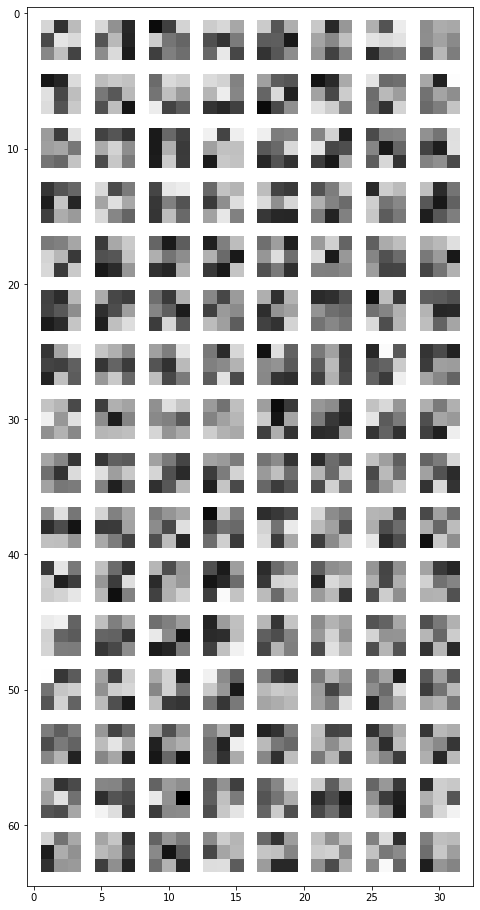

Visualization filters learned for layer: layer3


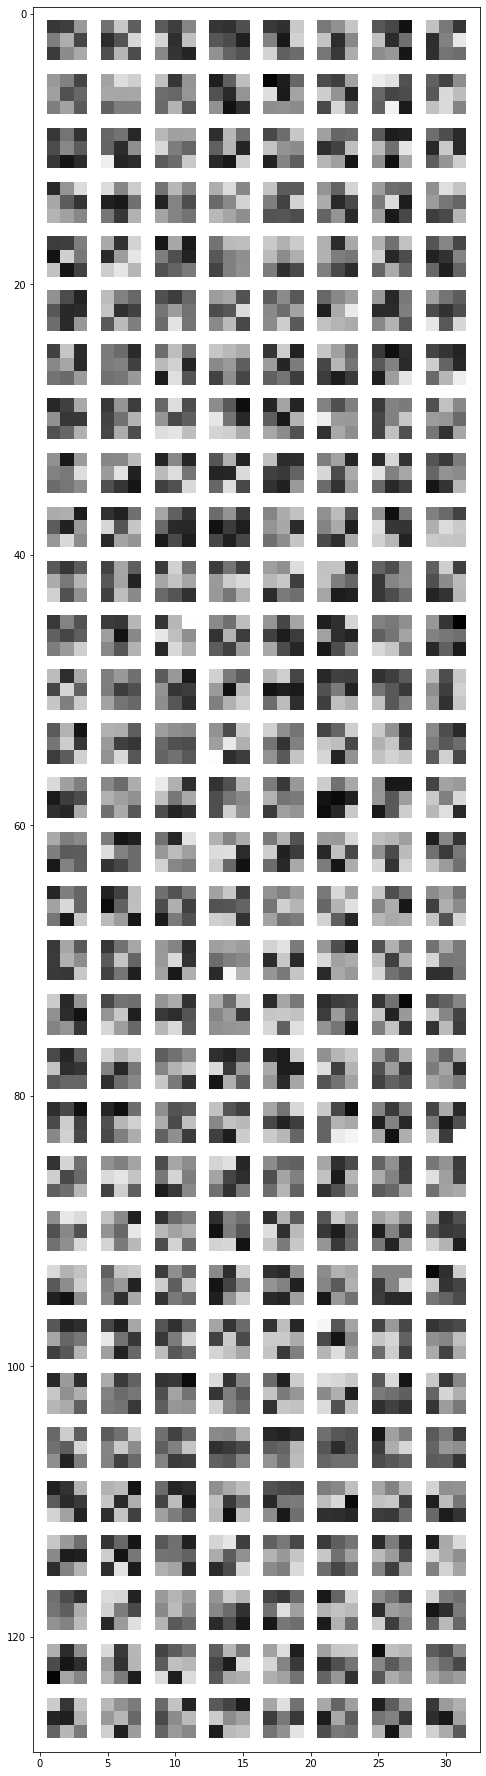

Visualization filters learned for layer: layer4


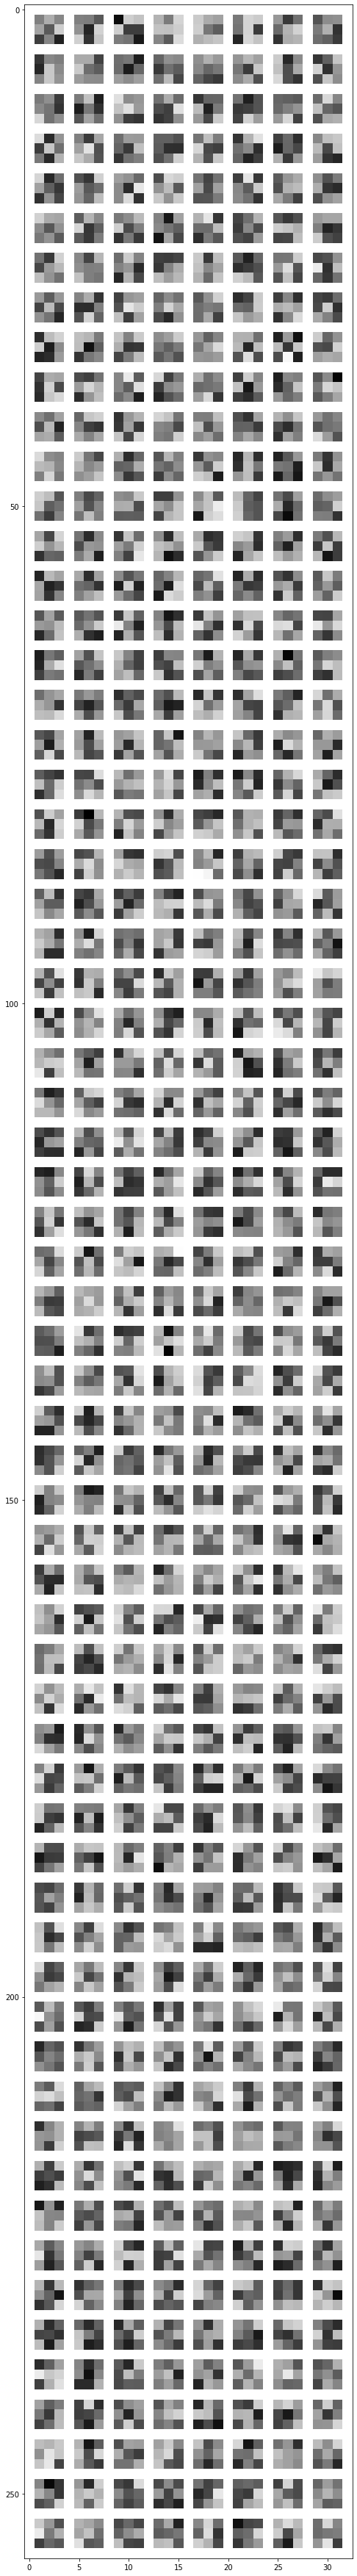

Visualization filters learned for layer: layer5


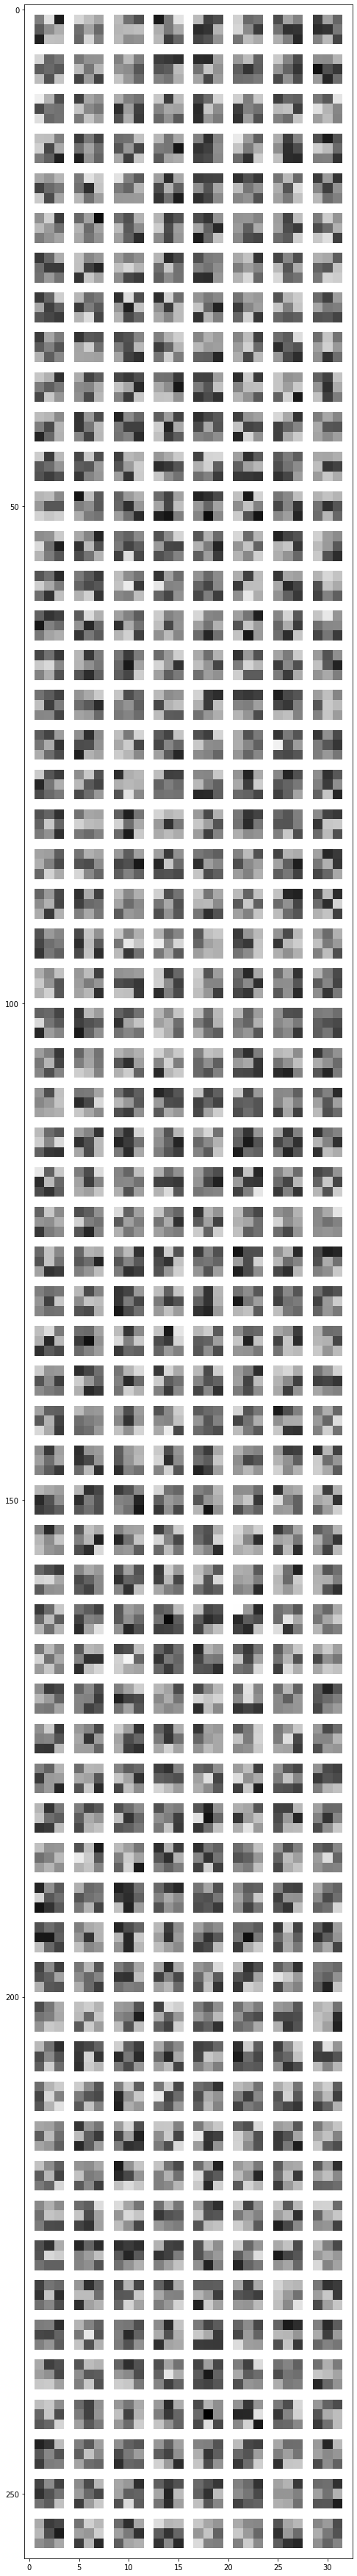

In [10]:
viz_filters(model_no_binary)

Interest of filters: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 63]
Consider 1% image regions = 10 images
mean image:
mean regions of 10 regions more=True or worst=False active for filter number: 0 :


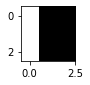

normalized region:


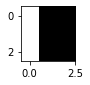

mean regions of 10 regions more=True or worst=False active for filter number: 5 :


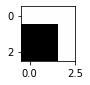

normalized region:


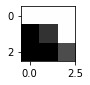

mean regions of 10 regions more=True or worst=False active for filter number: 10 :


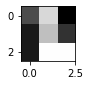

normalized region:


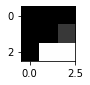

mean regions of 10 regions more=True or worst=False active for filter number: 15 :


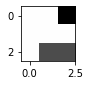

normalized region:


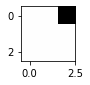

mean regions of 10 regions more=True or worst=False active for filter number: 20 :


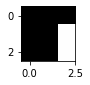

normalized region:


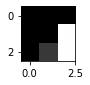

mean regions of 10 regions more=True or worst=False active for filter number: 25 :


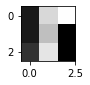

normalized region:


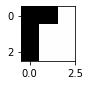

mean regions of 10 regions more=True or worst=False active for filter number: 30 :


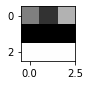

normalized region:


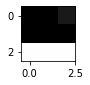

mean regions of 10 regions more=True or worst=False active for filter number: 35 :


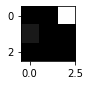

normalized region:


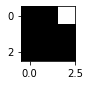

mean regions of 10 regions more=True or worst=False active for filter number: 40 :


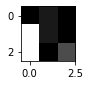

normalized region:


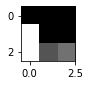

mean regions of 10 regions more=True or worst=False active for filter number: 45 :


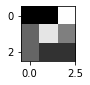

normalized region:


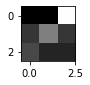

mean regions of 10 regions more=True or worst=False active for filter number: 50 :


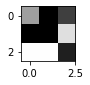

normalized region:


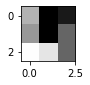

mean regions of 10 regions more=True or worst=False active for filter number: 55 :


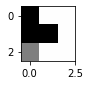

normalized region:


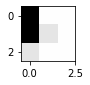

mean regions of 10 regions more=True or worst=False active for filter number: 60 :


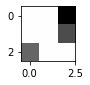

normalized region:


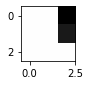

mean regions of 10 regions more=True or worst=False active for filter number: 63 :


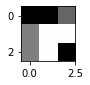

normalized region:


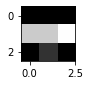

grid image
grid regions of 10 regions more=True or worst=False active for filter number: 0 :


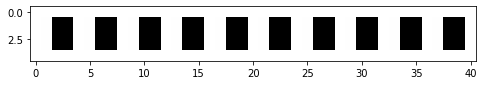

normalized regions:


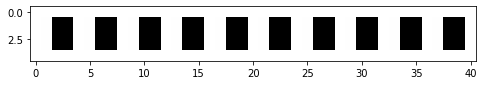

grid regions of 10 regions more=True or worst=False active for filter number: 5 :


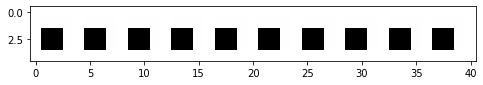

normalized regions:


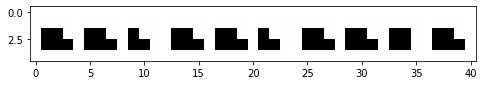

grid regions of 10 regions more=True or worst=False active for filter number: 10 :


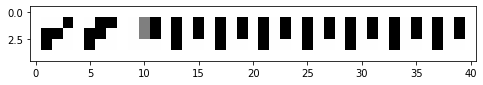

normalized regions:


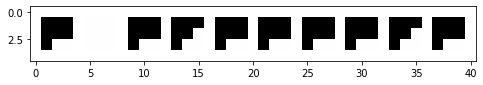

grid regions of 10 regions more=True or worst=False active for filter number: 15 :


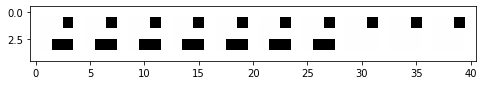

normalized regions:


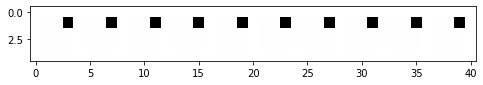

grid regions of 10 regions more=True or worst=False active for filter number: 20 :


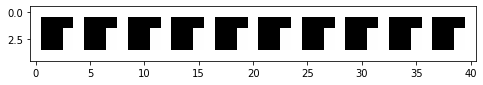

normalized regions:


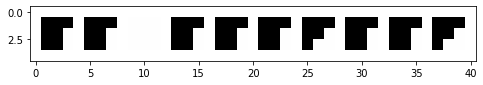

grid regions of 10 regions more=True or worst=False active for filter number: 25 :


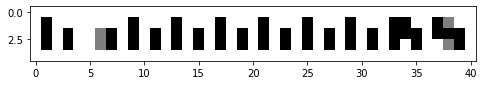

normalized regions:


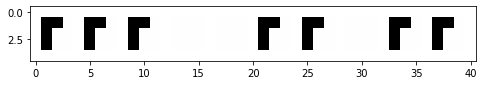

grid regions of 10 regions more=True or worst=False active for filter number: 30 :


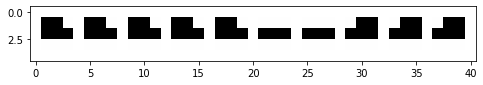

normalized regions:


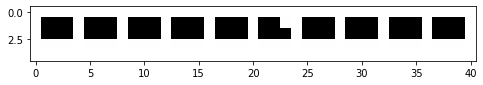

grid regions of 10 regions more=True or worst=False active for filter number: 35 :


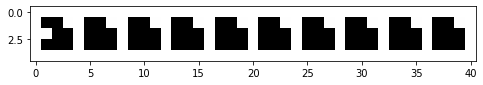

normalized regions:


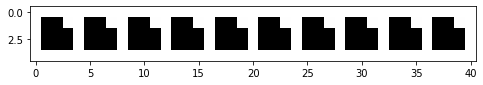

grid regions of 10 regions more=True or worst=False active for filter number: 40 :


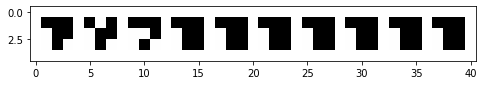

normalized regions:


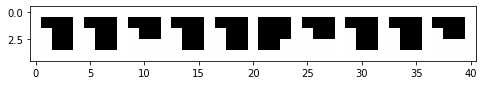

grid regions of 10 regions more=True or worst=False active for filter number: 45 :


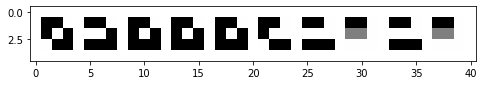

normalized regions:


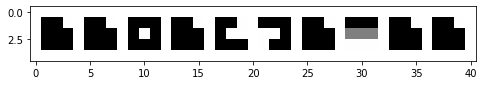

grid regions of 10 regions more=True or worst=False active for filter number: 50 :


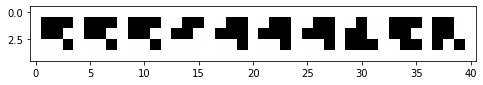

normalized regions:


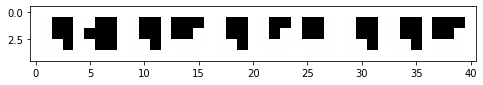

grid regions of 10 regions more=True or worst=False active for filter number: 55 :


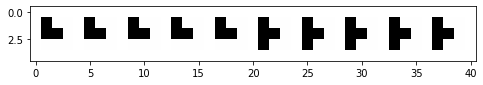

normalized regions:


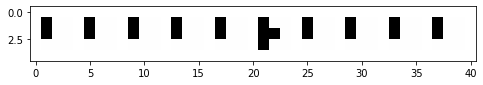

grid regions of 10 regions more=True or worst=False active for filter number: 60 :


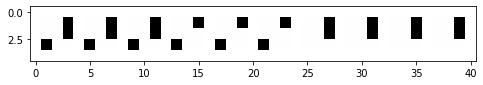

normalized regions:


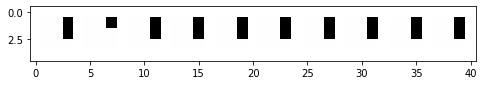

grid regions of 10 regions more=True or worst=False active for filter number: 63 :


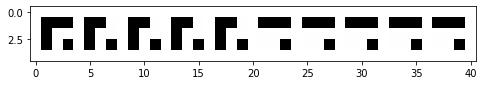

normalized regions:


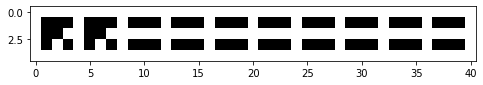

In [20]:
# parameters
list_filter_interest_layer1 = [0,5,10,15,20,25,30,35,40,45,50,55,60,63]
best = True
worst = False
viz_mean_img = True
viz_grid = True
percentage = 1
nrow=14

# regions and activation of interest
regions = region_layer1_no_binary
activations = activation_layer1_no_binary
activations_normalized = activation_layer1_no_binary_normalized


selected_regions, activation_values, activation_values_normalized = get_regions_interest(regions, activations, activations_normalized, best, worst, viz_mean_img, viz_grid, percentage, list_filter_interest_layer1, nrow=nrow)

##### No binary model layer2:

In [0]:
viz_filters(model_no_binary)

Interest of filters: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 80, 90, 100, 127]
Consider 10% image regions = 100 images
mean image:
mean regions of 100 regions more=True or worst=False active for filter number: 0 :


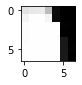

normalized region:


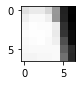

mean regions of 100 regions more=True or worst=False active for filter number: 5 :


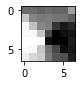

normalized region:


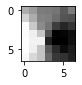

mean regions of 100 regions more=True or worst=False active for filter number: 10 :


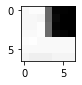

normalized region:


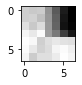

mean regions of 100 regions more=True or worst=False active for filter number: 15 :


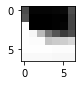

normalized region:


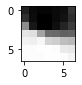

mean regions of 100 regions more=True or worst=False active for filter number: 20 :


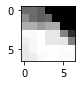

normalized region:


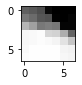

mean regions of 100 regions more=True or worst=False active for filter number: 25 :


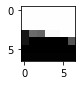

normalized region:


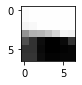

mean regions of 100 regions more=True or worst=False active for filter number: 30 :


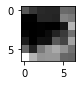

normalized region:


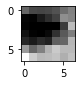

mean regions of 100 regions more=True or worst=False active for filter number: 35 :


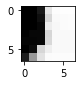

normalized region:


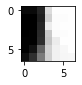

mean regions of 100 regions more=True or worst=False active for filter number: 40 :


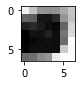

normalized region:


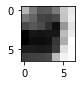

mean regions of 100 regions more=True or worst=False active for filter number: 45 :


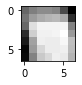

normalized region:


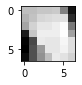

mean regions of 100 regions more=True or worst=False active for filter number: 50 :


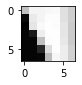

normalized region:


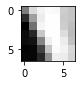

mean regions of 100 regions more=True or worst=False active for filter number: 55 :


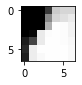

normalized region:


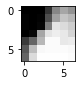

mean regions of 100 regions more=True or worst=False active for filter number: 60 :


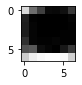

normalized region:


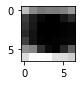

mean regions of 100 regions more=True or worst=False active for filter number: 65 :


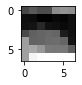

normalized region:


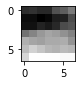

mean regions of 100 regions more=True or worst=False active for filter number: 70 :


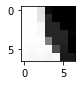

normalized region:


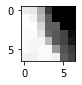

mean regions of 100 regions more=True or worst=False active for filter number: 80 :


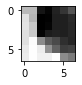

normalized region:


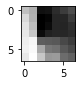

mean regions of 100 regions more=True or worst=False active for filter number: 90 :


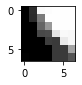

normalized region:


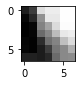

mean regions of 100 regions more=True or worst=False active for filter number: 100 :


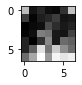

normalized region:


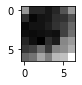

mean regions of 100 regions more=True or worst=False active for filter number: 127 :


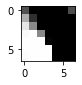

normalized region:


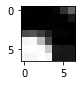

grid image
grid regions of 100 regions more=True or worst=False active for filter number: 0 :


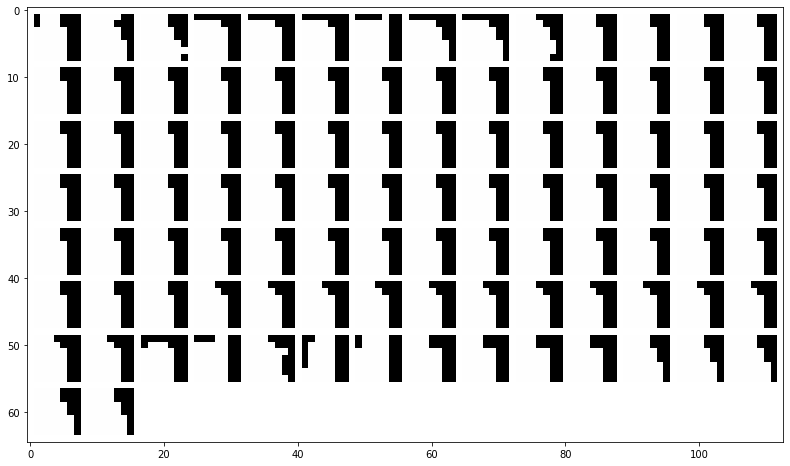

normalized regions:


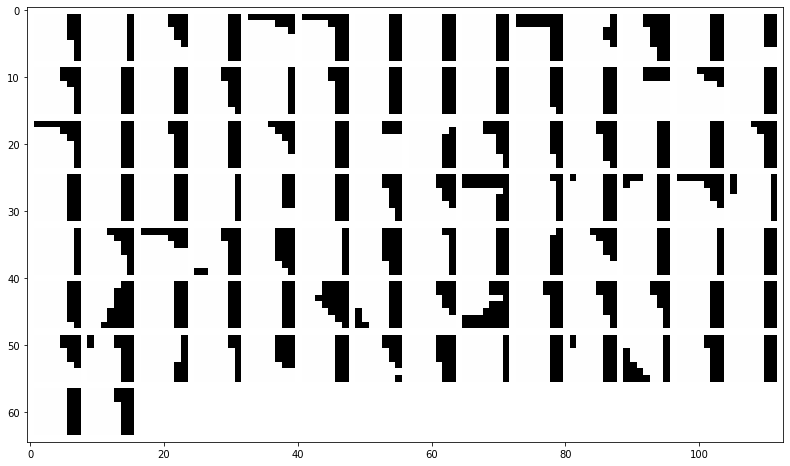

grid regions of 100 regions more=True or worst=False active for filter number: 5 :


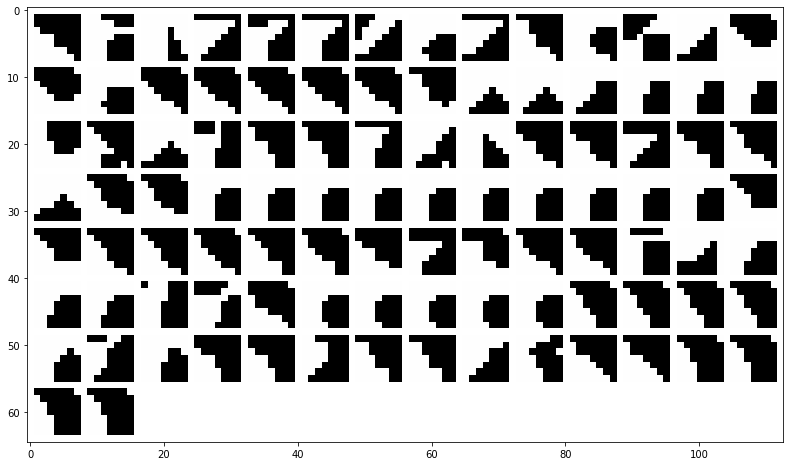

normalized regions:


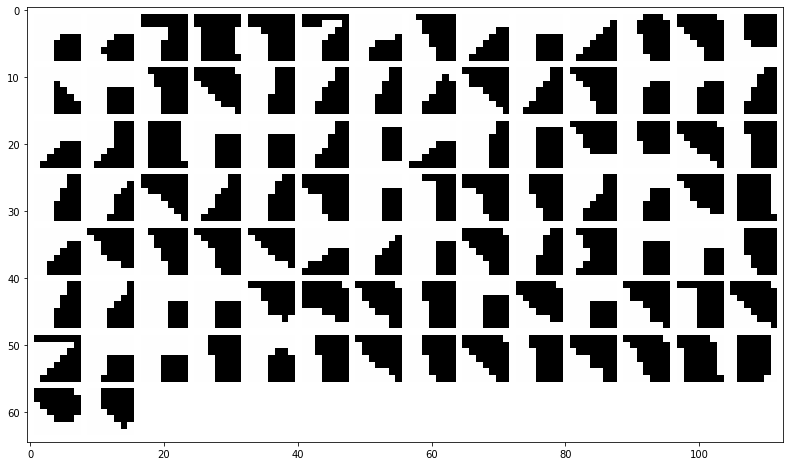

grid regions of 100 regions more=True or worst=False active for filter number: 10 :


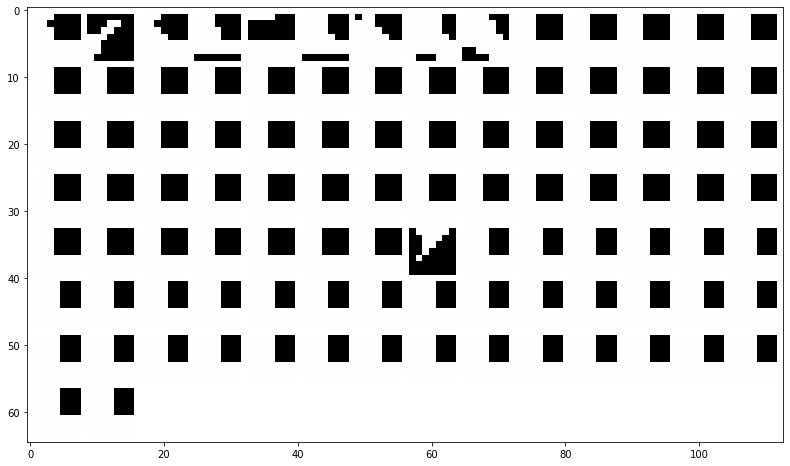

normalized regions:


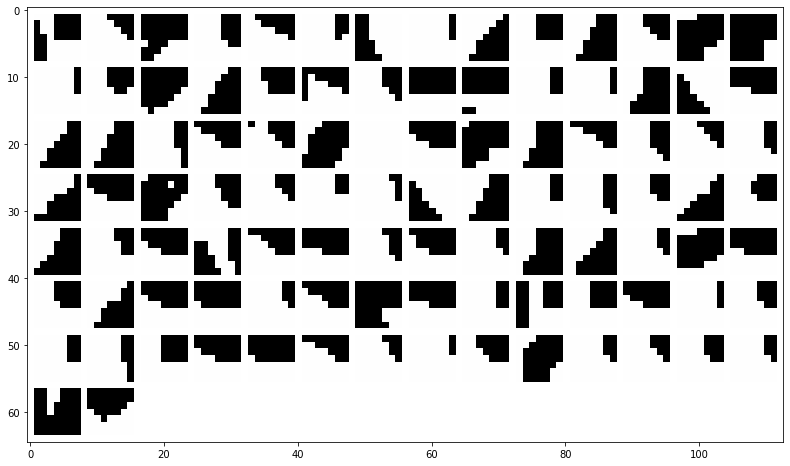

grid regions of 100 regions more=True or worst=False active for filter number: 15 :


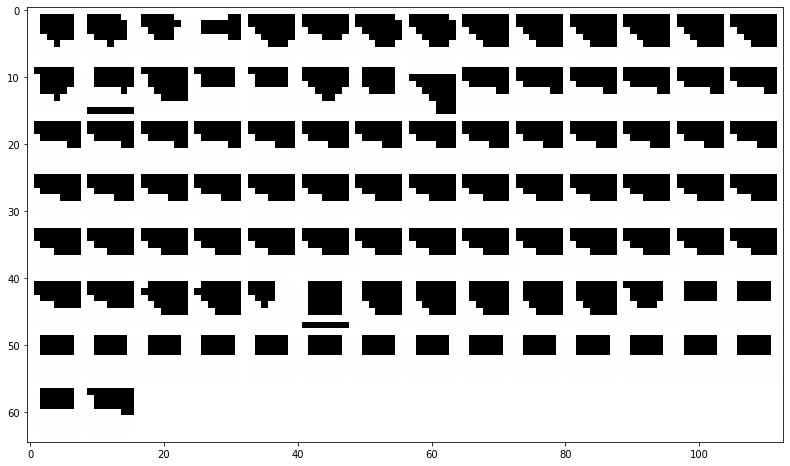

normalized regions:


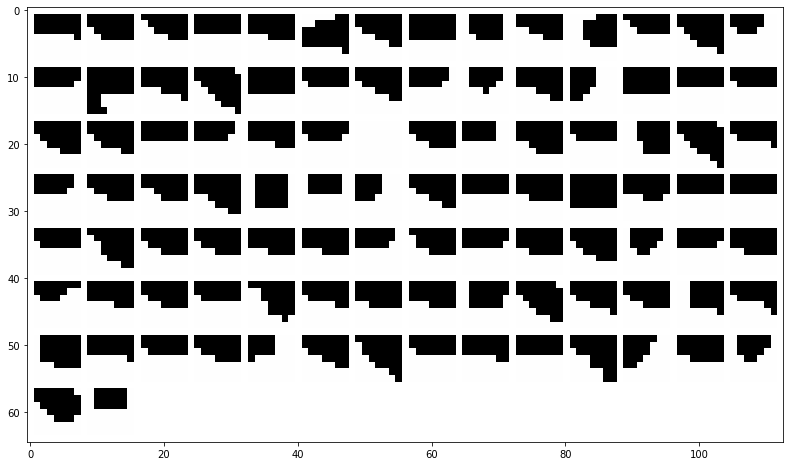

grid regions of 100 regions more=True or worst=False active for filter number: 20 :


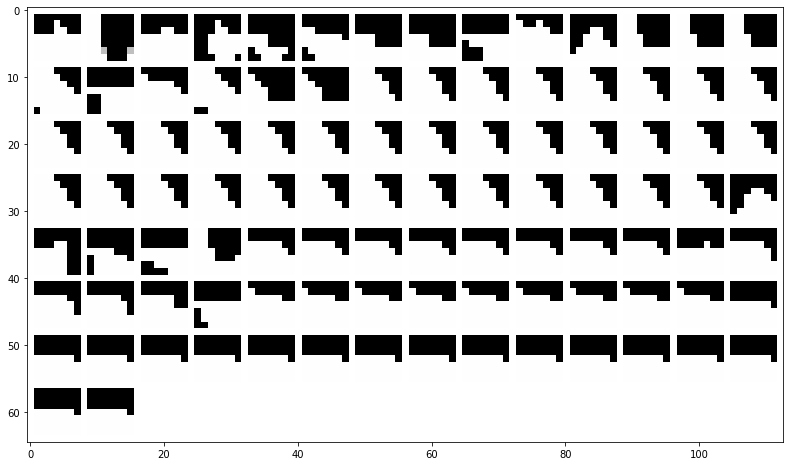

normalized regions:


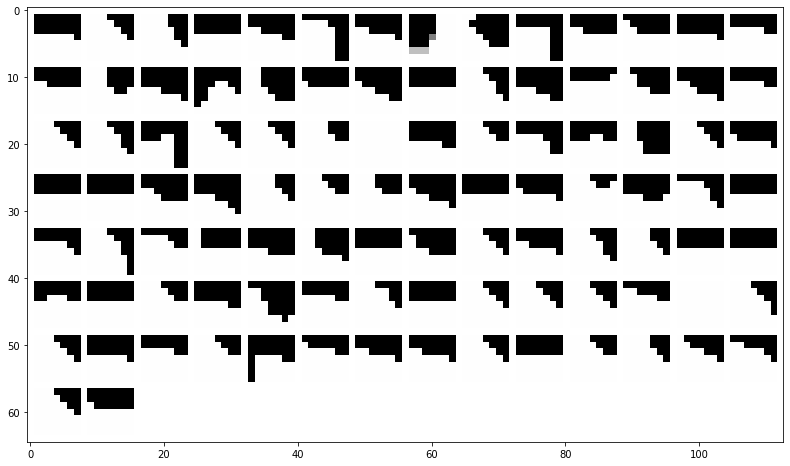

grid regions of 100 regions more=True or worst=False active for filter number: 25 :


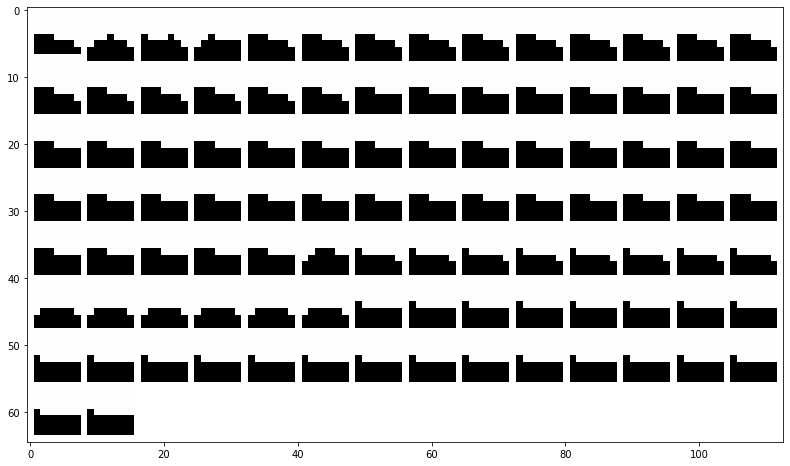

normalized regions:


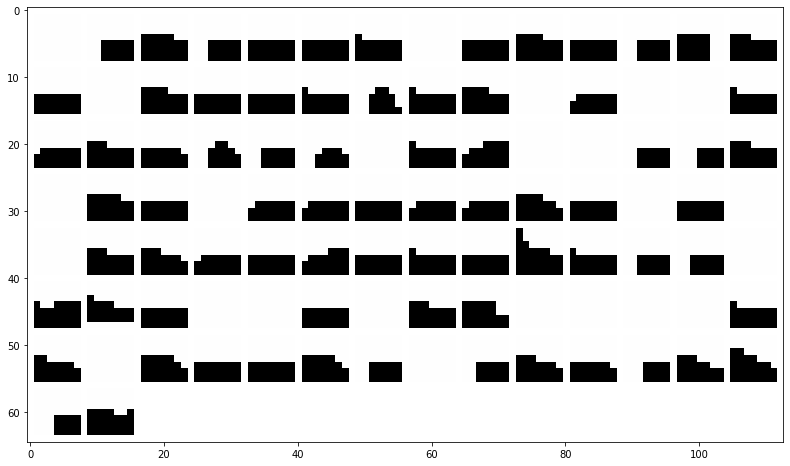

grid regions of 100 regions more=True or worst=False active for filter number: 30 :


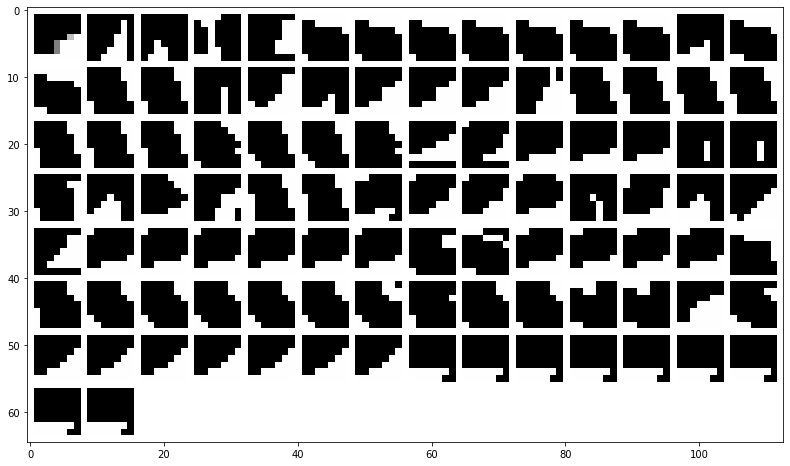

normalized regions:


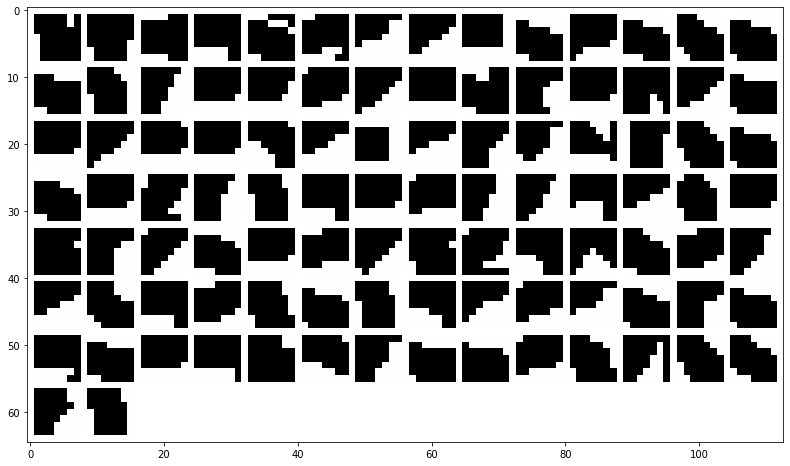

grid regions of 100 regions more=True or worst=False active for filter number: 35 :


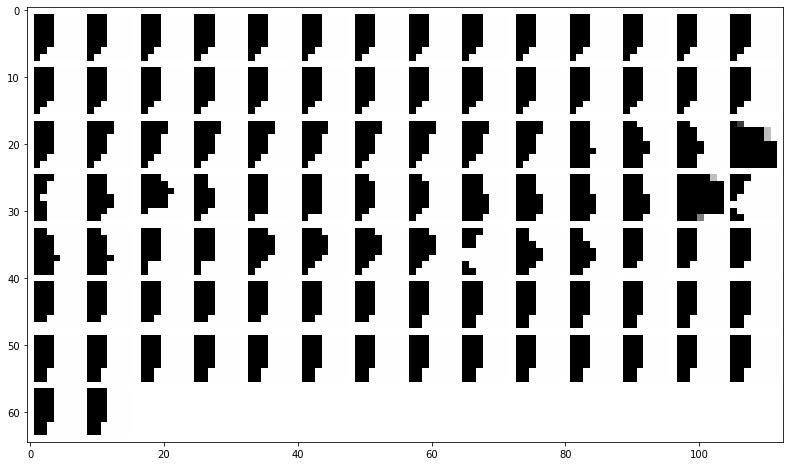

normalized regions:


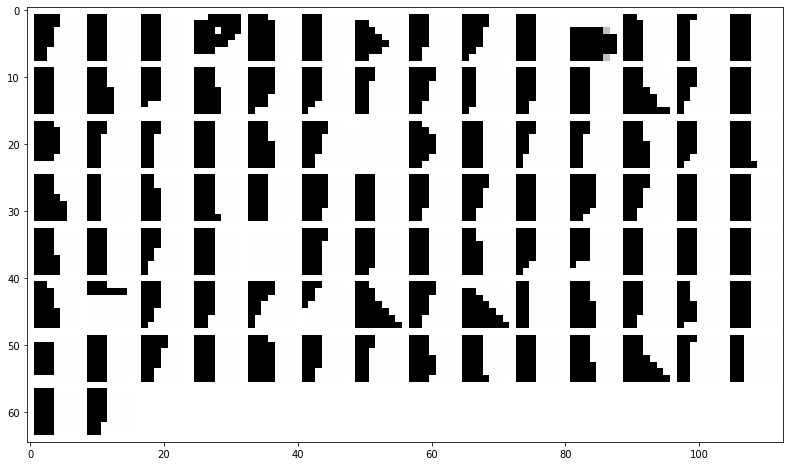

grid regions of 100 regions more=True or worst=False active for filter number: 40 :


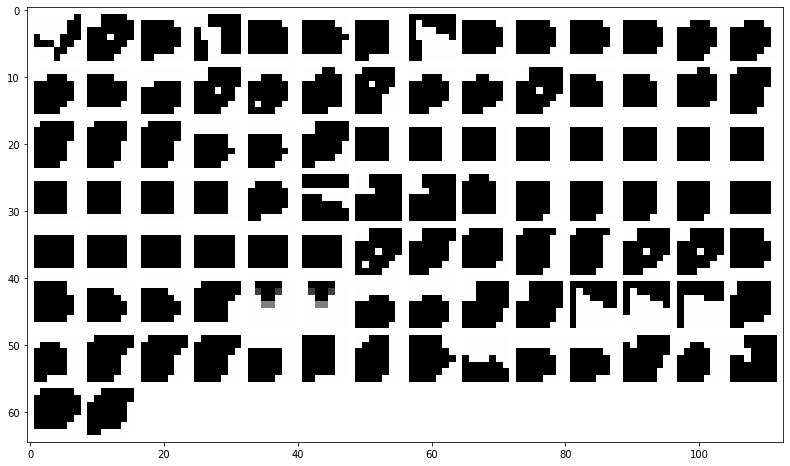

normalized regions:


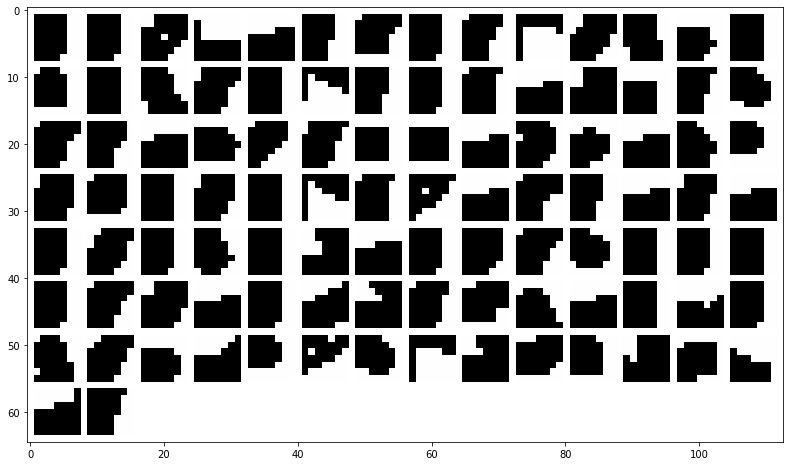

grid regions of 100 regions more=True or worst=False active for filter number: 45 :


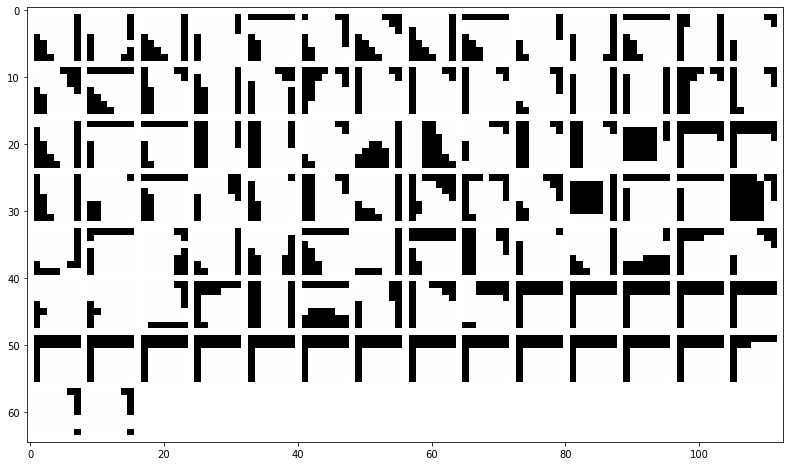

normalized regions:


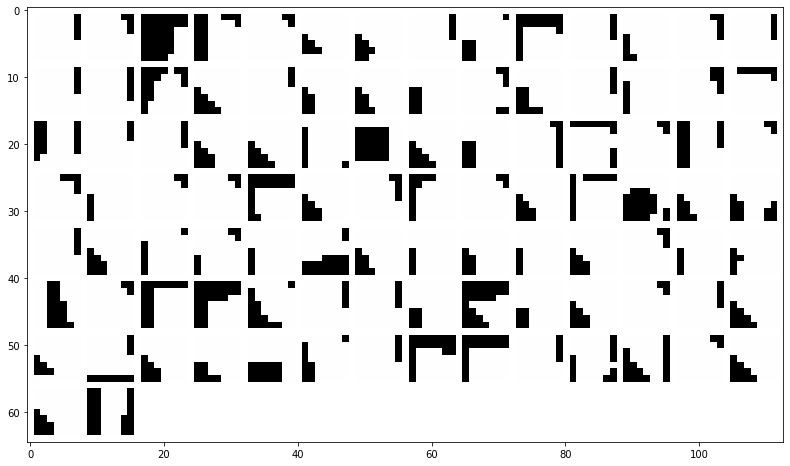

grid regions of 100 regions more=True or worst=False active for filter number: 50 :


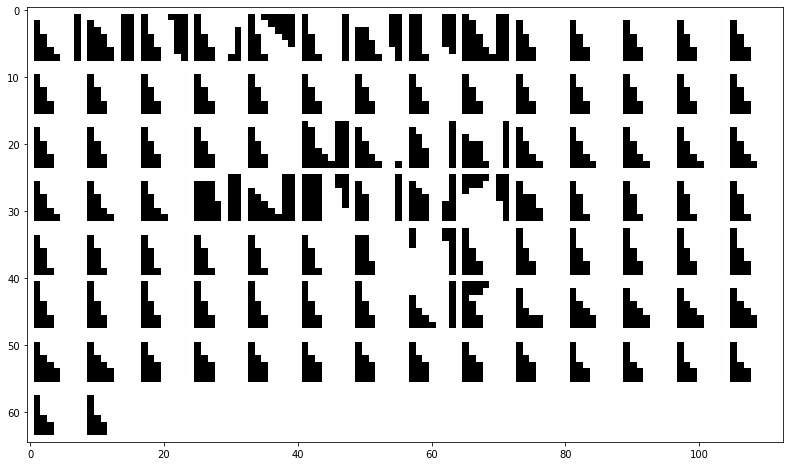

normalized regions:


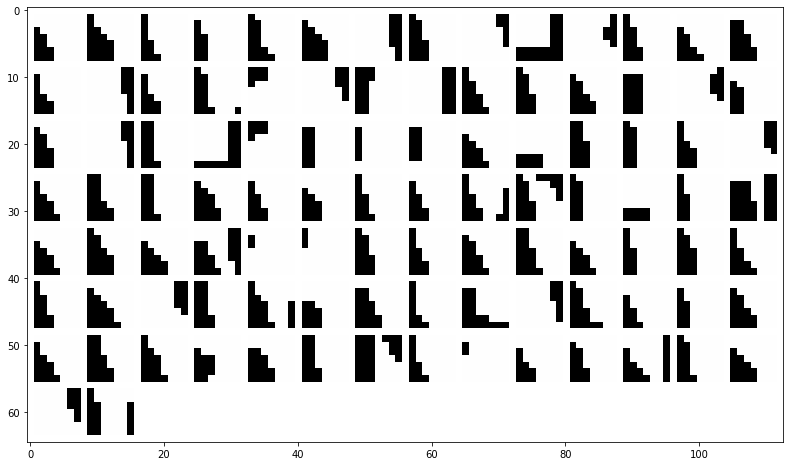

grid regions of 100 regions more=True or worst=False active for filter number: 55 :


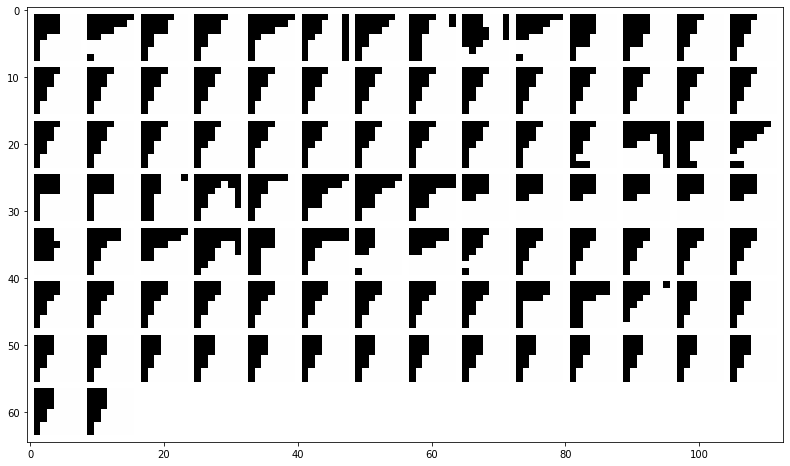

normalized regions:


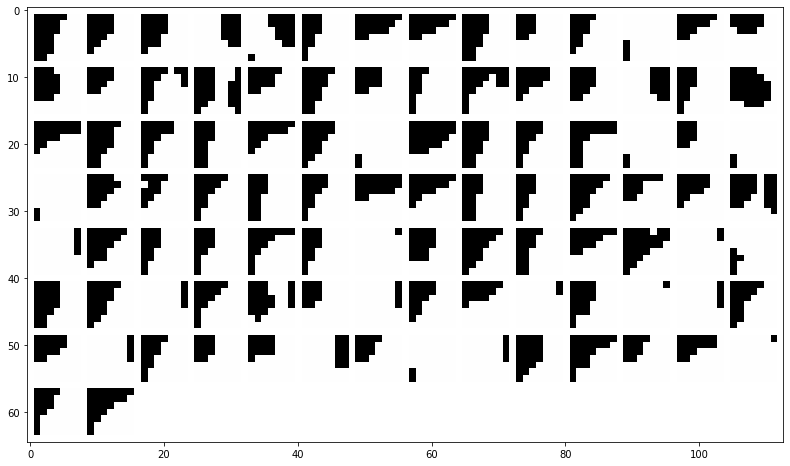

grid regions of 100 regions more=True or worst=False active for filter number: 60 :


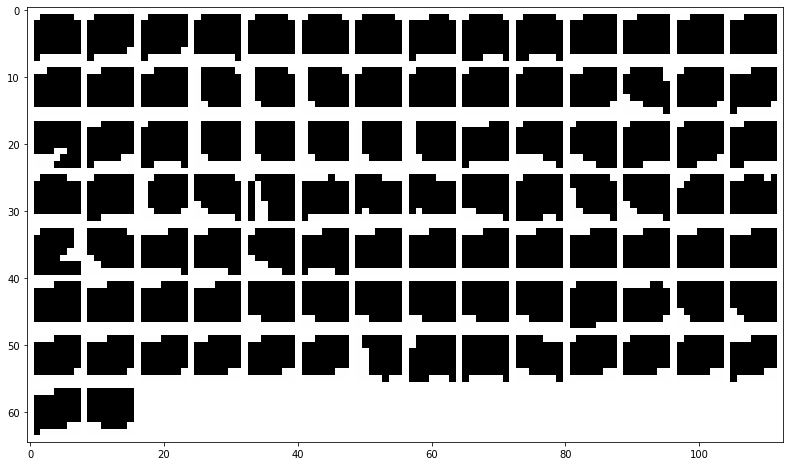

normalized regions:


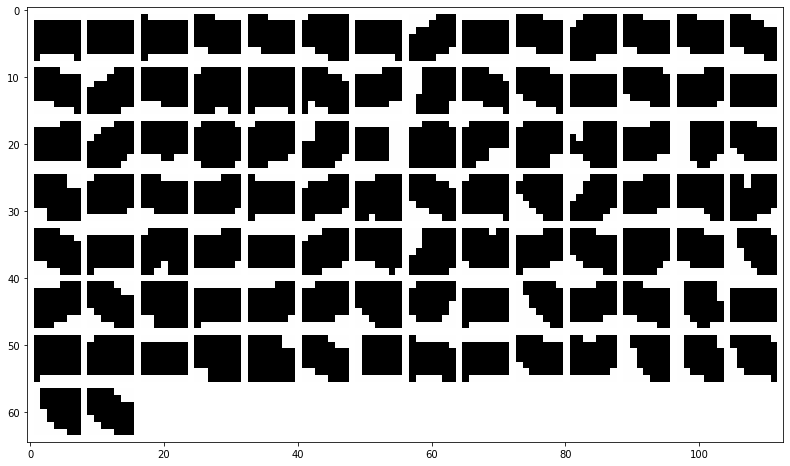

grid regions of 100 regions more=True or worst=False active for filter number: 65 :


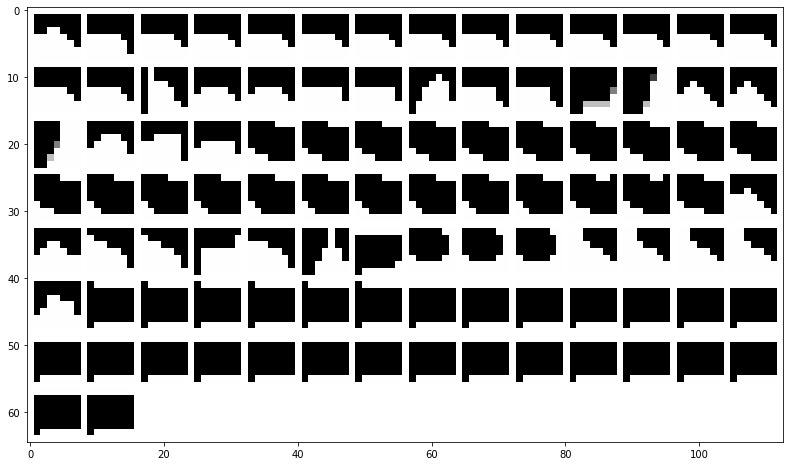

normalized regions:


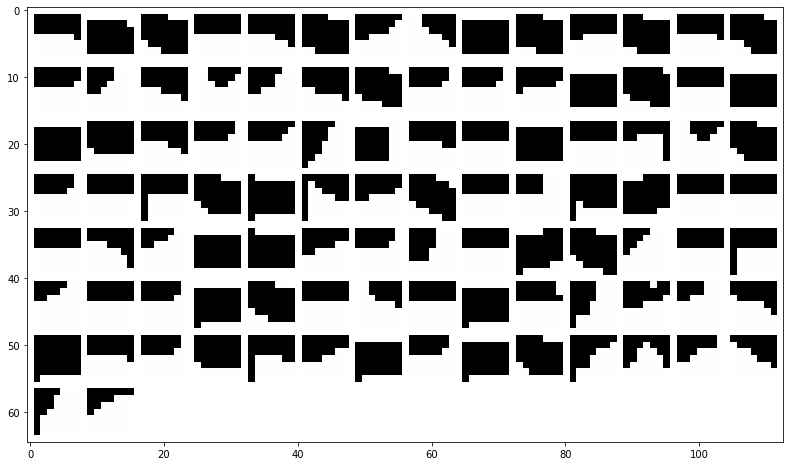

grid regions of 100 regions more=True or worst=False active for filter number: 70 :


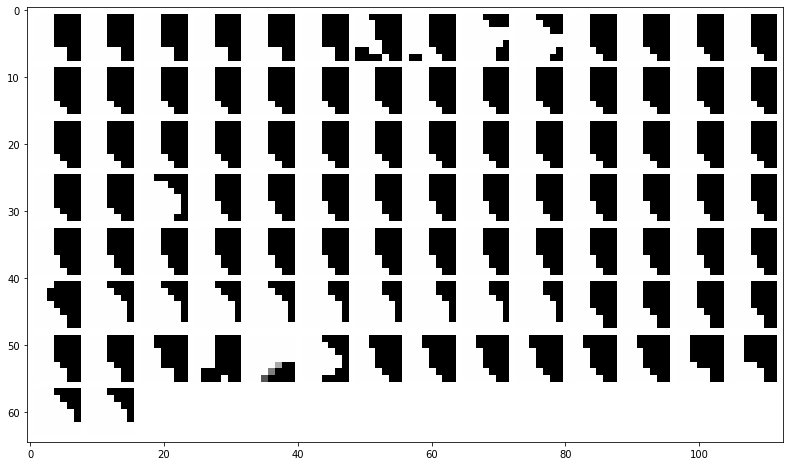

normalized regions:


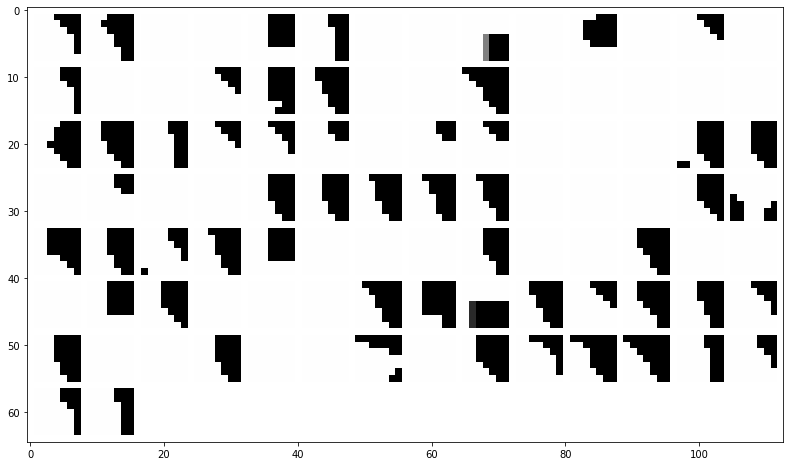

grid regions of 100 regions more=True or worst=False active for filter number: 80 :


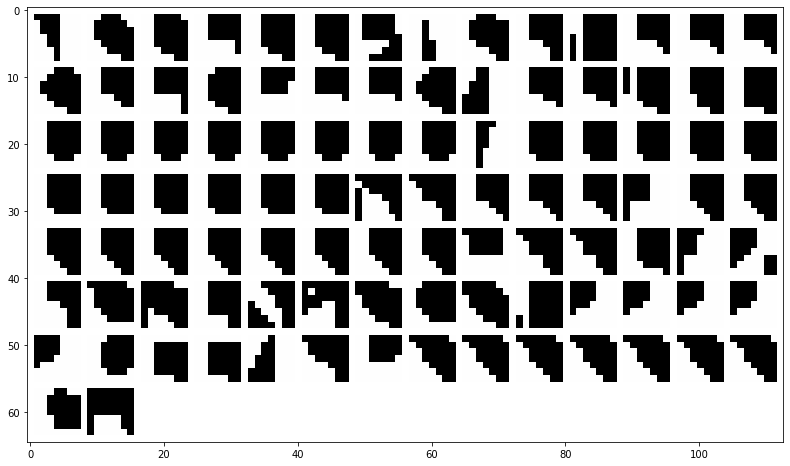

normalized regions:


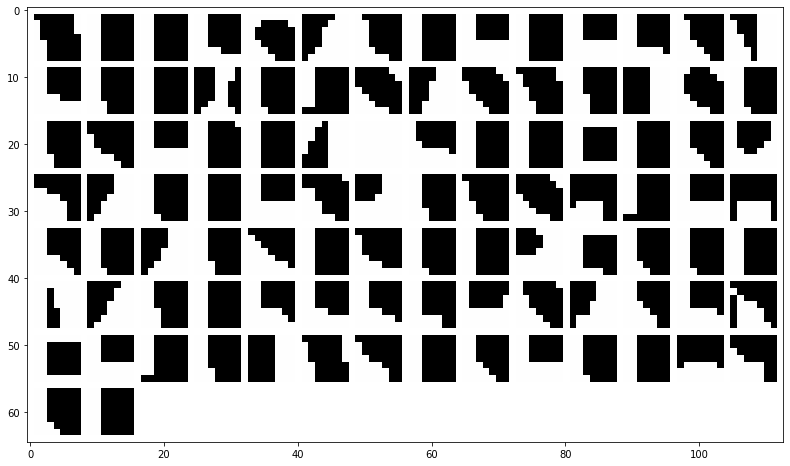

grid regions of 100 regions more=True or worst=False active for filter number: 90 :


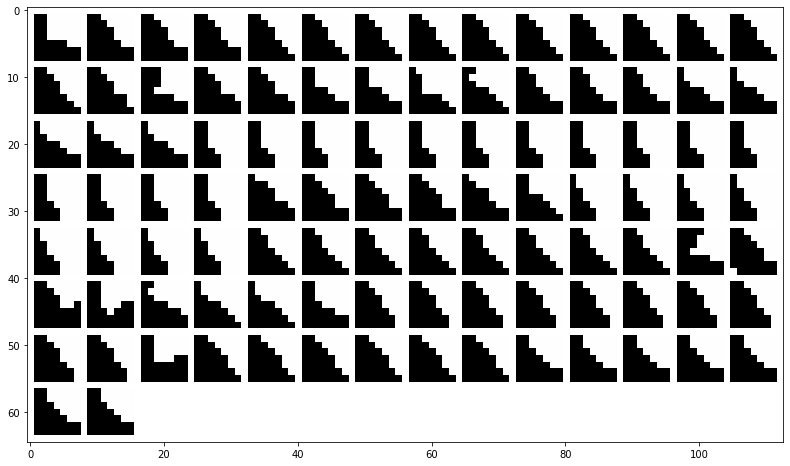

normalized regions:


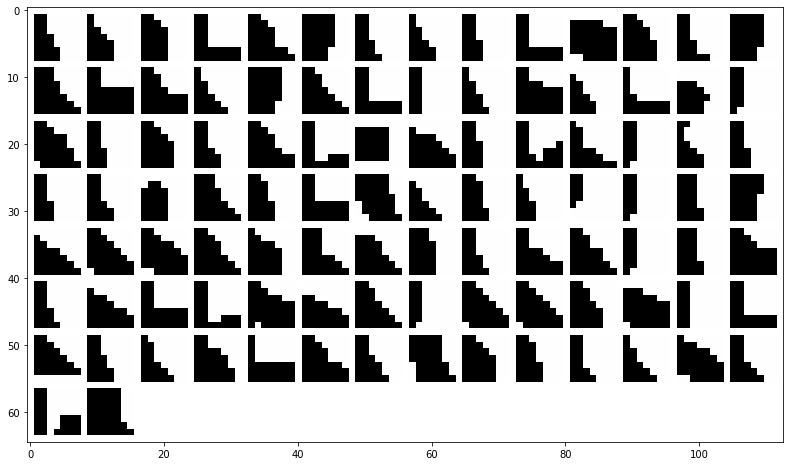

grid regions of 100 regions more=True or worst=False active for filter number: 100 :


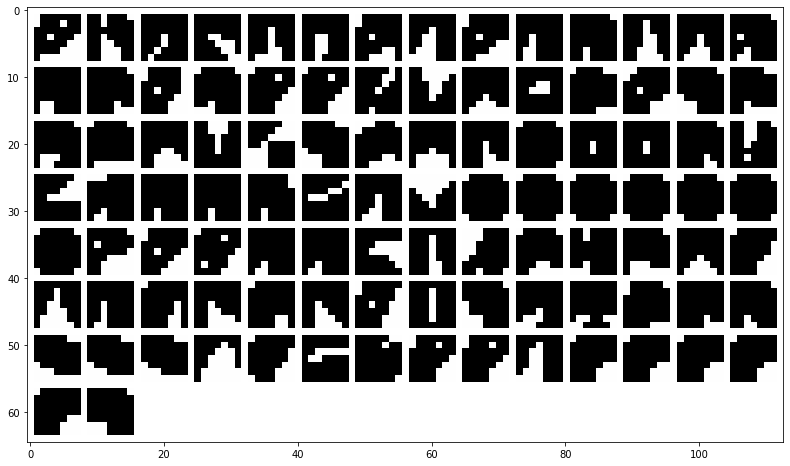

normalized regions:


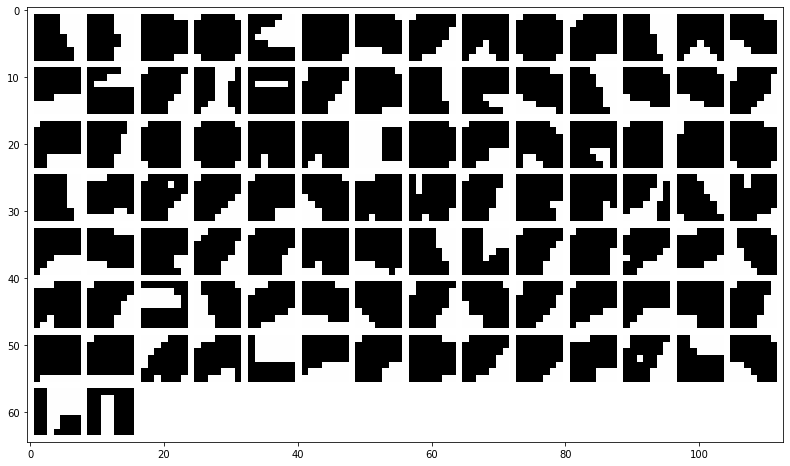

grid regions of 100 regions more=True or worst=False active for filter number: 127 :


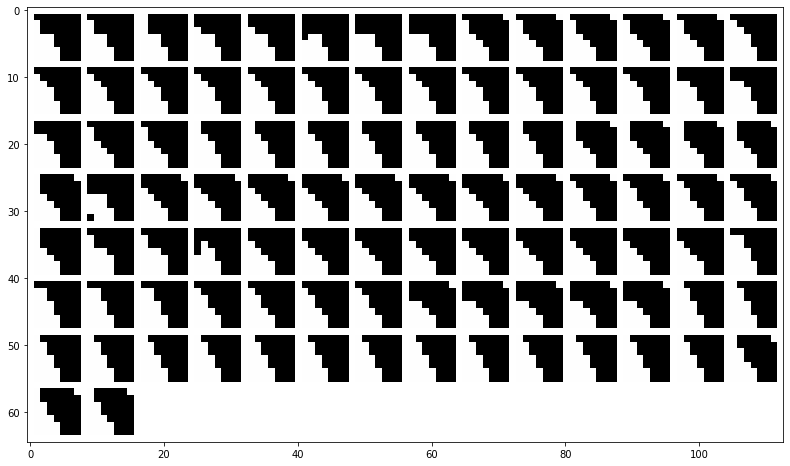

normalized regions:


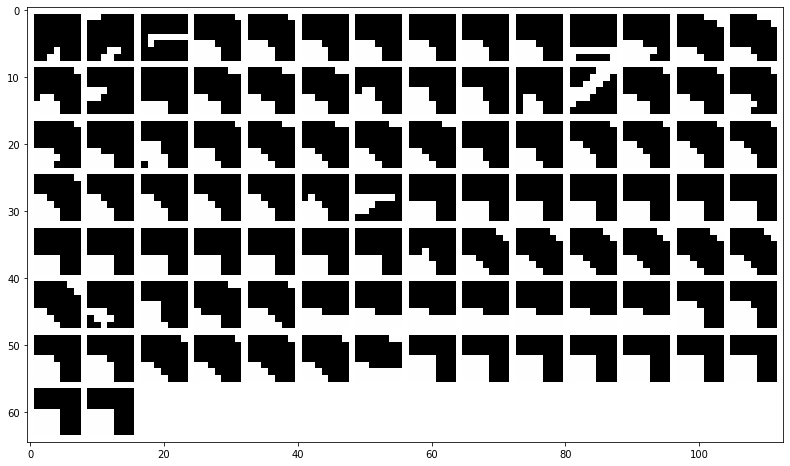

In [12]:
# parameters
list_filter_interest_layer2 = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,80,90,100,127]
best = True
worst = False
viz_mean_img = True
viz_grid = True
percentage = 10
nrow=14

# regions and activation of interest
regions = region_layer2_no_binary
activations = activation_layer2_no_binary
activations_normalized = activation_layer2_no_binary_normalized


selected_regions, activation_values, activation_values_normalized = get_regions_interest(regions, activations, activations_normalized, best, worst, viz_mean_img, viz_grid, percentage, list_filter_interest_layer2, nrow=nrow)

##### No binary model layer3:

In [0]:
viz_filters(model_no_binary)

Interest of filters: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 80, 90, 100, 127, 150, 200, 250, 255]
Consider 1% image regions = 10 images
mean image:
mean regions of 10 regions more=True or worst=False active for filter number: 0 :


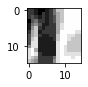

normalized region:


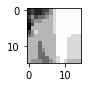

mean regions of 10 regions more=True or worst=False active for filter number: 5 :


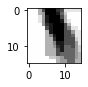

normalized region:


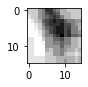

mean regions of 10 regions more=True or worst=False active for filter number: 10 :


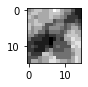

normalized region:


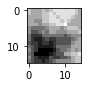

mean regions of 10 regions more=True or worst=False active for filter number: 15 :


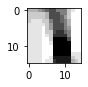

normalized region:


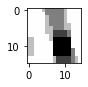

mean regions of 10 regions more=True or worst=False active for filter number: 20 :


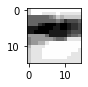

normalized region:


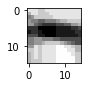

mean regions of 10 regions more=True or worst=False active for filter number: 25 :


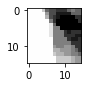

normalized region:


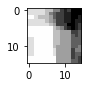

mean regions of 10 regions more=True or worst=False active for filter number: 30 :


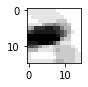

normalized region:


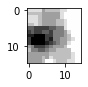

mean regions of 10 regions more=True or worst=False active for filter number: 35 :


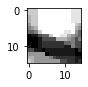

normalized region:


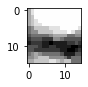

mean regions of 10 regions more=True or worst=False active for filter number: 40 :


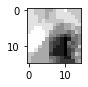

normalized region:


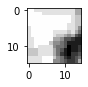

mean regions of 10 regions more=True or worst=False active for filter number: 45 :


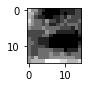

normalized region:


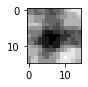

mean regions of 10 regions more=True or worst=False active for filter number: 50 :


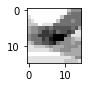

normalized region:


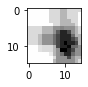

mean regions of 10 regions more=True or worst=False active for filter number: 55 :


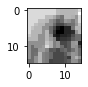

normalized region:


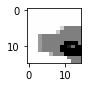

mean regions of 10 regions more=True or worst=False active for filter number: 60 :


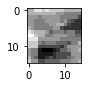

normalized region:


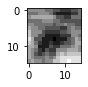

mean regions of 10 regions more=True or worst=False active for filter number: 65 :


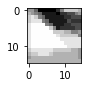

normalized region:


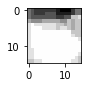

mean regions of 10 regions more=True or worst=False active for filter number: 70 :


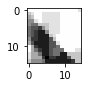

normalized region:


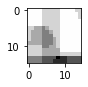

mean regions of 10 regions more=True or worst=False active for filter number: 80 :


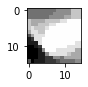

normalized region:


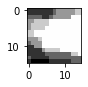

mean regions of 10 regions more=True or worst=False active for filter number: 90 :


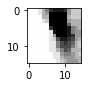

normalized region:


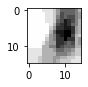

mean regions of 10 regions more=True or worst=False active for filter number: 100 :


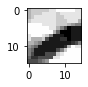

normalized region:


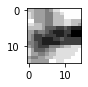

mean regions of 10 regions more=True or worst=False active for filter number: 127 :


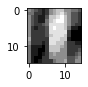

normalized region:


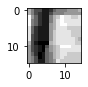

mean regions of 10 regions more=True or worst=False active for filter number: 150 :


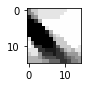

normalized region:


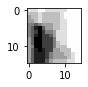

mean regions of 10 regions more=True or worst=False active for filter number: 200 :


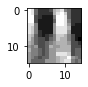

normalized region:


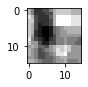

mean regions of 10 regions more=True or worst=False active for filter number: 250 :


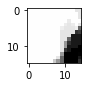

normalized region:


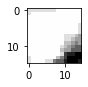

mean regions of 10 regions more=True or worst=False active for filter number: 255 :


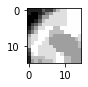

normalized region:


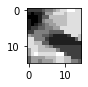

grid image
grid regions of 10 regions more=True or worst=False active for filter number: 0 :


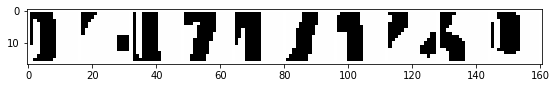

normalized regions:


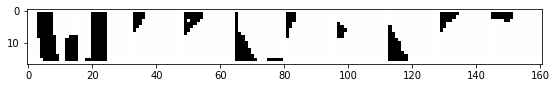

grid regions of 10 regions more=True or worst=False active for filter number: 5 :


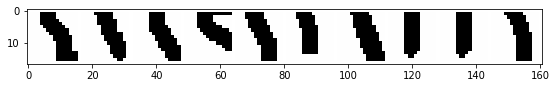

normalized regions:


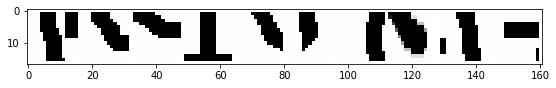

grid regions of 10 regions more=True or worst=False active for filter number: 10 :


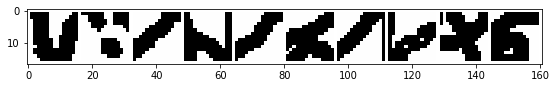

normalized regions:


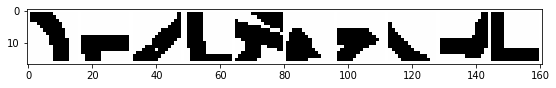

grid regions of 10 regions more=True or worst=False active for filter number: 15 :


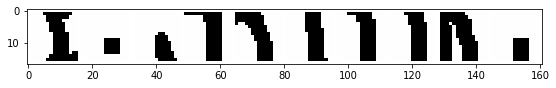

normalized regions:


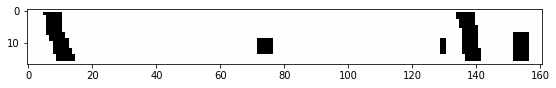

grid regions of 10 regions more=True or worst=False active for filter number: 20 :


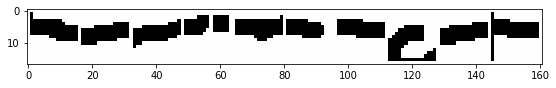

normalized regions:


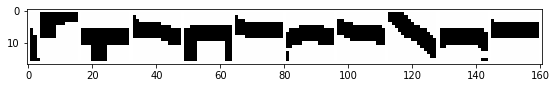

grid regions of 10 regions more=True or worst=False active for filter number: 25 :


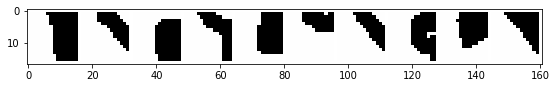

normalized regions:


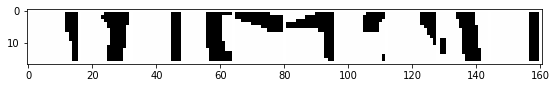

grid regions of 10 regions more=True or worst=False active for filter number: 30 :


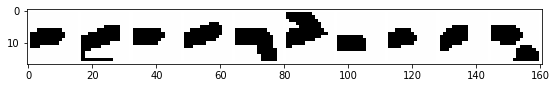

normalized regions:


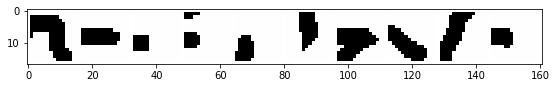

grid regions of 10 regions more=True or worst=False active for filter number: 35 :


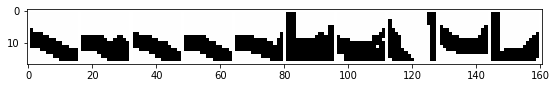

normalized regions:


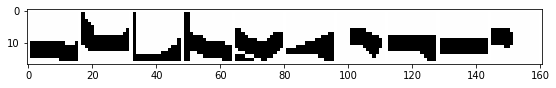

grid regions of 10 regions more=True or worst=False active for filter number: 40 :


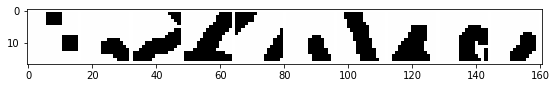

normalized regions:


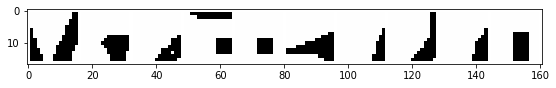

grid regions of 10 regions more=True or worst=False active for filter number: 45 :


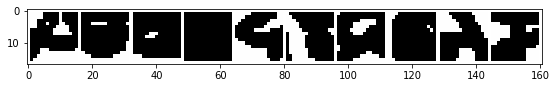

normalized regions:


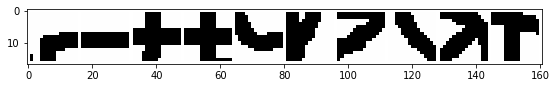

grid regions of 10 regions more=True or worst=False active for filter number: 50 :


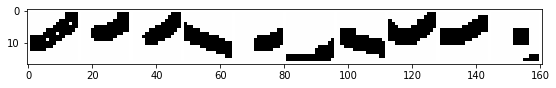

normalized regions:


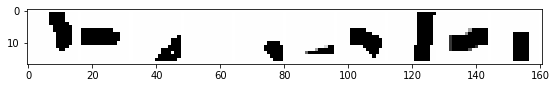

grid regions of 10 regions more=True or worst=False active for filter number: 55 :


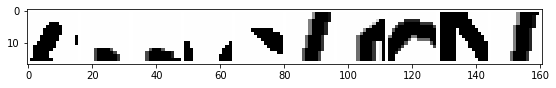

normalized regions:


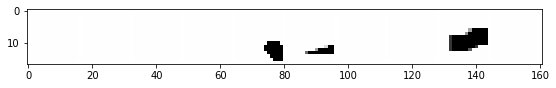

grid regions of 10 regions more=True or worst=False active for filter number: 60 :


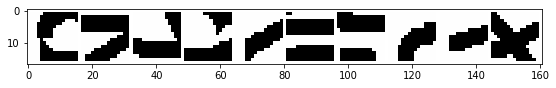

normalized regions:


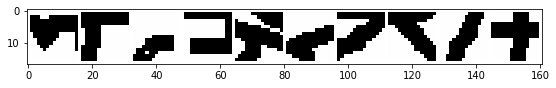

grid regions of 10 regions more=True or worst=False active for filter number: 65 :


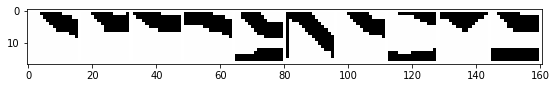

normalized regions:


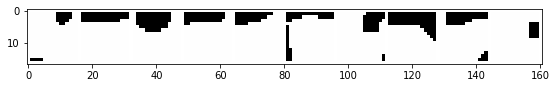

grid regions of 10 regions more=True or worst=False active for filter number: 70 :


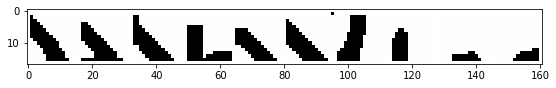

normalized regions:


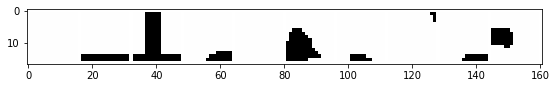

grid regions of 10 regions more=True or worst=False active for filter number: 80 :


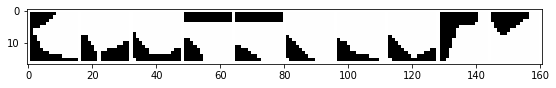

normalized regions:


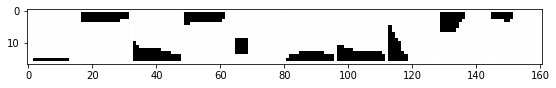

grid regions of 10 regions more=True or worst=False active for filter number: 90 :


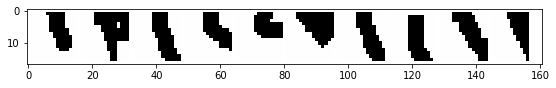

normalized regions:


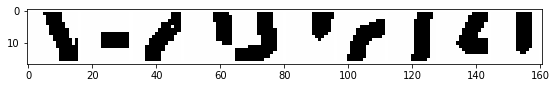

grid regions of 10 regions more=True or worst=False active for filter number: 100 :


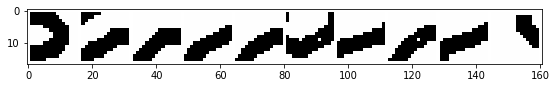

normalized regions:


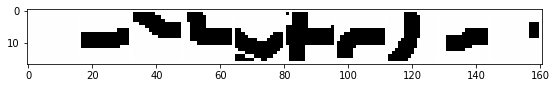

grid regions of 10 regions more=True or worst=False active for filter number: 127 :


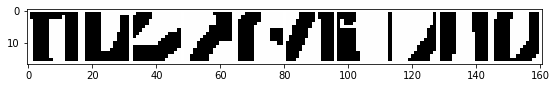

normalized regions:


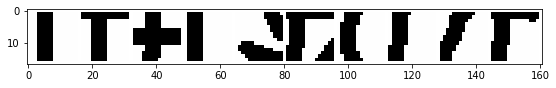

grid regions of 10 regions more=True or worst=False active for filter number: 150 :


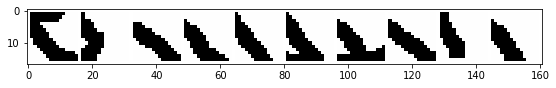

normalized regions:


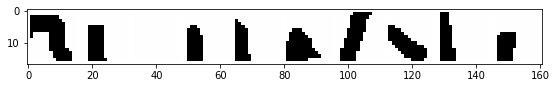

grid regions of 10 regions more=True or worst=False active for filter number: 200 :


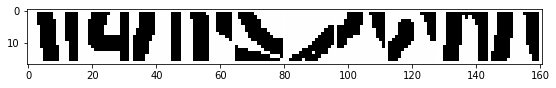

normalized regions:


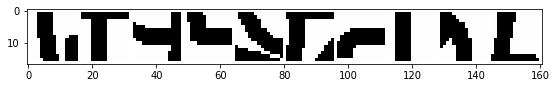

grid regions of 10 regions more=True or worst=False active for filter number: 250 :


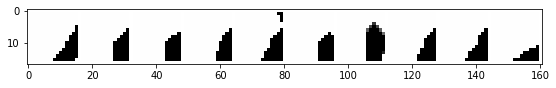

normalized regions:


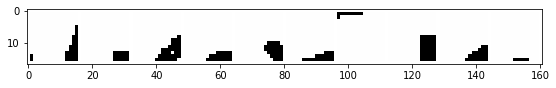

grid regions of 10 regions more=True or worst=False active for filter number: 255 :


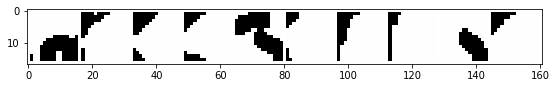

normalized regions:


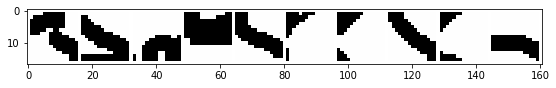

In [21]:
# parameters
list_filter_interest_layer3 = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,80,90,100,127,150,200,250,255]
best = True
worst = False
viz_mean_img = True
viz_grid = True
percentage = 1
nrow=14

# regions and activation of interest
regions = region_layer3_no_binary
activations = activation_layer3_no_binary
activations_normalized = activation_layer3_no_binary_normalized


selected_regions, activation_values, activation_values_normalized = get_regions_interest(regions, activations, activations_normalized, best, worst, viz_mean_img, viz_grid, percentage, list_filter_interest_layer3, nrow=nrow)

##### No binary model layer4:

In [0]:
viz_filters(model_no_binary)

Interest of filters: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 80, 90, 100, 127, 150, 200, 250, 255, 300, 350, 400, 450, 500, 511]
Consider 0.1% image regions = 1 images
mean image:
mean regions of 1 regions more=True or worst=False active for filter number: 0 :


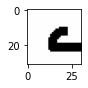

normalized region:


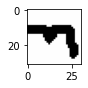

mean regions of 1 regions more=True or worst=False active for filter number: 5 :


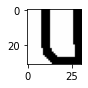

normalized region:


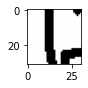

mean regions of 1 regions more=True or worst=False active for filter number: 10 :


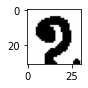

normalized region:


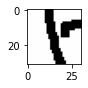

mean regions of 1 regions more=True or worst=False active for filter number: 15 :


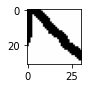

normalized region:


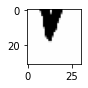

mean regions of 1 regions more=True or worst=False active for filter number: 20 :


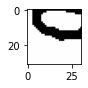

normalized region:


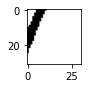

mean regions of 1 regions more=True or worst=False active for filter number: 25 :


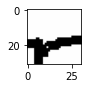

normalized region:


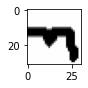

mean regions of 1 regions more=True or worst=False active for filter number: 30 :


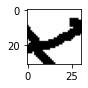

normalized region:


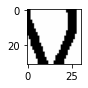

mean regions of 1 regions more=True or worst=False active for filter number: 35 :


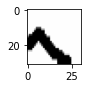

normalized region:


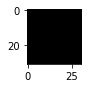

mean regions of 1 regions more=True or worst=False active for filter number: 40 :


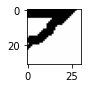

normalized region:


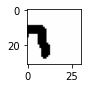

mean regions of 1 regions more=True or worst=False active for filter number: 45 :


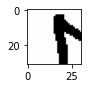

normalized region:


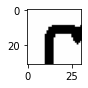

mean regions of 1 regions more=True or worst=False active for filter number: 50 :


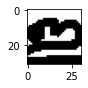

normalized region:


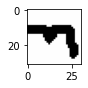

mean regions of 1 regions more=True or worst=False active for filter number: 55 :


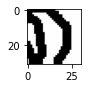

normalized region:


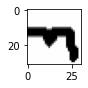

mean regions of 1 regions more=True or worst=False active for filter number: 60 :


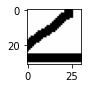

normalized region:


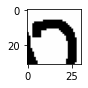

mean regions of 1 regions more=True or worst=False active for filter number: 65 :


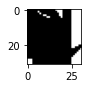

normalized region:


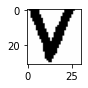

mean regions of 1 regions more=True or worst=False active for filter number: 70 :


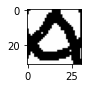

normalized region:


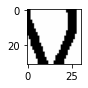

mean regions of 1 regions more=True or worst=False active for filter number: 80 :


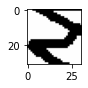

normalized region:


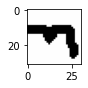

mean regions of 1 regions more=True or worst=False active for filter number: 90 :


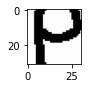

normalized region:


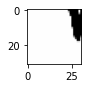

mean regions of 1 regions more=True or worst=False active for filter number: 100 :


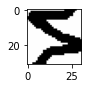

normalized region:


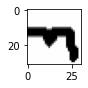

mean regions of 1 regions more=True or worst=False active for filter number: 127 :


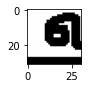

normalized region:


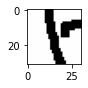

mean regions of 1 regions more=True or worst=False active for filter number: 150 :


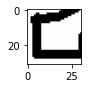

normalized region:


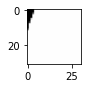

mean regions of 1 regions more=True or worst=False active for filter number: 200 :


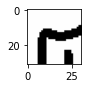

normalized region:


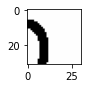

mean regions of 1 regions more=True or worst=False active for filter number: 250 :


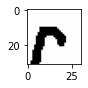

normalized region:


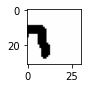

mean regions of 1 regions more=True or worst=False active for filter number: 255 :


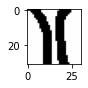

normalized region:


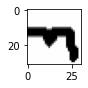

mean regions of 1 regions more=True or worst=False active for filter number: 300 :


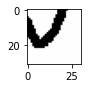

normalized region:


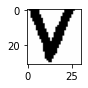

mean regions of 1 regions more=True or worst=False active for filter number: 350 :


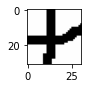

normalized region:


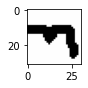

mean regions of 1 regions more=True or worst=False active for filter number: 400 :


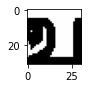

normalized region:


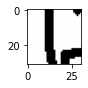

mean regions of 1 regions more=True or worst=False active for filter number: 450 :


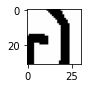

normalized region:


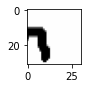

mean regions of 1 regions more=True or worst=False active for filter number: 500 :


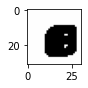

normalized region:


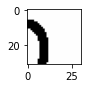

mean regions of 1 regions more=True or worst=False active for filter number: 511 :


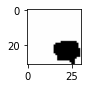

normalized region:


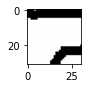

grid image
grid regions of 1 regions more=True or worst=False active for filter number: 0 :


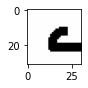

normalized regions:


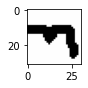

grid regions of 1 regions more=True or worst=False active for filter number: 5 :


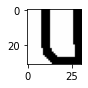

normalized regions:


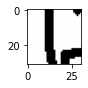

grid regions of 1 regions more=True or worst=False active for filter number: 10 :


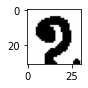

normalized regions:


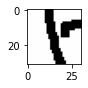

grid regions of 1 regions more=True or worst=False active for filter number: 15 :


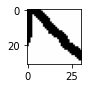

normalized regions:


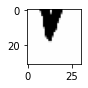

grid regions of 1 regions more=True or worst=False active for filter number: 20 :


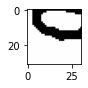

normalized regions:


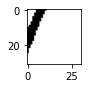

grid regions of 1 regions more=True or worst=False active for filter number: 25 :


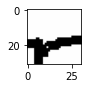

normalized regions:


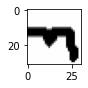

grid regions of 1 regions more=True or worst=False active for filter number: 30 :


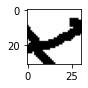

normalized regions:


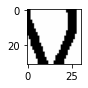

grid regions of 1 regions more=True or worst=False active for filter number: 35 :


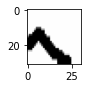

normalized regions:


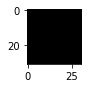

grid regions of 1 regions more=True or worst=False active for filter number: 40 :


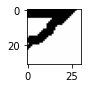

normalized regions:


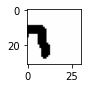

grid regions of 1 regions more=True or worst=False active for filter number: 45 :


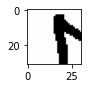

normalized regions:


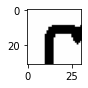

grid regions of 1 regions more=True or worst=False active for filter number: 50 :


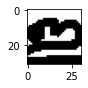

normalized regions:


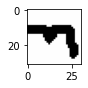

grid regions of 1 regions more=True or worst=False active for filter number: 55 :


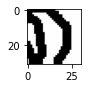

normalized regions:


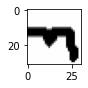

grid regions of 1 regions more=True or worst=False active for filter number: 60 :


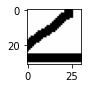

normalized regions:


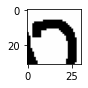

grid regions of 1 regions more=True or worst=False active for filter number: 65 :


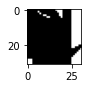

normalized regions:


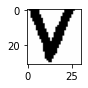

grid regions of 1 regions more=True or worst=False active for filter number: 70 :


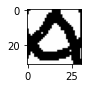

normalized regions:


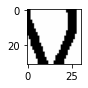

grid regions of 1 regions more=True or worst=False active for filter number: 80 :


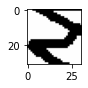

normalized regions:


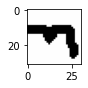

grid regions of 1 regions more=True or worst=False active for filter number: 90 :


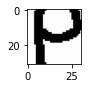

normalized regions:


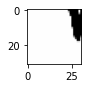

grid regions of 1 regions more=True or worst=False active for filter number: 100 :


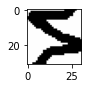

normalized regions:


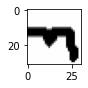

grid regions of 1 regions more=True or worst=False active for filter number: 127 :


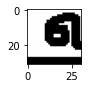

normalized regions:


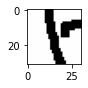

grid regions of 1 regions more=True or worst=False active for filter number: 150 :


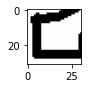

normalized regions:


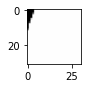

grid regions of 1 regions more=True or worst=False active for filter number: 200 :


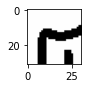

normalized regions:


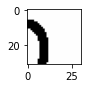

grid regions of 1 regions more=True or worst=False active for filter number: 250 :


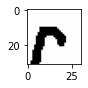

normalized regions:


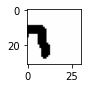

grid regions of 1 regions more=True or worst=False active for filter number: 255 :


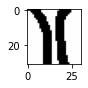

normalized regions:


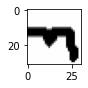

grid regions of 1 regions more=True or worst=False active for filter number: 300 :


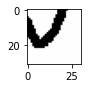

normalized regions:


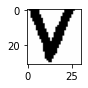

grid regions of 1 regions more=True or worst=False active for filter number: 350 :


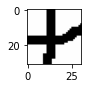

normalized regions:


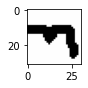

grid regions of 1 regions more=True or worst=False active for filter number: 400 :


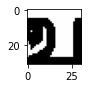

normalized regions:


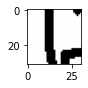

grid regions of 1 regions more=True or worst=False active for filter number: 450 :


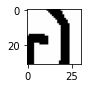

normalized regions:


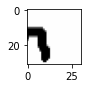

grid regions of 1 regions more=True or worst=False active for filter number: 500 :


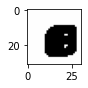

normalized regions:


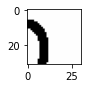

grid regions of 1 regions more=True or worst=False active for filter number: 511 :


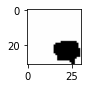

normalized regions:


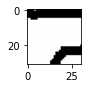

In [23]:
# parameters
list_filter_interest_layer4 = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,80,90,100,127,150,200,250,255,300,350,400,450,500,511]
best = True
worst = False
viz_mean_img = True
viz_grid = True
percentage = 0.1
nrow=14

# regions and activation of interest
regions = region_layer4_no_binary
activations = activation_layer4_no_binary
activations_normalized = activation_layer4_no_binary_normalized


selected_regions, activation_values, activation_values_normalized = get_regions_interest(regions, activations, activations_normalized, best, worst, viz_mean_img, viz_grid, percentage, list_filter_interest_layer4, nrow=nrow)

##### Binary model layer1:

Visualization filters learned for layer: layer1


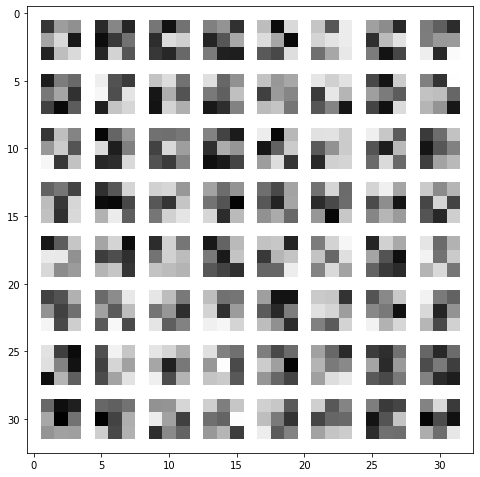

Visualization filters learned for layer: layer2


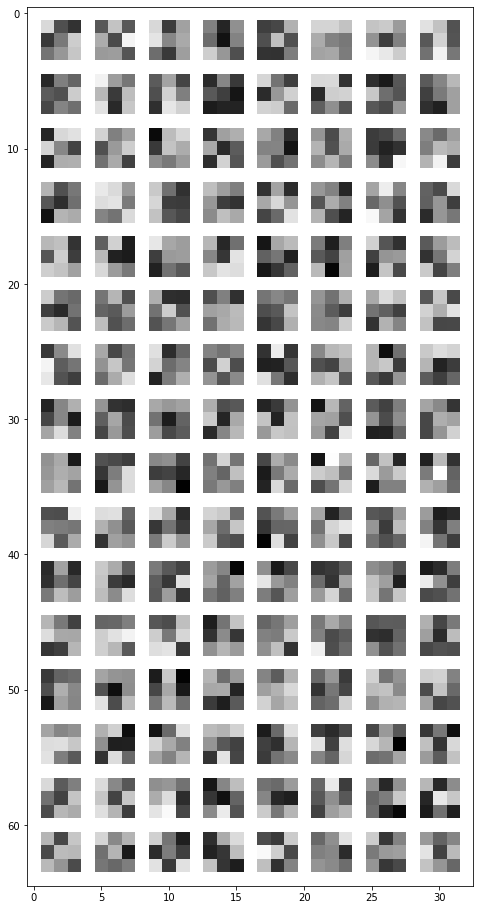

Visualization filters learned for layer: layer3


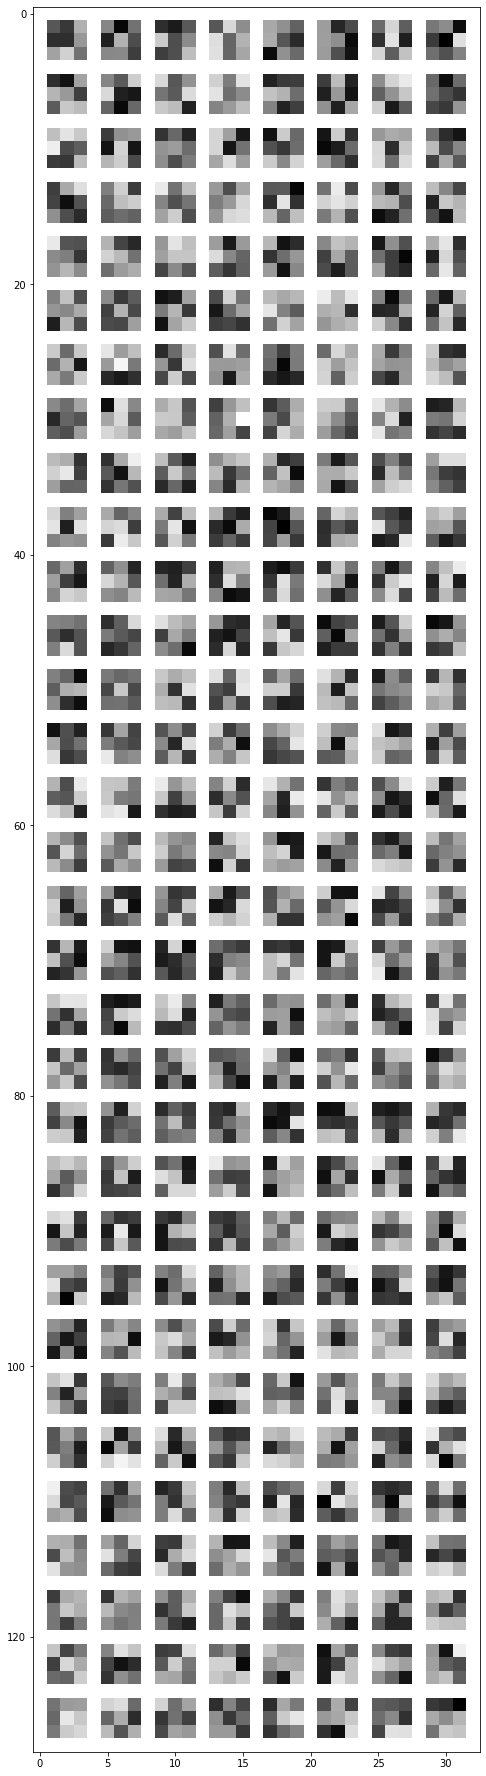

Visualization filters learned for layer: layer4


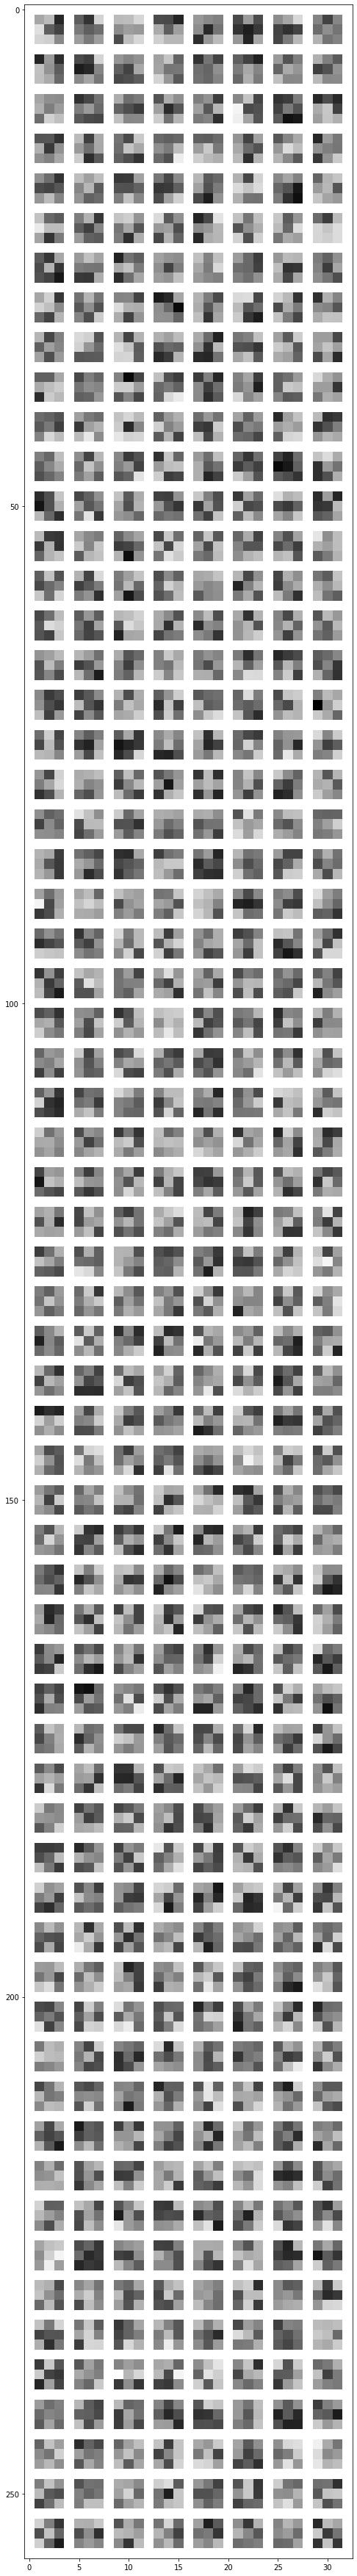

Visualization filters learned for layer: layer5


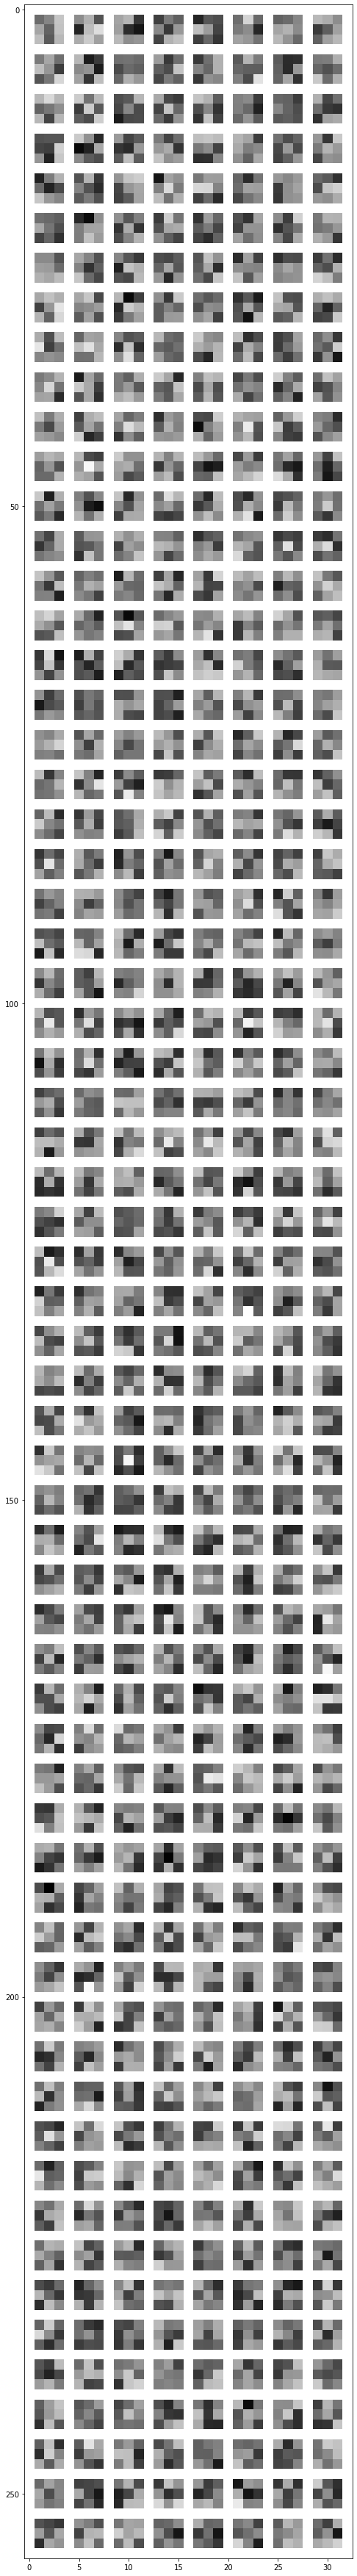

In [15]:
viz_filters(model_binary)

Interest of filters: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 63]
Consider 10% image regions = 100 images
mean image:
mean regions of 100 regions more=True or worst=False active for filter number: 0 :


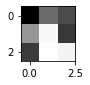

normalized region:


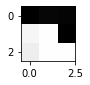

mean regions of 100 regions more=True or worst=False active for filter number: 5 :


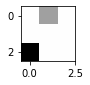

normalized region:


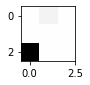

mean regions of 100 regions more=True or worst=False active for filter number: 10 :


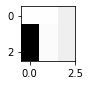

normalized region:


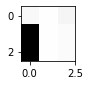

mean regions of 100 regions more=True or worst=False active for filter number: 15 :


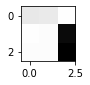

normalized region:


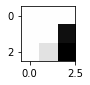

mean regions of 100 regions more=True or worst=False active for filter number: 20 :


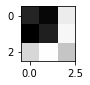

normalized region:


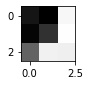

mean regions of 100 regions more=True or worst=False active for filter number: 25 :


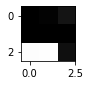

normalized region:


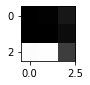

mean regions of 100 regions more=True or worst=False active for filter number: 30 :


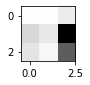

normalized region:


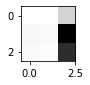

mean regions of 100 regions more=True or worst=False active for filter number: 35 :


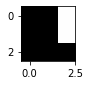

normalized region:


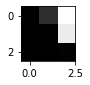

mean regions of 100 regions more=True or worst=False active for filter number: 40 :


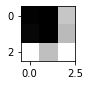

normalized region:


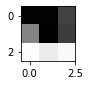

mean regions of 100 regions more=True or worst=False active for filter number: 45 :


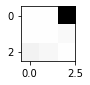

normalized region:


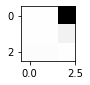

mean regions of 100 regions more=True or worst=False active for filter number: 50 :


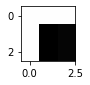

normalized region:


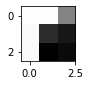

mean regions of 100 regions more=True or worst=False active for filter number: 55 :


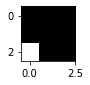

normalized region:


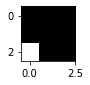

mean regions of 100 regions more=True or worst=False active for filter number: 60 :


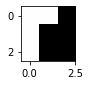

normalized region:


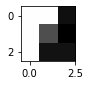

mean regions of 100 regions more=True or worst=False active for filter number: 63 :


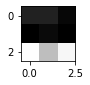

normalized region:


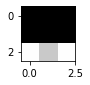

grid image
grid regions of 100 regions more=True or worst=False active for filter number: 0 :


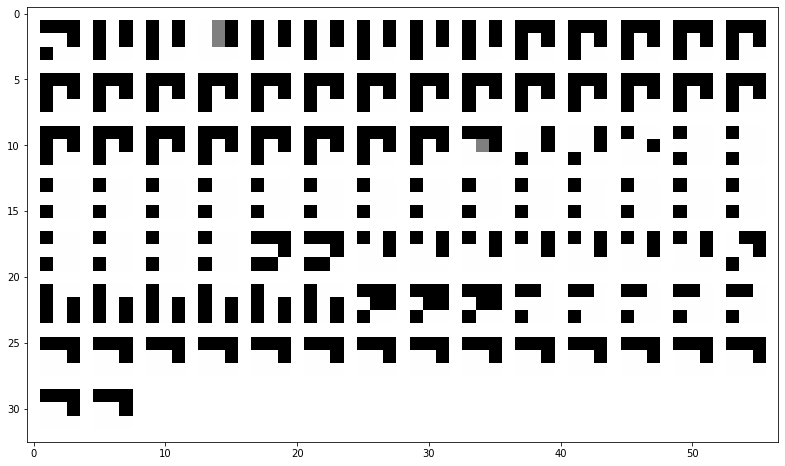

normalized regions:


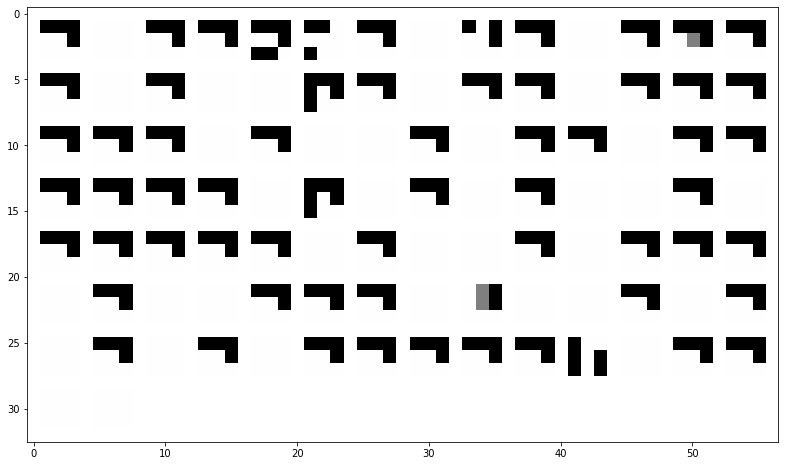

grid regions of 100 regions more=True or worst=False active for filter number: 5 :


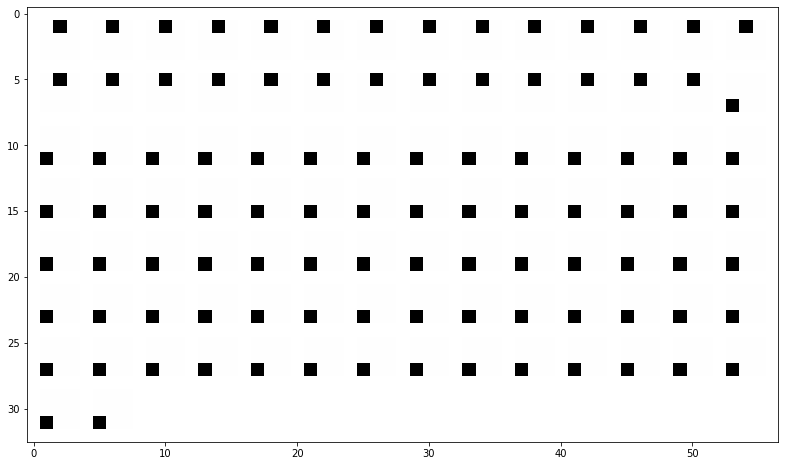

normalized regions:


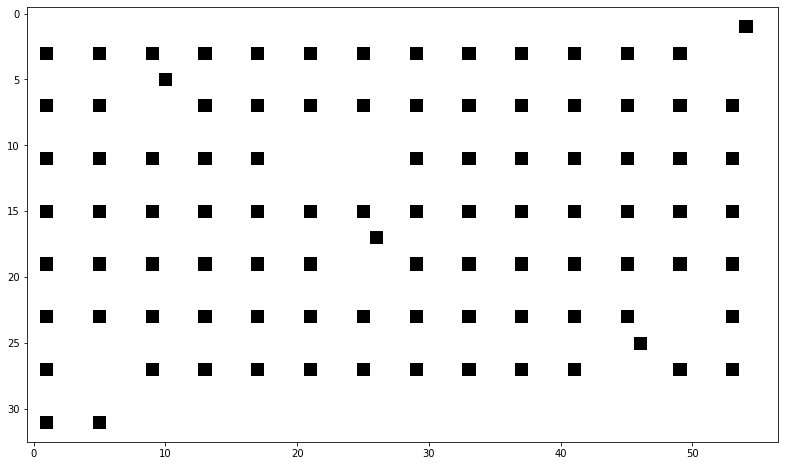

grid regions of 100 regions more=True or worst=False active for filter number: 10 :


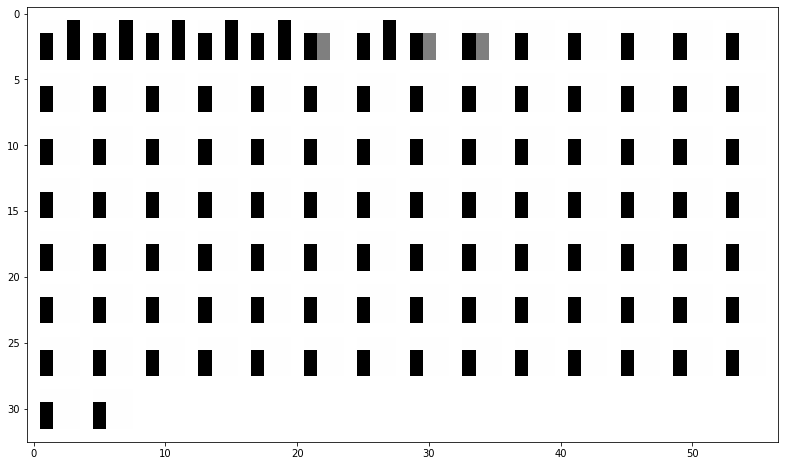

normalized regions:


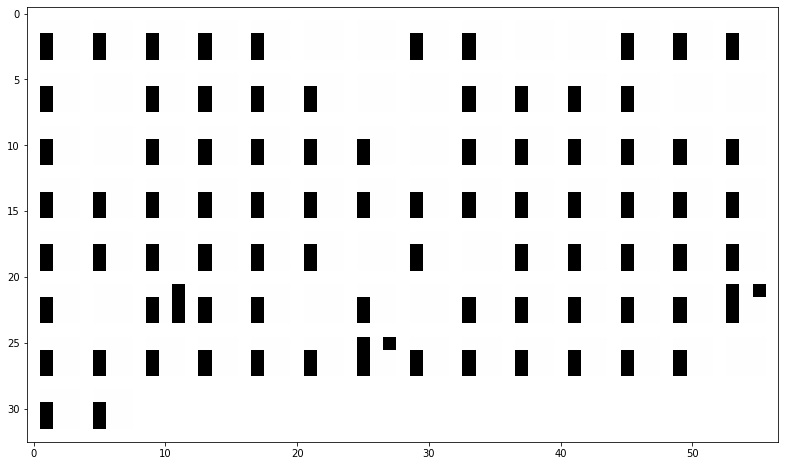

grid regions of 100 regions more=True or worst=False active for filter number: 15 :


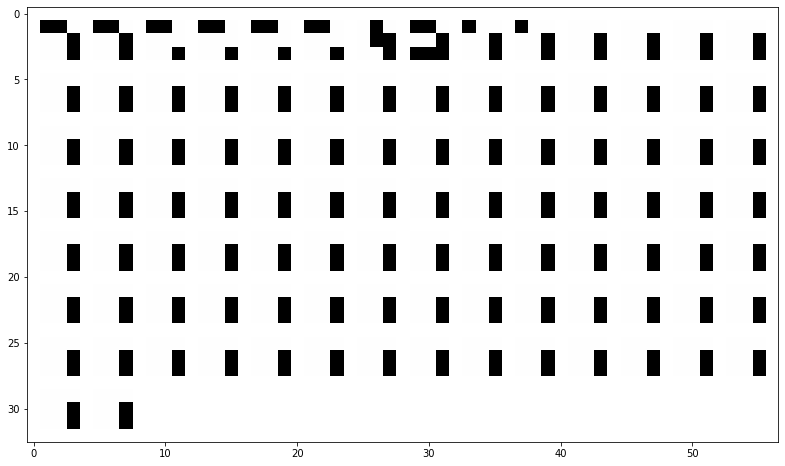

normalized regions:


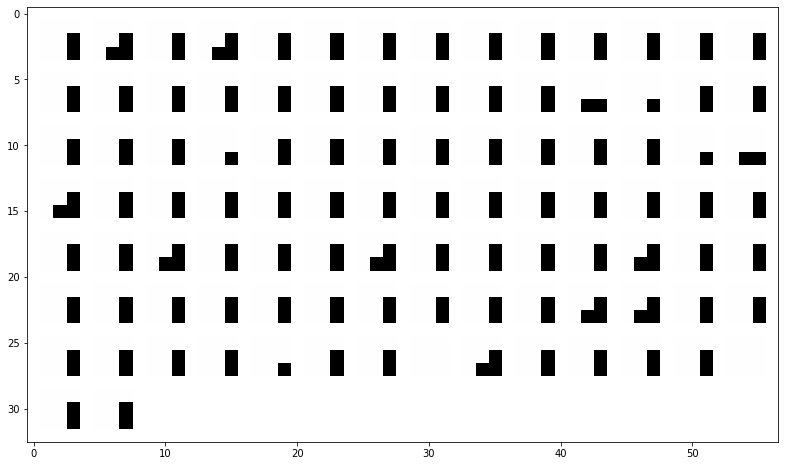

grid regions of 100 regions more=True or worst=False active for filter number: 20 :


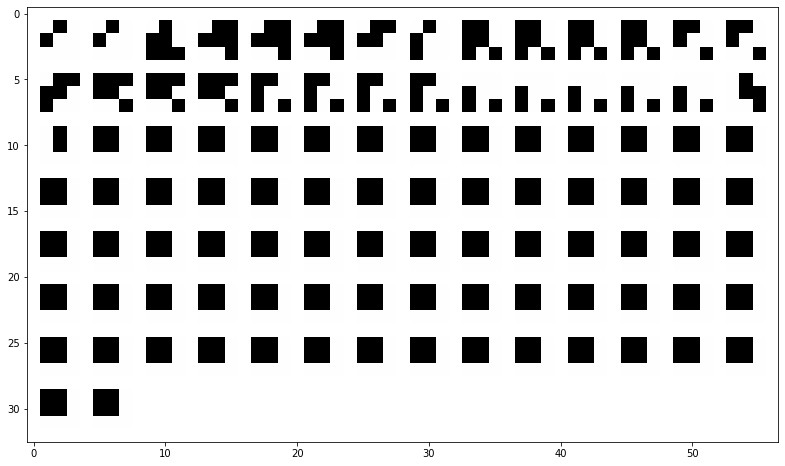

normalized regions:


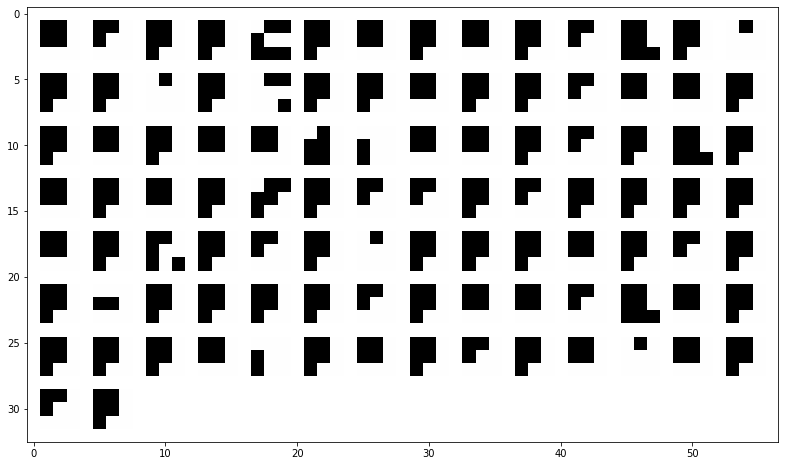

grid regions of 100 regions more=True or worst=False active for filter number: 25 :


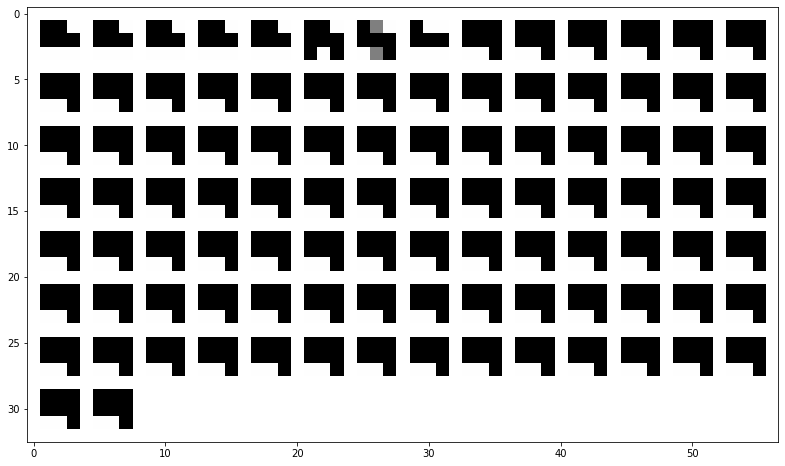

normalized regions:


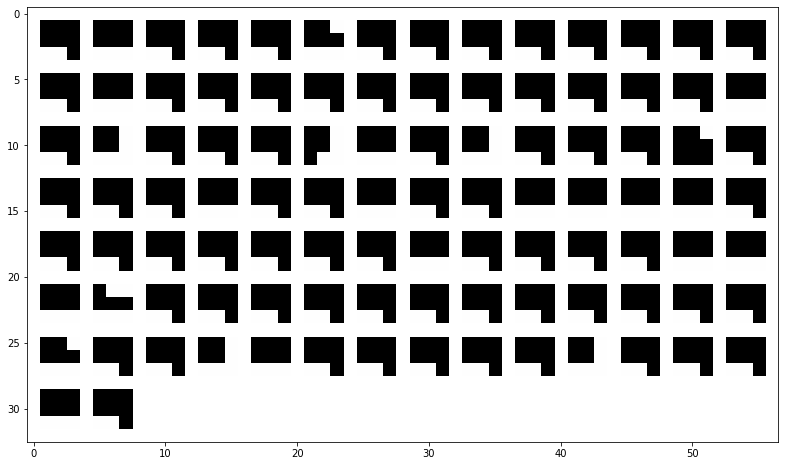

grid regions of 100 regions more=True or worst=False active for filter number: 30 :


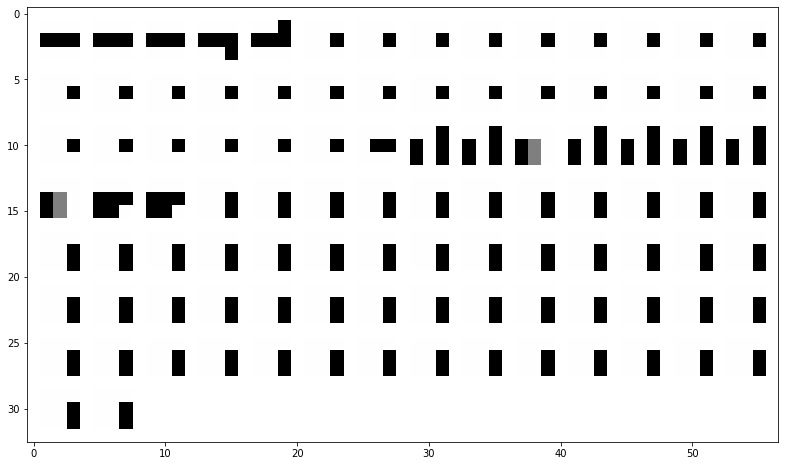

normalized regions:


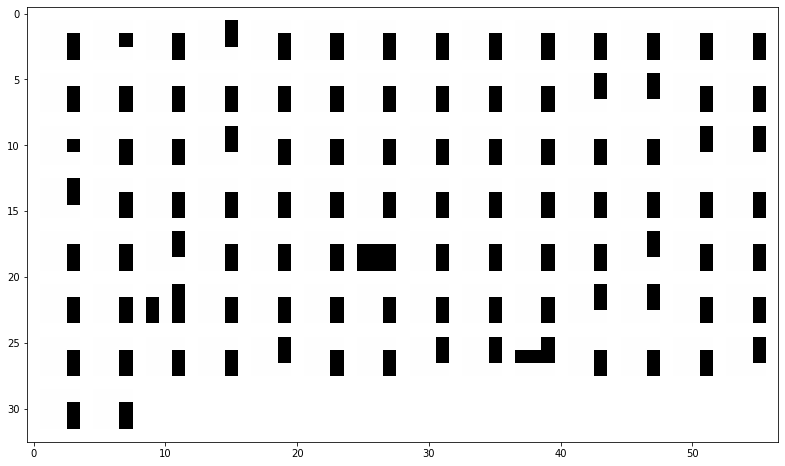

grid regions of 100 regions more=True or worst=False active for filter number: 35 :


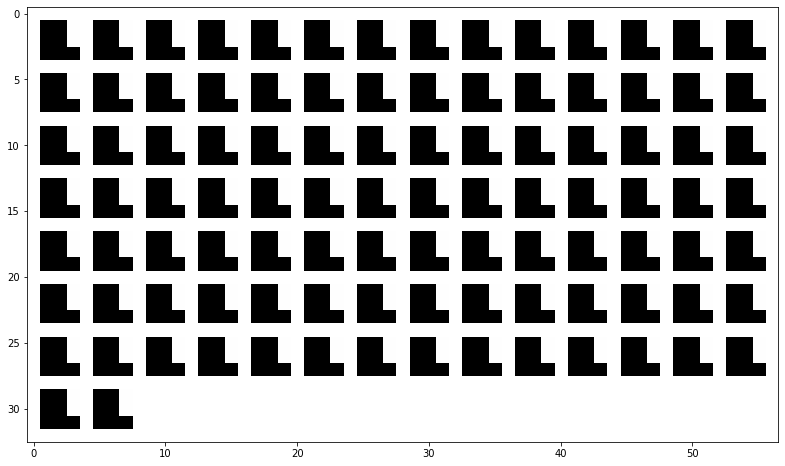

normalized regions:


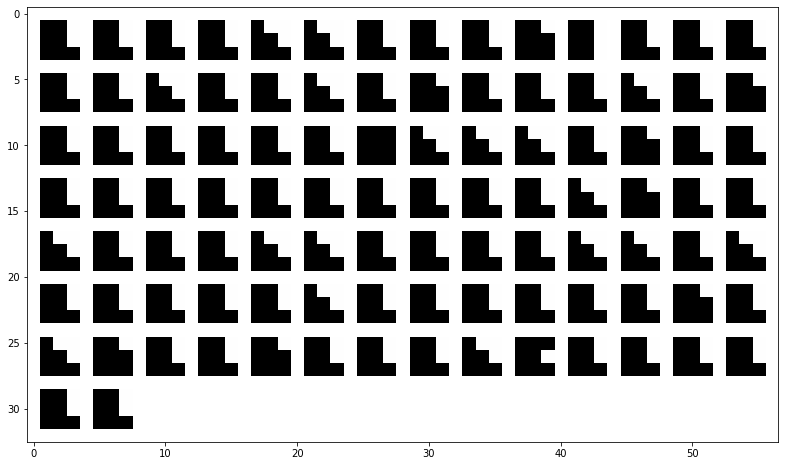

grid regions of 100 regions more=True or worst=False active for filter number: 40 :


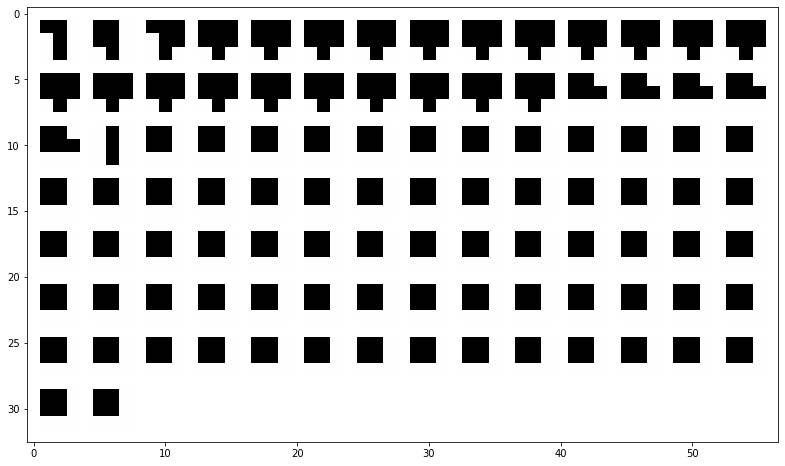

normalized regions:


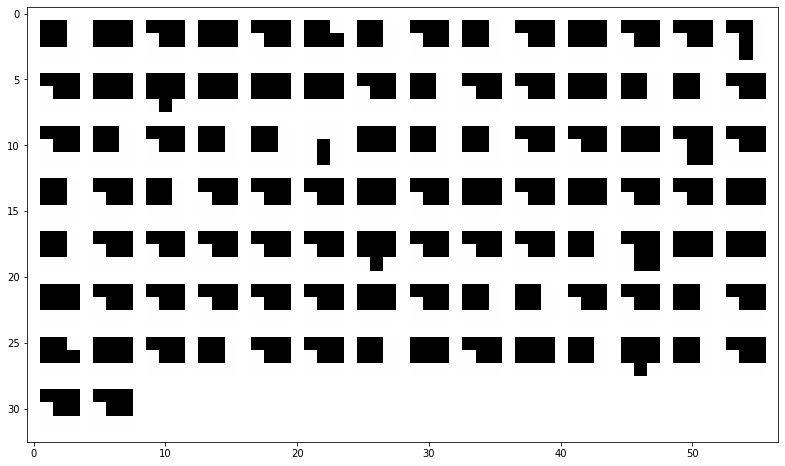

grid regions of 100 regions more=True or worst=False active for filter number: 45 :


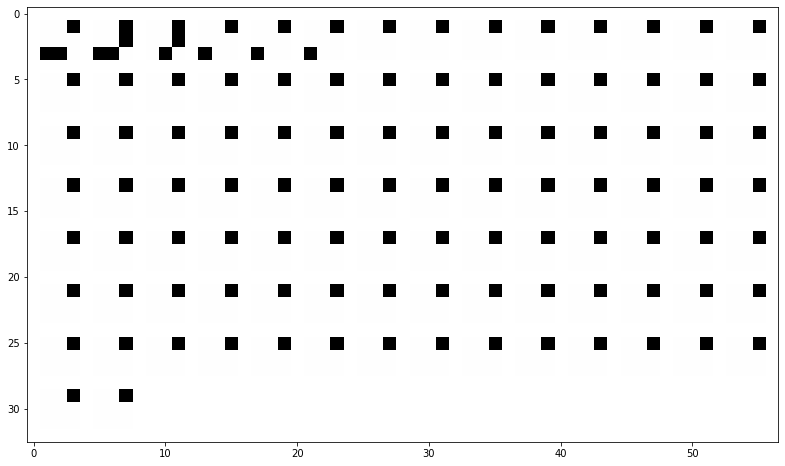

normalized regions:


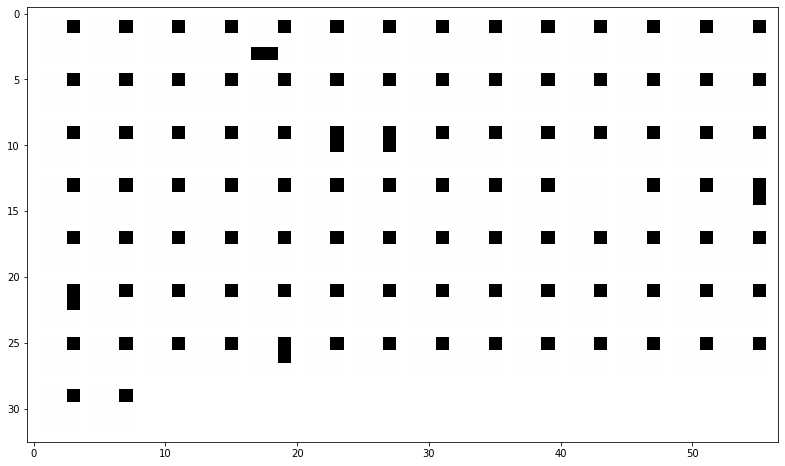

grid regions of 100 regions more=True or worst=False active for filter number: 50 :


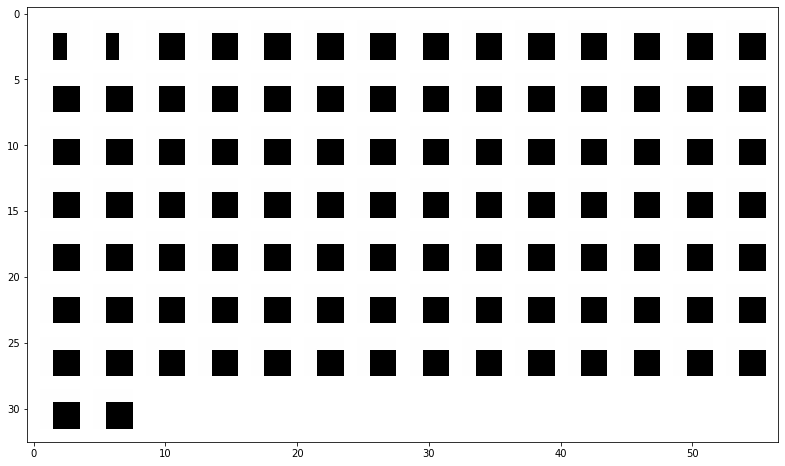

normalized regions:


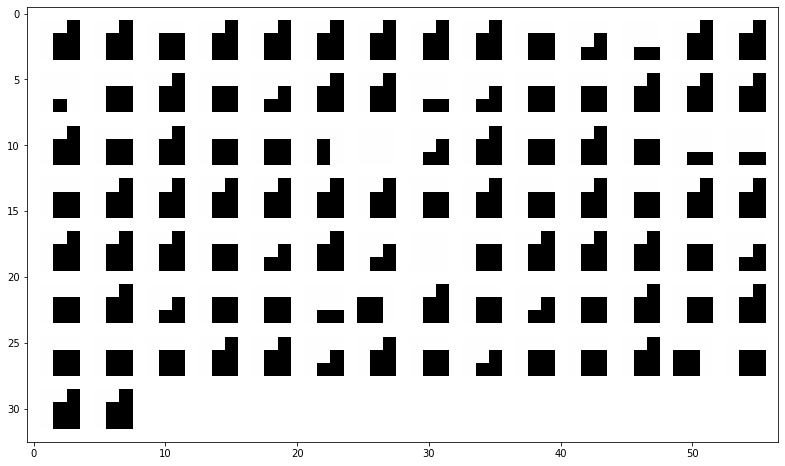

grid regions of 100 regions more=True or worst=False active for filter number: 55 :


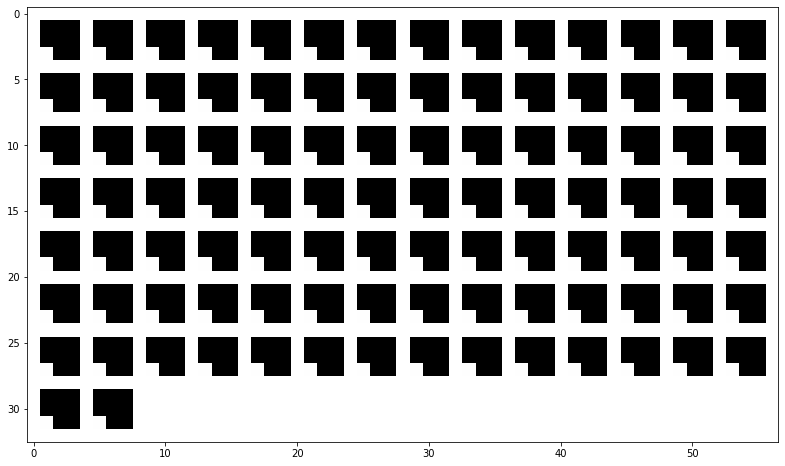

normalized regions:


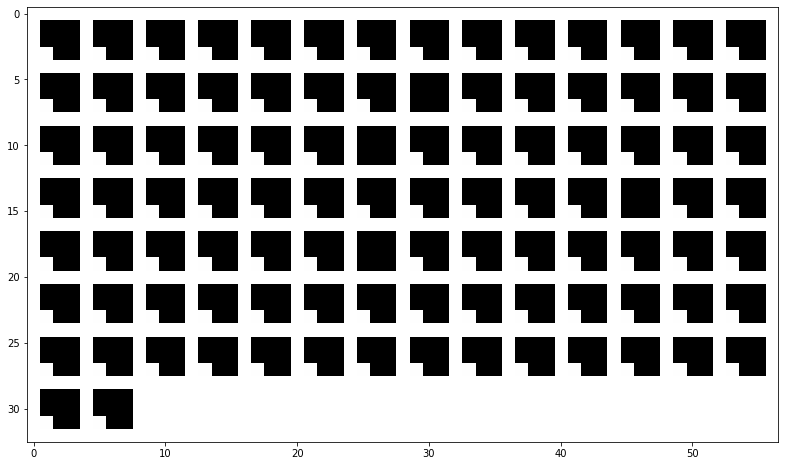

grid regions of 100 regions more=True or worst=False active for filter number: 60 :


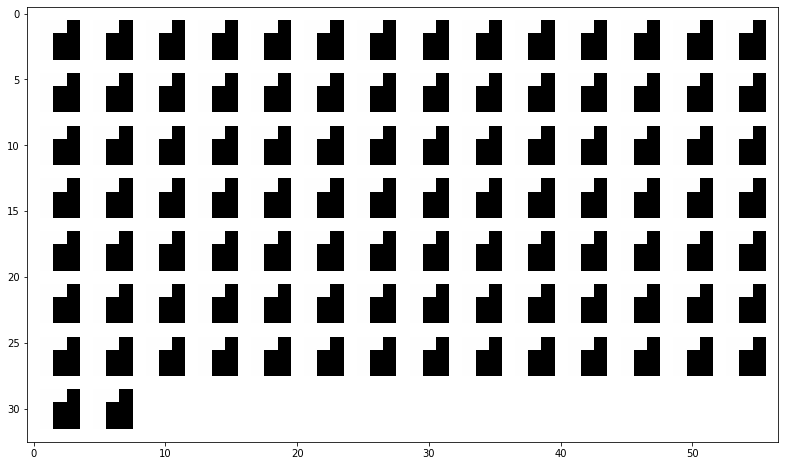

normalized regions:


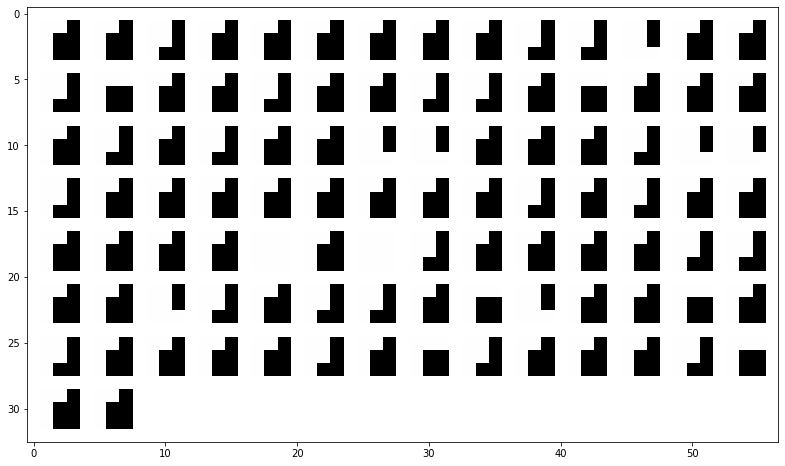

grid regions of 100 regions more=True or worst=False active for filter number: 63 :


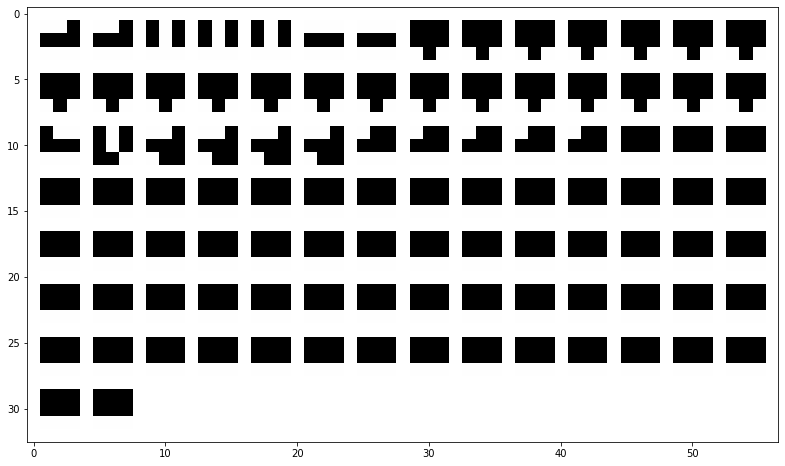

normalized regions:


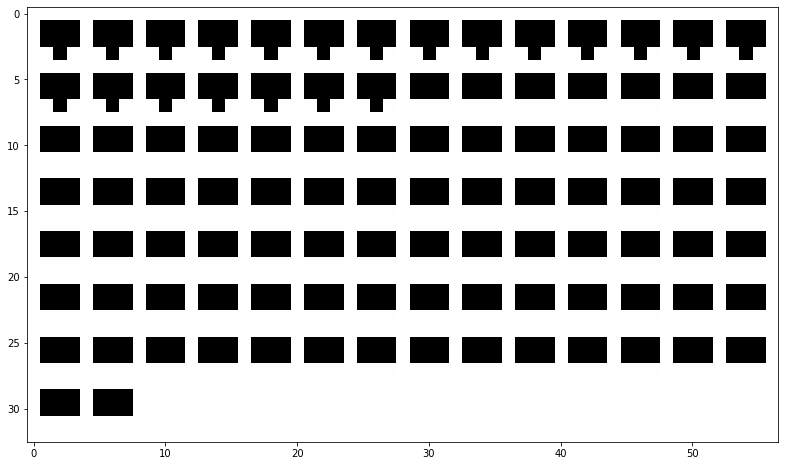

In [16]:
# parameters
list_filter_interest_layer1 = [0,5,10,15,20,25,30,35,40,45,50,55,60,63]
best = True
worst = False
viz_mean_img = True
viz_grid = True
percentage = 10
nrow=14

# regions and activation of interest
regions = region_layer1_binary
activations = activation_layer1_binary
activations_normalized = activation_layer1_binary_normalized


selected_regions, activation_values, activation_values_normalized = get_regions_interest(regions, activations, activations_normalized, best, worst, viz_mean_img, viz_grid, percentage, list_filter_interest_layer1, nrow=nrow)

##### Binary model layer2:

In [0]:
viz_filters(model_binary)

Interest of filters: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 80, 90, 100, 127]
Consider 10% image regions = 100 images
mean image:
mean regions of 100 regions more=True or worst=False active for filter number: 0 :


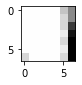

normalized region:


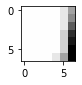

mean regions of 100 regions more=True or worst=False active for filter number: 5 :


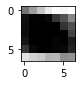

normalized region:


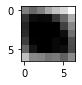

mean regions of 100 regions more=True or worst=False active for filter number: 10 :


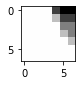

normalized region:


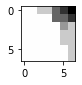

mean regions of 100 regions more=True or worst=False active for filter number: 15 :


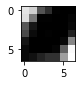

normalized region:


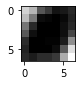

mean regions of 100 regions more=True or worst=False active for filter number: 20 :


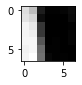

normalized region:


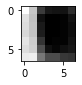

mean regions of 100 regions more=True or worst=False active for filter number: 25 :


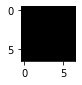

normalized region:


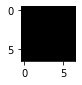

mean regions of 100 regions more=True or worst=False active for filter number: 30 :


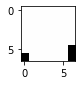

normalized region:


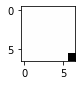

mean regions of 100 regions more=True or worst=False active for filter number: 35 :


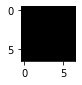

normalized region:


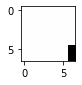

mean regions of 100 regions more=True or worst=False active for filter number: 40 :


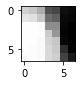

normalized region:


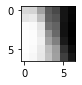

mean regions of 100 regions more=True or worst=False active for filter number: 45 :


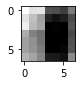

normalized region:


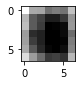

mean regions of 100 regions more=True or worst=False active for filter number: 50 :


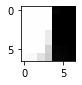

normalized region:


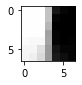

mean regions of 100 regions more=True or worst=False active for filter number: 55 :


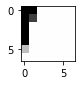

normalized region:


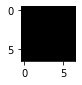

mean regions of 100 regions more=True or worst=False active for filter number: 60 :


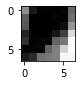

normalized region:


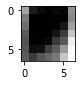

mean regions of 100 regions more=True or worst=False active for filter number: 65 :


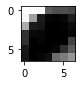

normalized region:


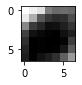

mean regions of 100 regions more=True or worst=False active for filter number: 70 :


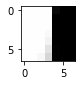

normalized region:


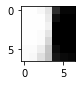

mean regions of 100 regions more=True or worst=False active for filter number: 80 :


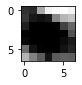

normalized region:


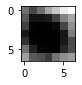

mean regions of 100 regions more=True or worst=False active for filter number: 90 :


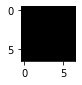

normalized region:


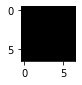

mean regions of 100 regions more=True or worst=False active for filter number: 100 :


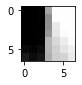

normalized region:


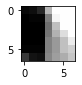

mean regions of 100 regions more=True or worst=False active for filter number: 127 :


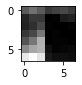

normalized region:


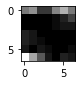

grid image
grid regions of 100 regions more=True or worst=False active for filter number: 0 :


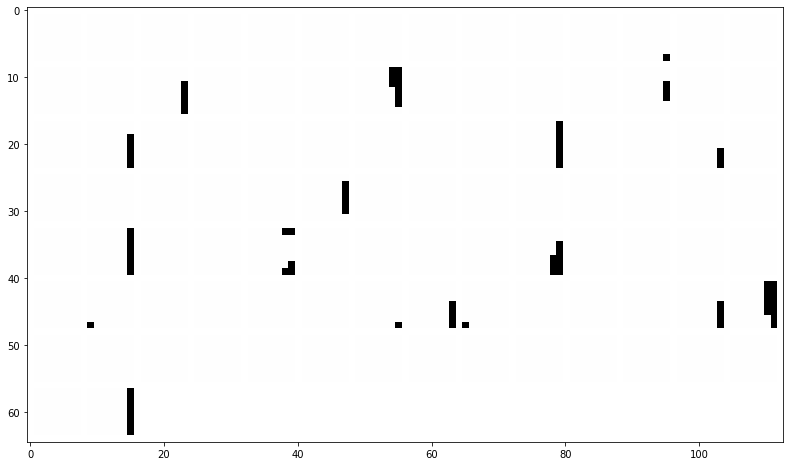

normalized regions:


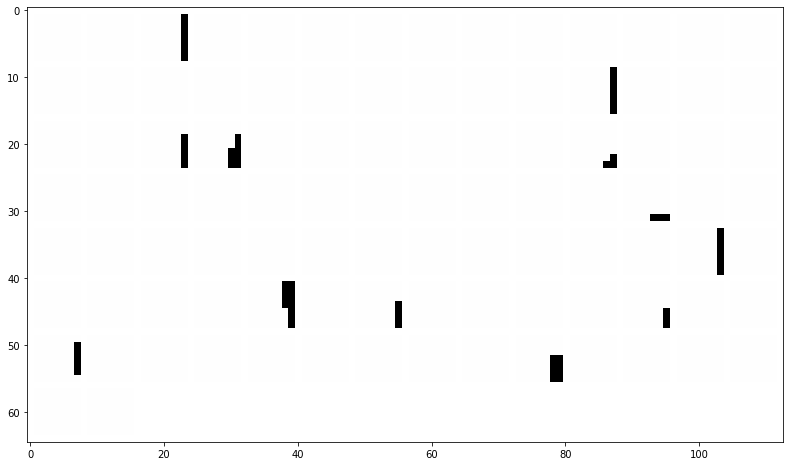

grid regions of 100 regions more=True or worst=False active for filter number: 5 :


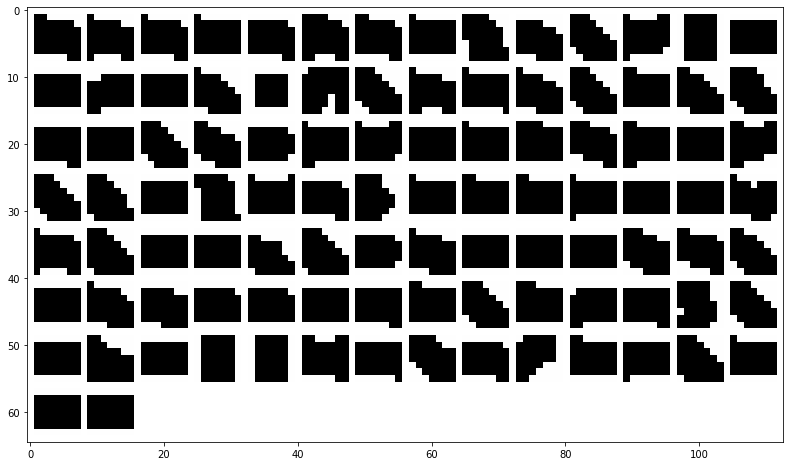

normalized regions:


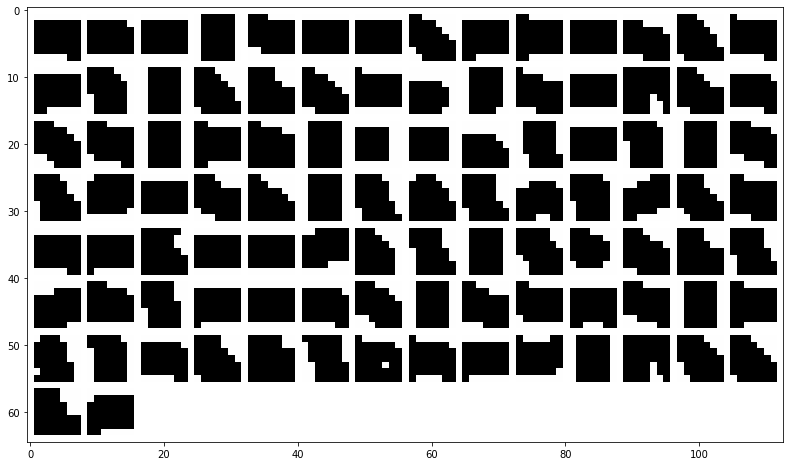

grid regions of 100 regions more=True or worst=False active for filter number: 10 :


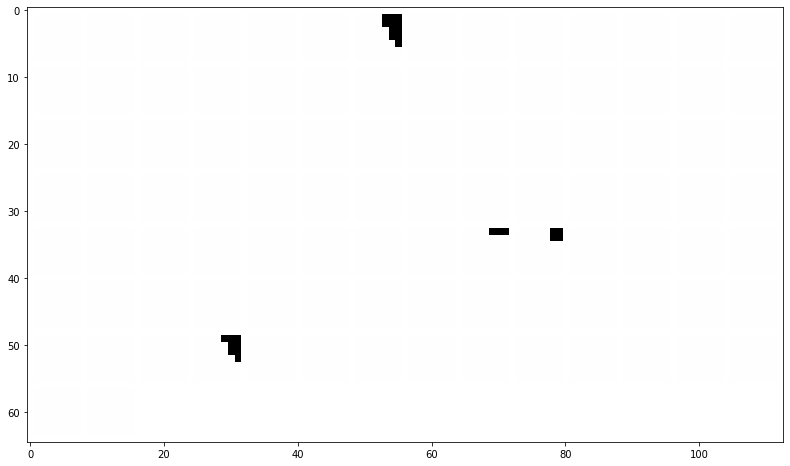

normalized regions:


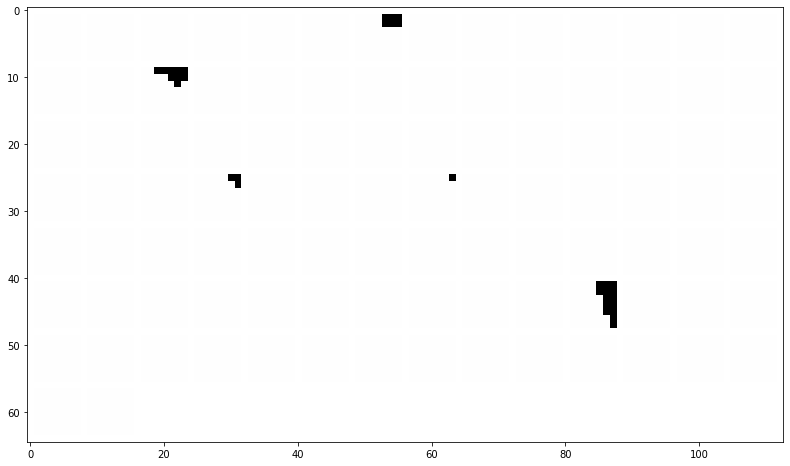

grid regions of 100 regions more=True or worst=False active for filter number: 15 :


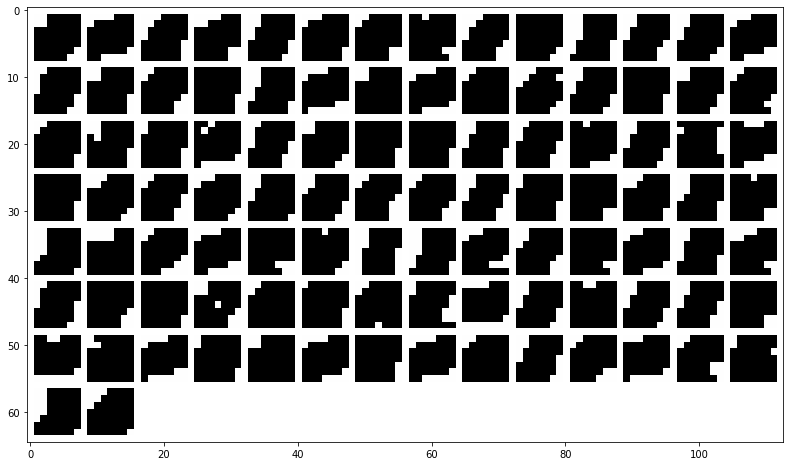

normalized regions:


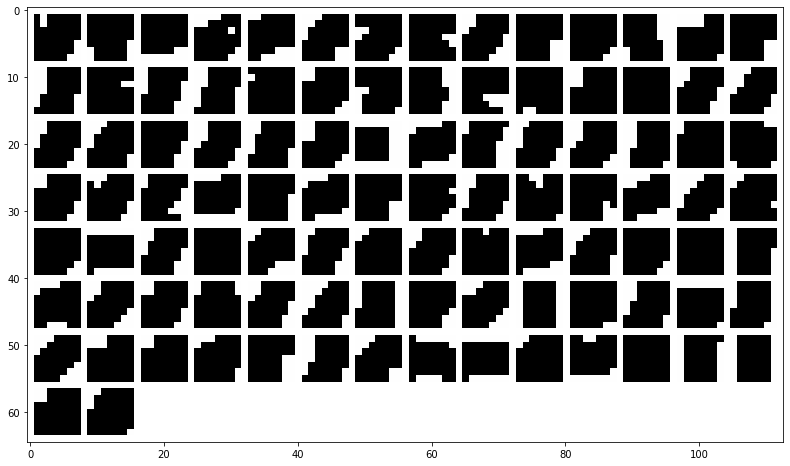

grid regions of 100 regions more=True or worst=False active for filter number: 20 :


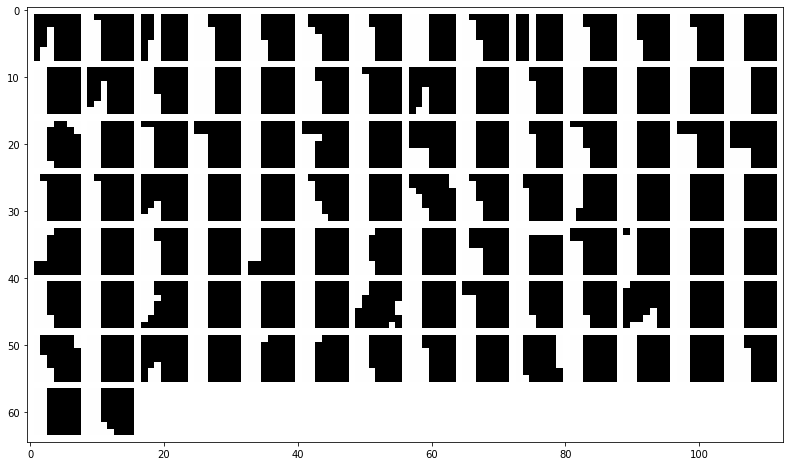

normalized regions:


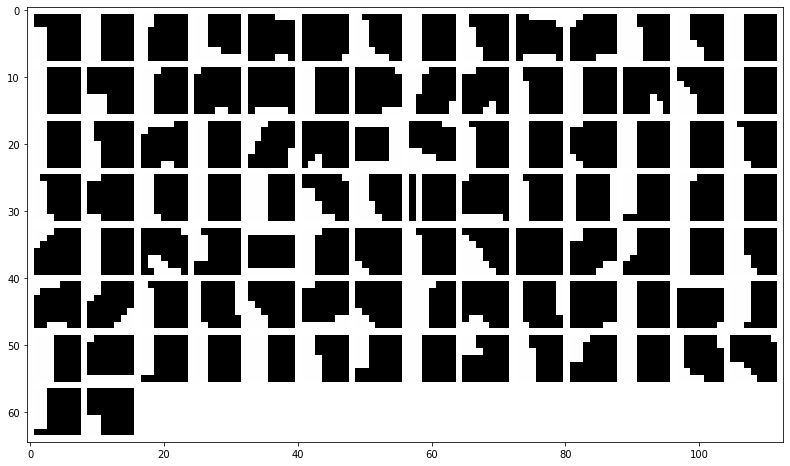

grid regions of 100 regions more=True or worst=False active for filter number: 25 :


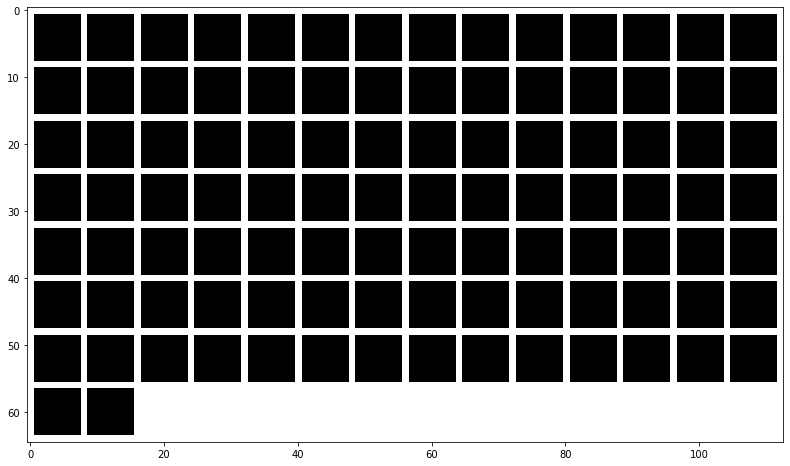

normalized regions:


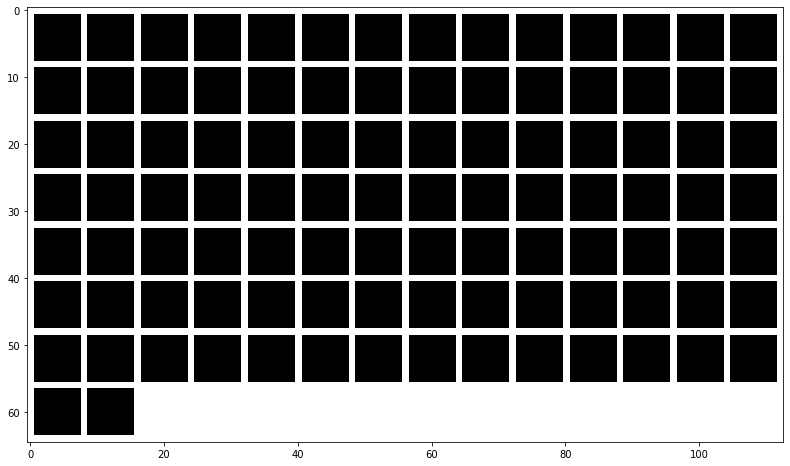

grid regions of 100 regions more=True or worst=False active for filter number: 30 :


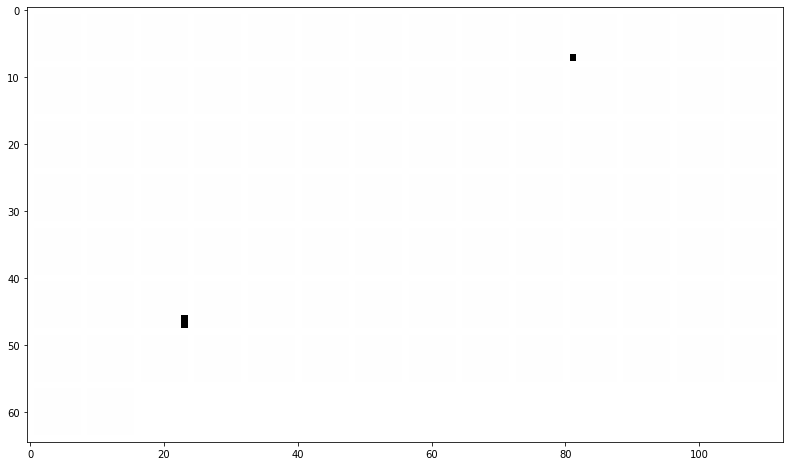

normalized regions:


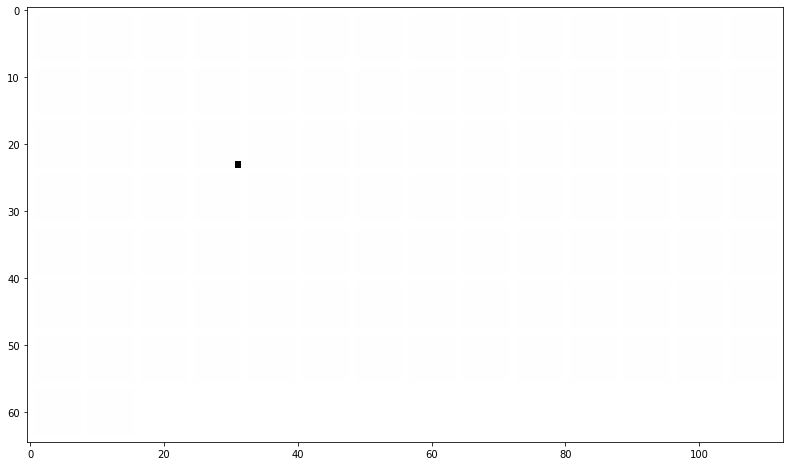

grid regions of 100 regions more=True or worst=False active for filter number: 35 :


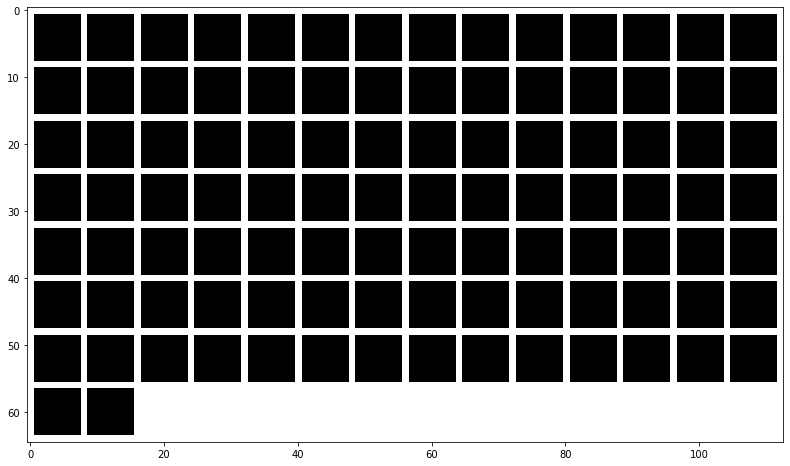

normalized regions:


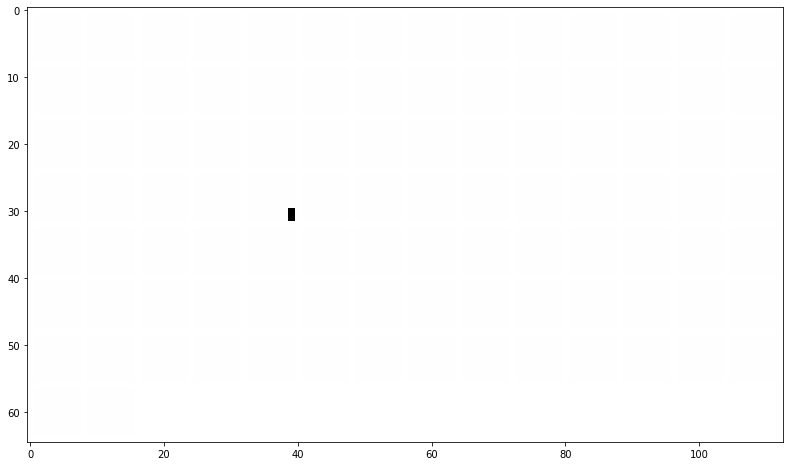

grid regions of 100 regions more=True or worst=False active for filter number: 40 :


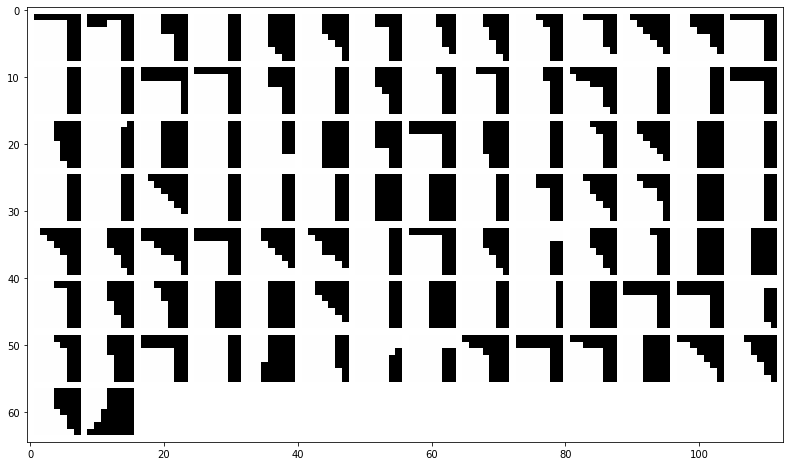

normalized regions:


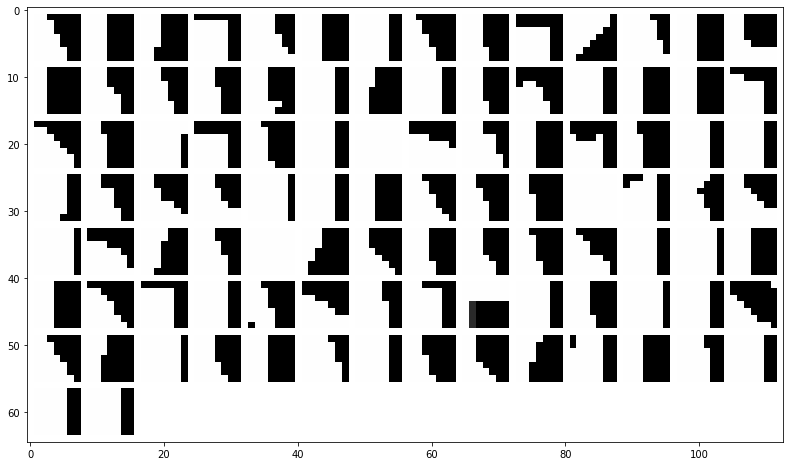

grid regions of 100 regions more=True or worst=False active for filter number: 45 :


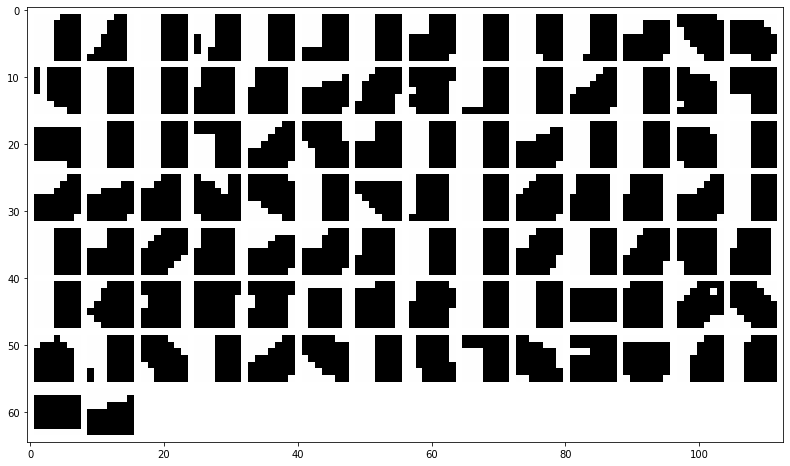

normalized regions:


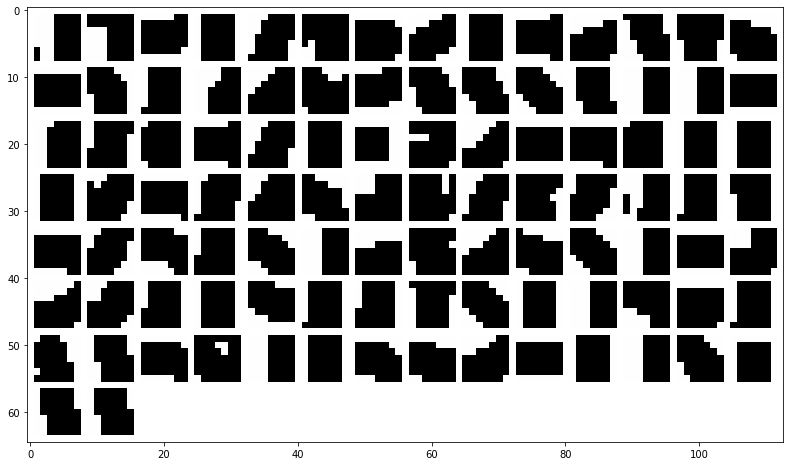

grid regions of 100 regions more=True or worst=False active for filter number: 50 :


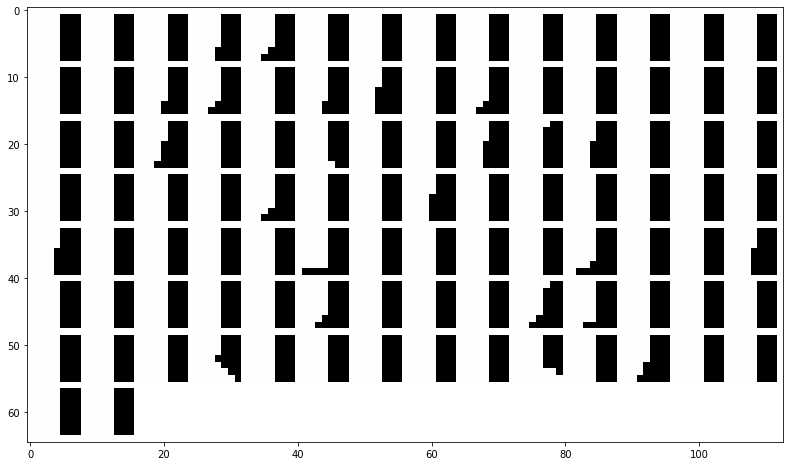

normalized regions:


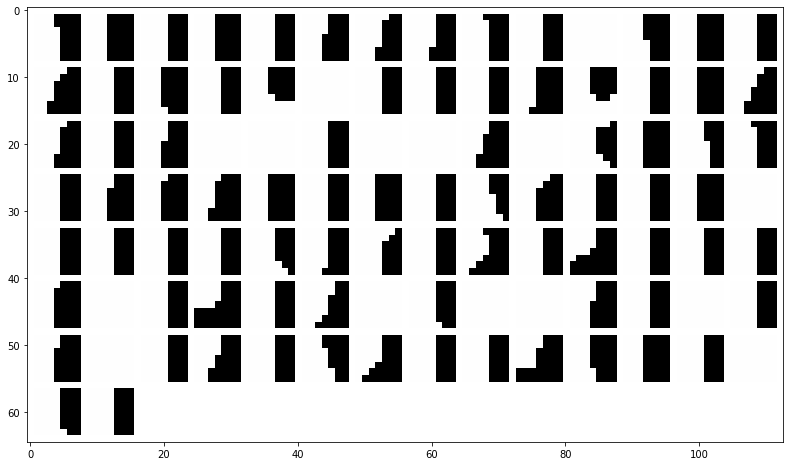

grid regions of 100 regions more=True or worst=False active for filter number: 55 :


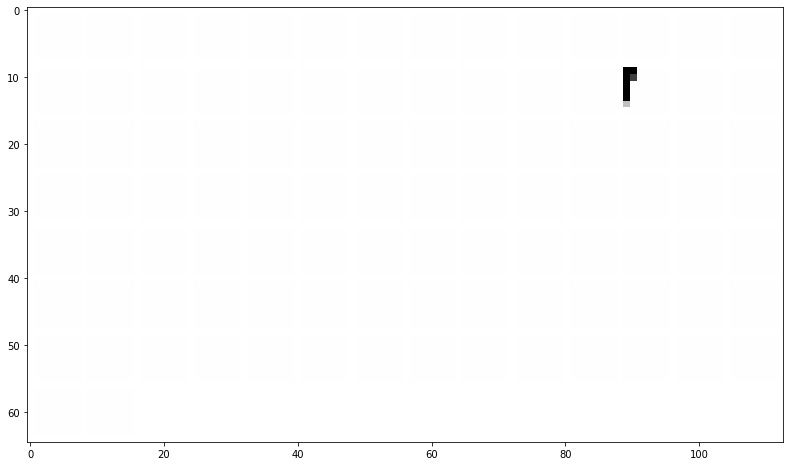

normalized regions:


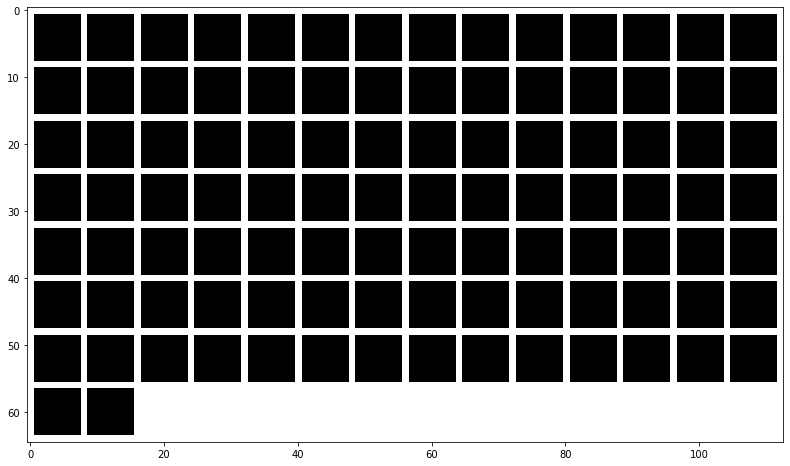

grid regions of 100 regions more=True or worst=False active for filter number: 60 :


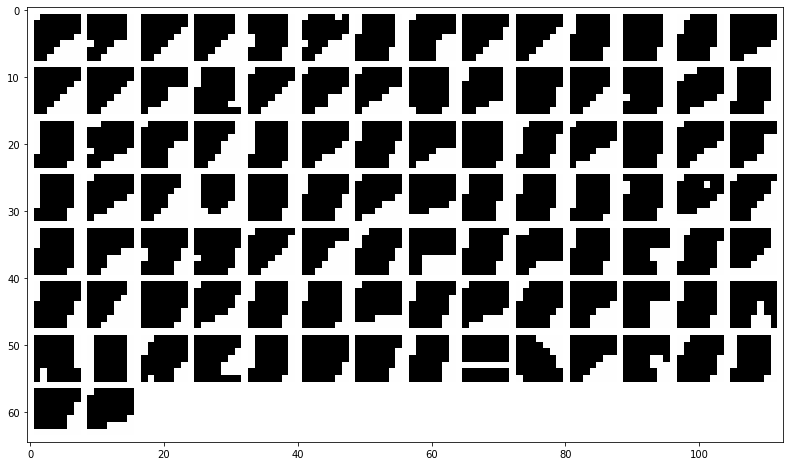

normalized regions:


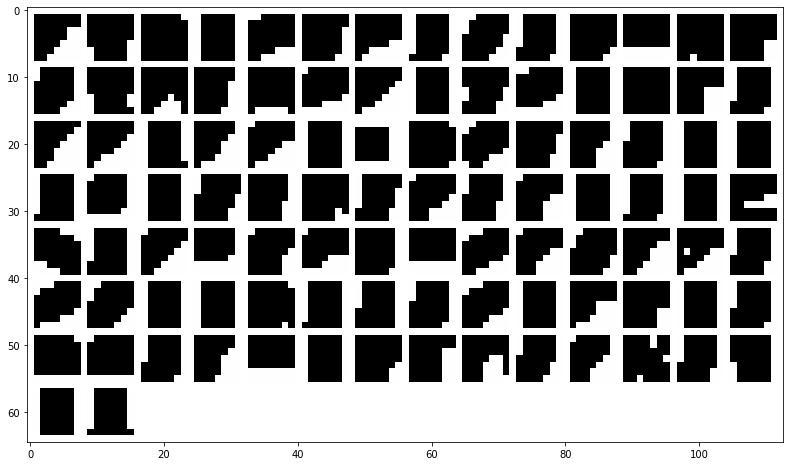

grid regions of 100 regions more=True or worst=False active for filter number: 65 :


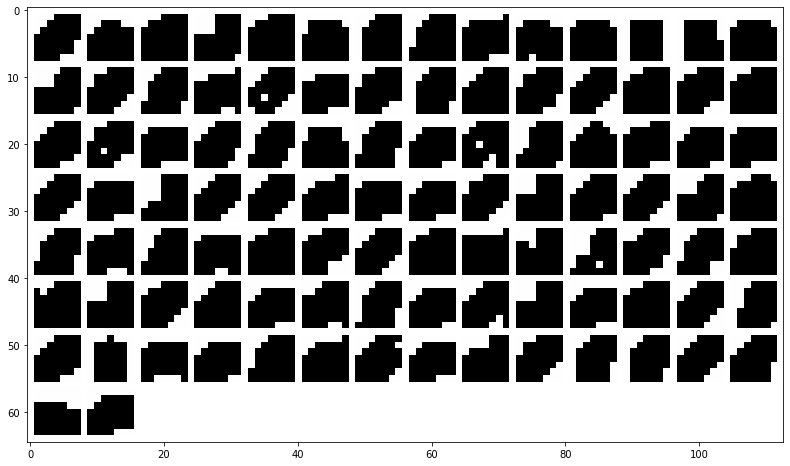

normalized regions:


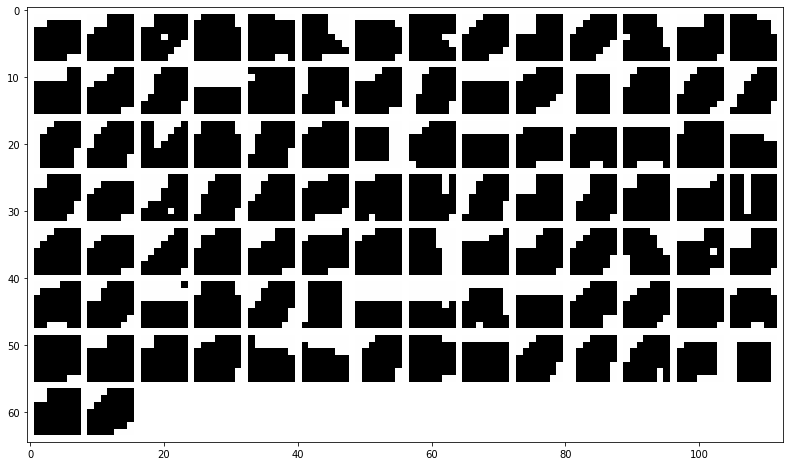

grid regions of 100 regions more=True or worst=False active for filter number: 70 :


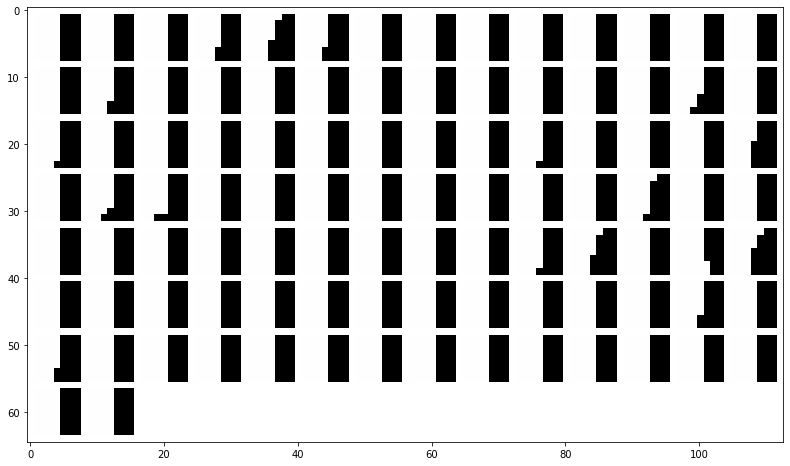

normalized regions:


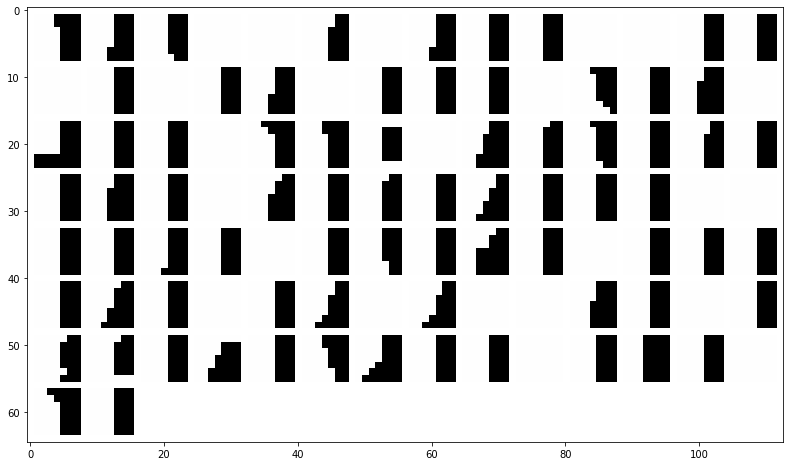

grid regions of 100 regions more=True or worst=False active for filter number: 80 :


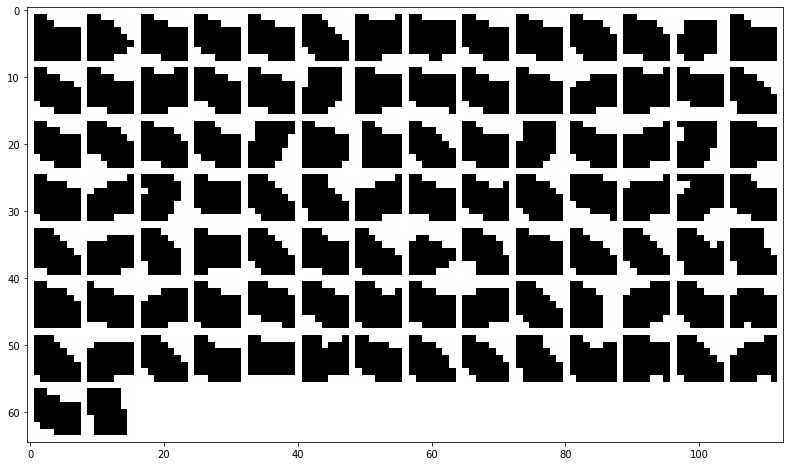

normalized regions:


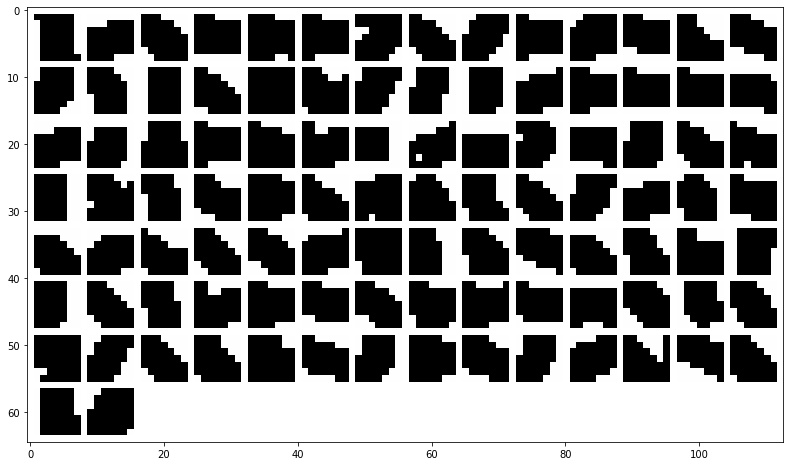

grid regions of 100 regions more=True or worst=False active for filter number: 90 :


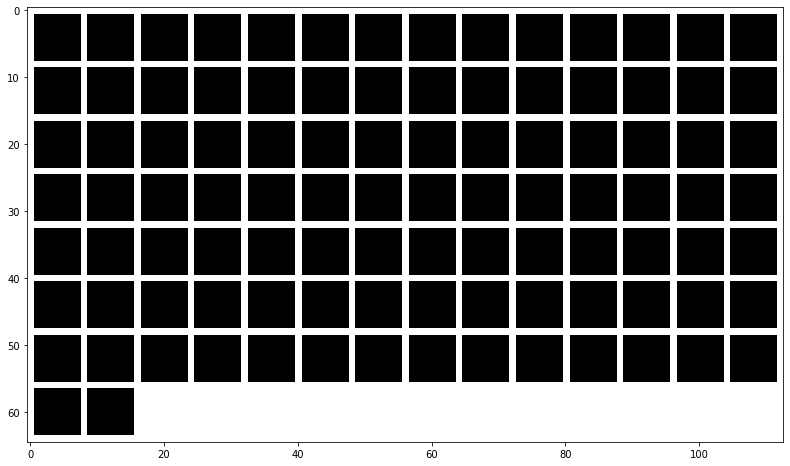

normalized regions:


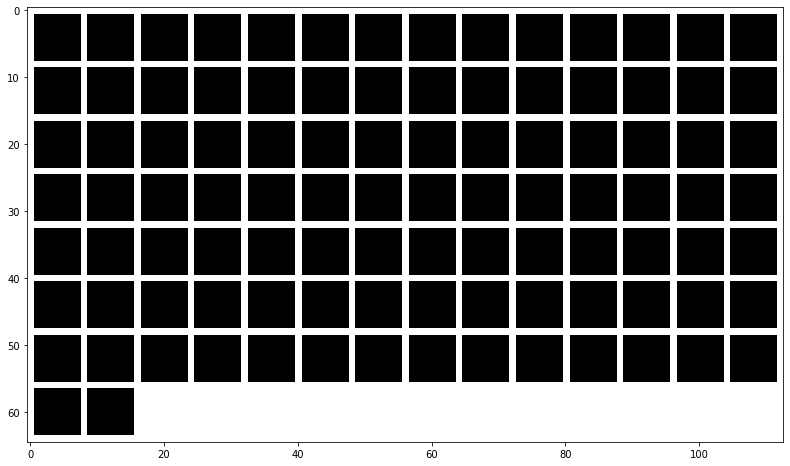

grid regions of 100 regions more=True or worst=False active for filter number: 100 :


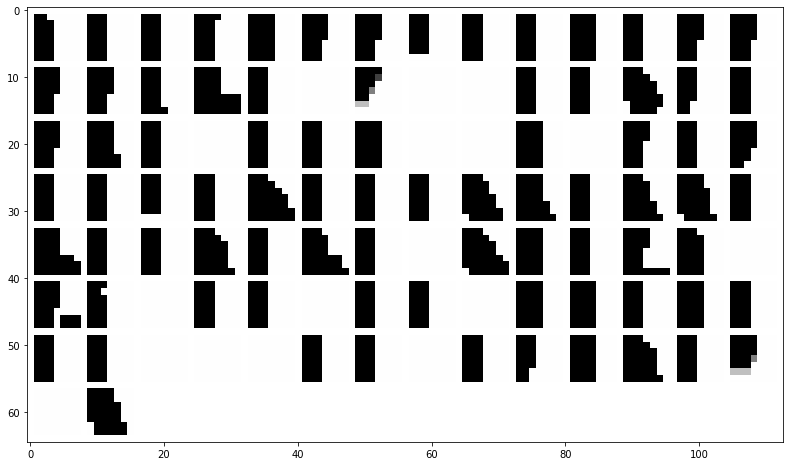

normalized regions:


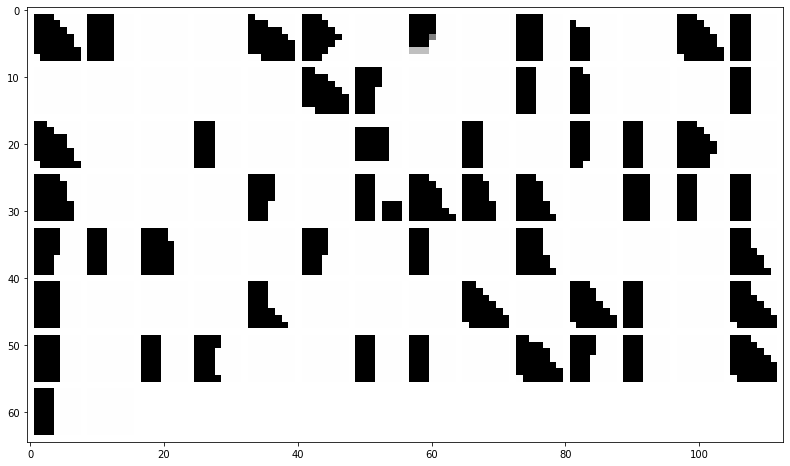

grid regions of 100 regions more=True or worst=False active for filter number: 127 :


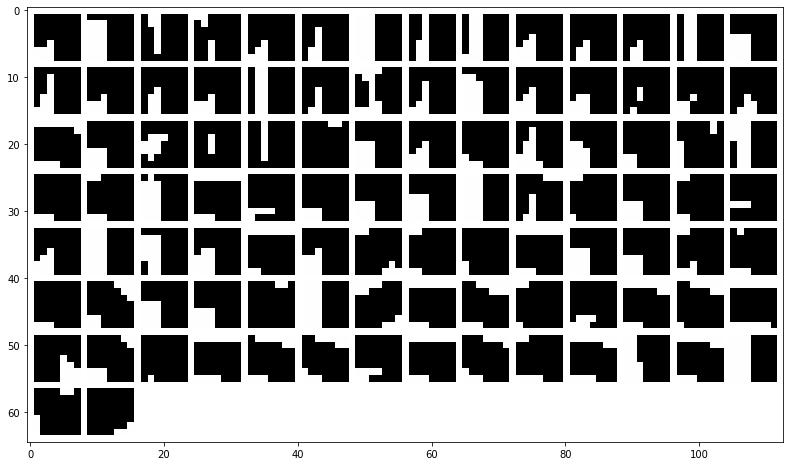

normalized regions:


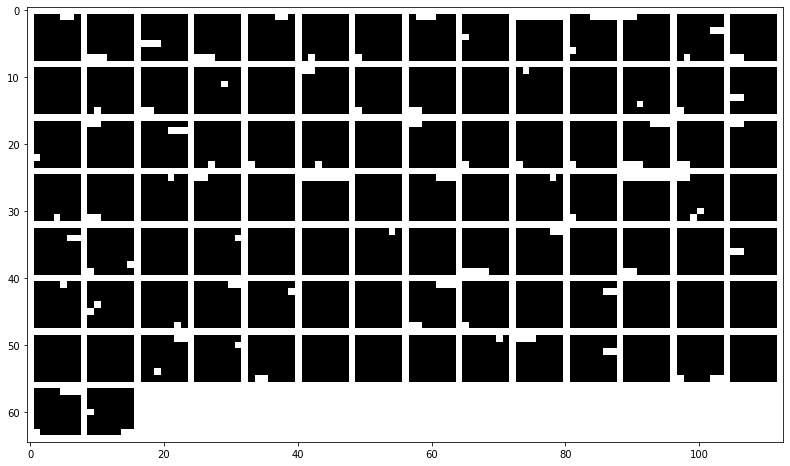

In [17]:
# parameters
list_filter_interest_layer2 = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,80,90,100,127]
best = True
worst = False
viz_mean_img = True
viz_grid = True
percentage = 10
nrow=14

# regions and activation of interest
regions = region_layer2_binary
activations = activation_layer2_binary
activations_normalized = activation_layer2_binary_normalized


selected_regions, activation_values, activation_values_normalized = get_regions_interest(regions, activations, activations_normalized, best, worst, viz_mean_img, viz_grid, percentage, list_filter_interest_layer2, nrow=nrow)

##### Binary model layer3:

In [0]:
viz_filters(model_binary)

Interest of filters: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 80, 90, 100, 127, 150, 200, 250, 255]
Consider 10% image regions = 100 images
mean image:
mean regions of 100 regions more=True or worst=False active for filter number: 0 :


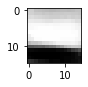

normalized region:


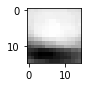

mean regions of 100 regions more=True or worst=False active for filter number: 5 :


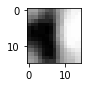

normalized region:


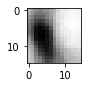

mean regions of 100 regions more=True or worst=False active for filter number: 10 :


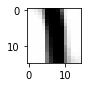

normalized region:


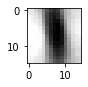

mean regions of 100 regions more=True or worst=False active for filter number: 15 :


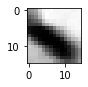

normalized region:


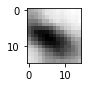

mean regions of 100 regions more=True or worst=False active for filter number: 20 :


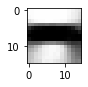

normalized region:


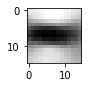

mean regions of 100 regions more=True or worst=False active for filter number: 25 :


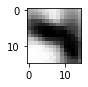

normalized region:


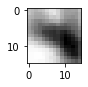

mean regions of 100 regions more=True or worst=False active for filter number: 30 :


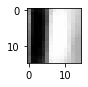

normalized region:


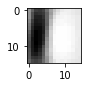

mean regions of 100 regions more=True or worst=False active for filter number: 35 :


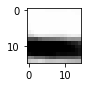

normalized region:


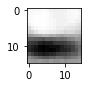

mean regions of 100 regions more=True or worst=False active for filter number: 40 :


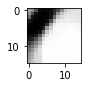

normalized region:


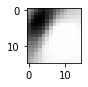

mean regions of 100 regions more=True or worst=False active for filter number: 45 :


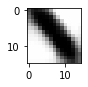

normalized region:


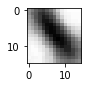

mean regions of 100 regions more=True or worst=False active for filter number: 50 :


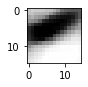

normalized region:


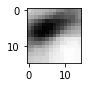

mean regions of 100 regions more=True or worst=False active for filter number: 55 :


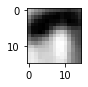

normalized region:


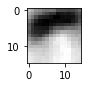

mean regions of 100 regions more=True or worst=False active for filter number: 60 :


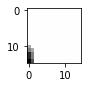

normalized region:


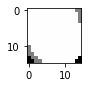

mean regions of 100 regions more=True or worst=False active for filter number: 65 :


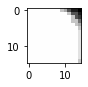

normalized region:


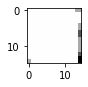

mean regions of 100 regions more=True or worst=False active for filter number: 70 :


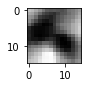

normalized region:


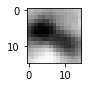

mean regions of 100 regions more=True or worst=False active for filter number: 80 :


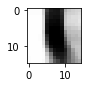

normalized region:


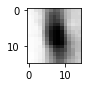

mean regions of 100 regions more=True or worst=False active for filter number: 90 :


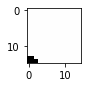

normalized region:


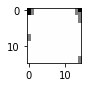

mean regions of 100 regions more=True or worst=False active for filter number: 100 :


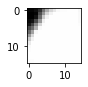

normalized region:


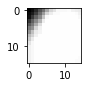

mean regions of 100 regions more=True or worst=False active for filter number: 127 :


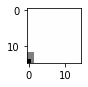

normalized region:


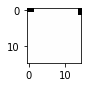

mean regions of 100 regions more=True or worst=False active for filter number: 150 :


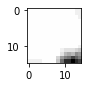

normalized region:


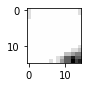

mean regions of 100 regions more=True or worst=False active for filter number: 200 :


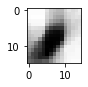

normalized region:


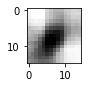

mean regions of 100 regions more=True or worst=False active for filter number: 250 :


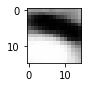

normalized region:


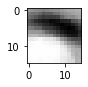

mean regions of 100 regions more=True or worst=False active for filter number: 255 :


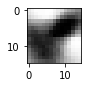

normalized region:


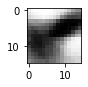

grid image
grid regions of 100 regions more=True or worst=False active for filter number: 0 :


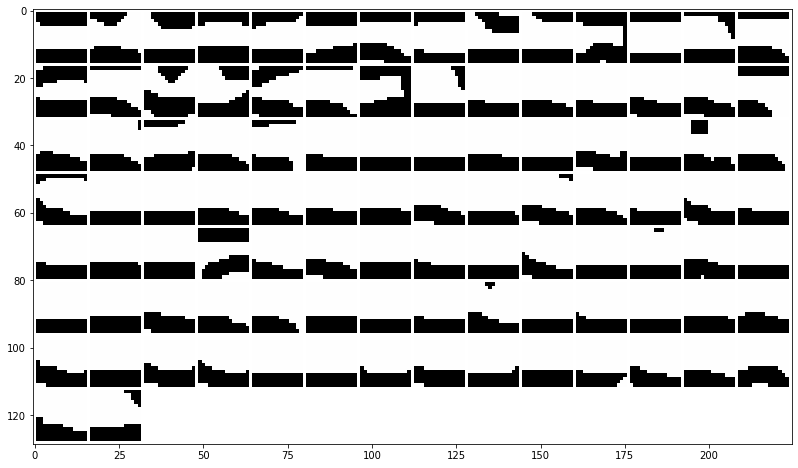

normalized regions:


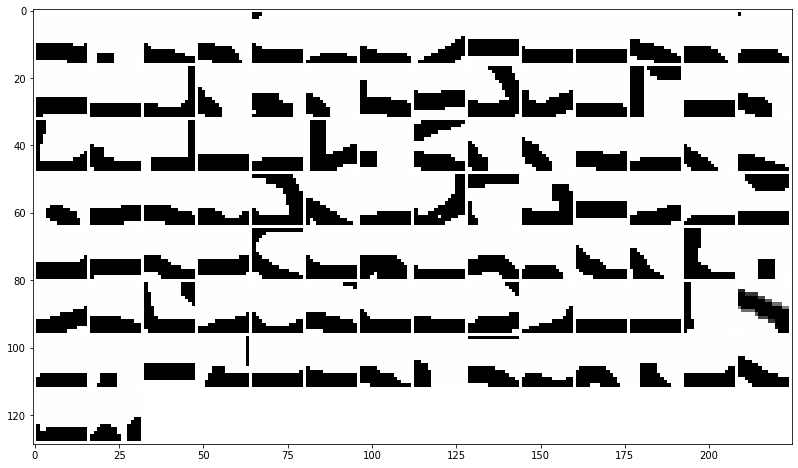

grid regions of 100 regions more=True or worst=False active for filter number: 5 :


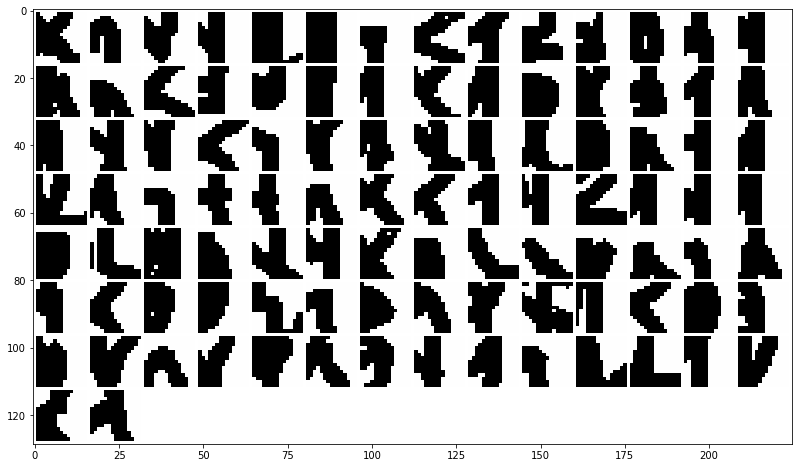

normalized regions:


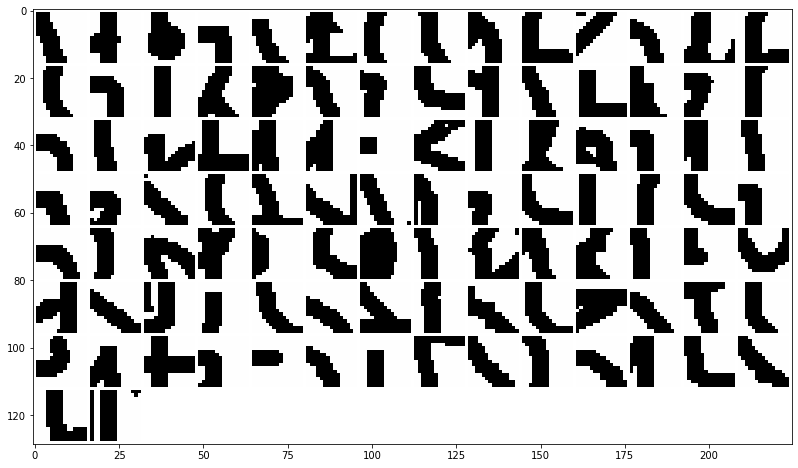

grid regions of 100 regions more=True or worst=False active for filter number: 10 :


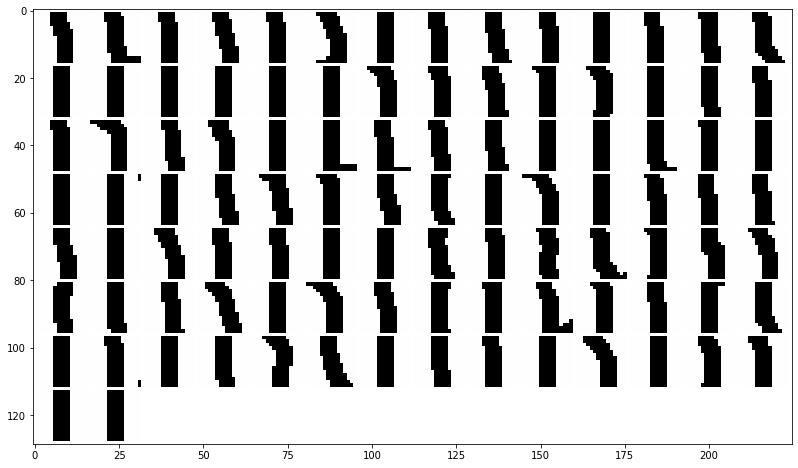

normalized regions:


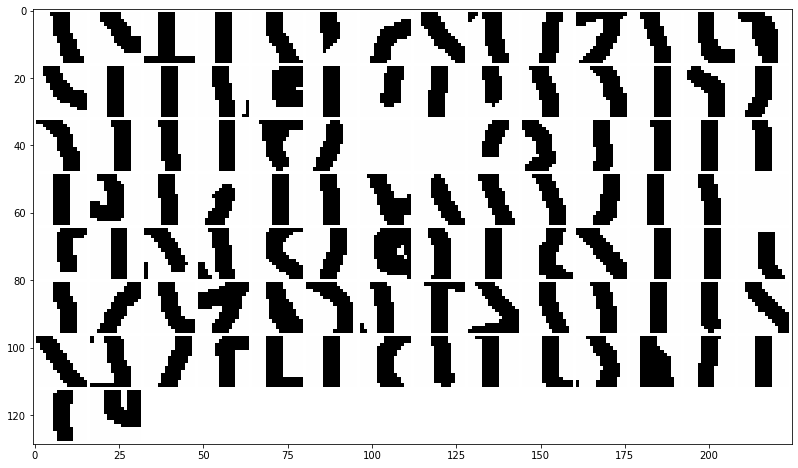

grid regions of 100 regions more=True or worst=False active for filter number: 15 :


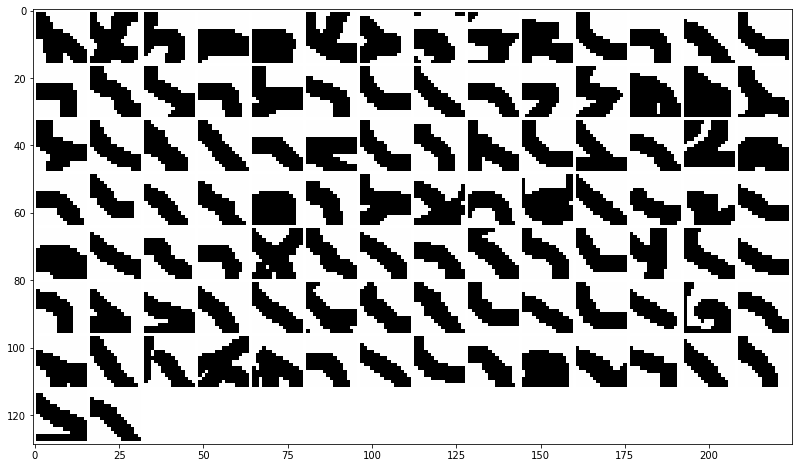

normalized regions:


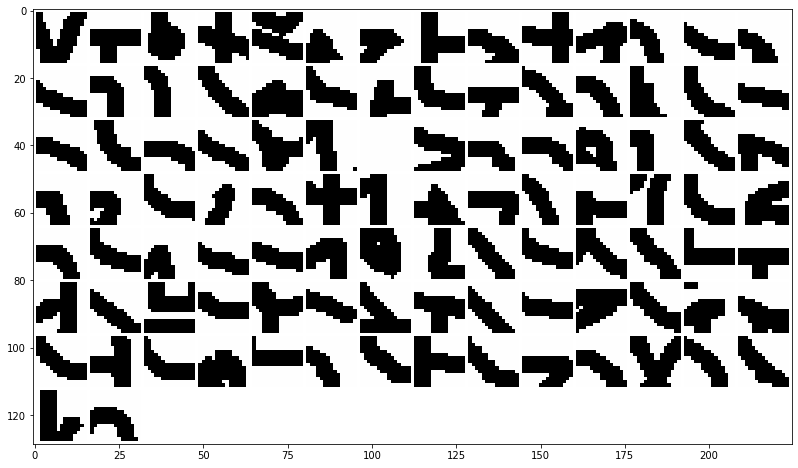

grid regions of 100 regions more=True or worst=False active for filter number: 20 :


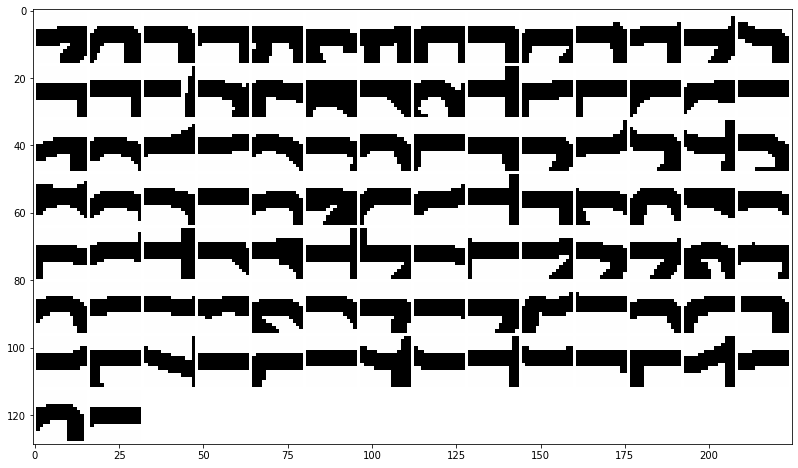

normalized regions:


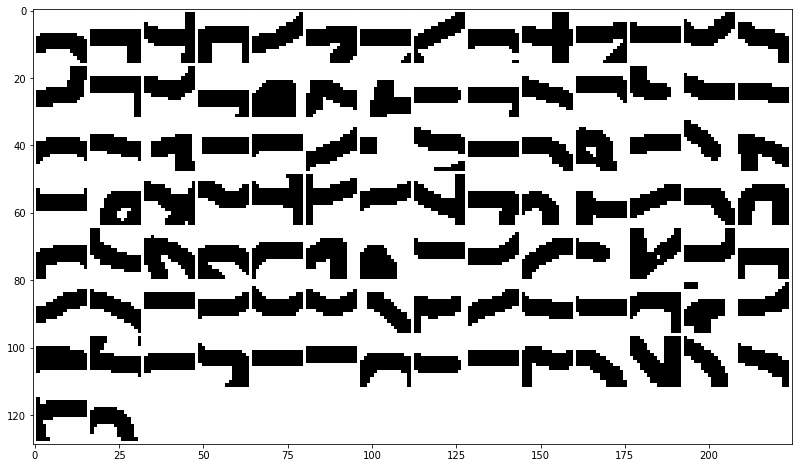

grid regions of 100 regions more=True or worst=False active for filter number: 25 :


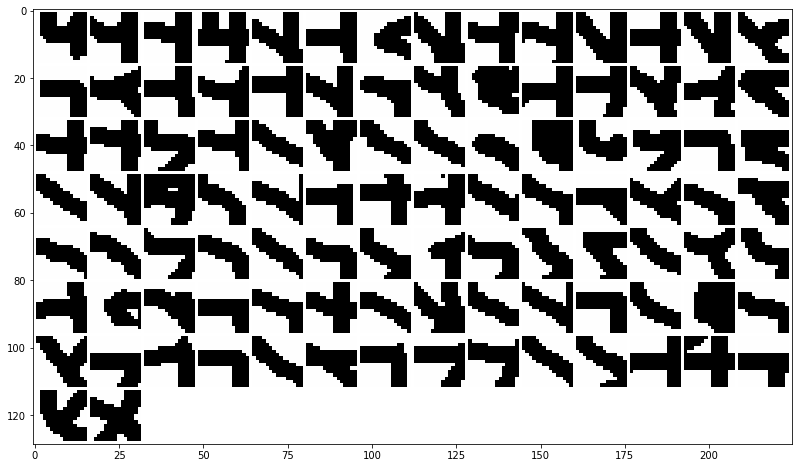

normalized regions:


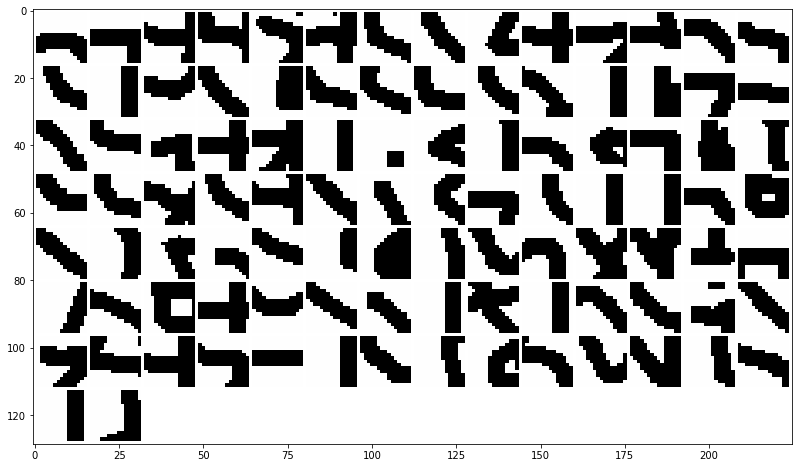

grid regions of 100 regions more=True or worst=False active for filter number: 30 :


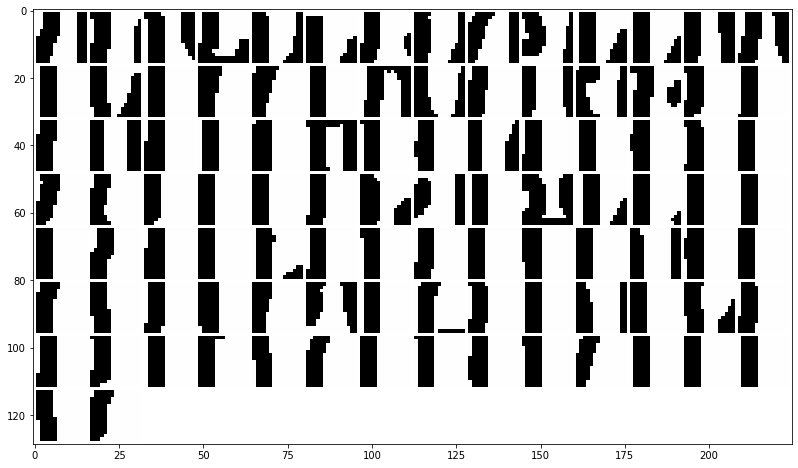

normalized regions:


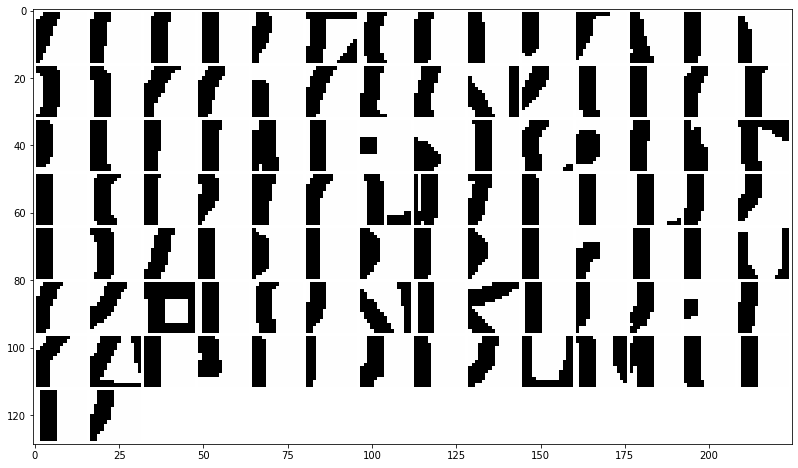

grid regions of 100 regions more=True or worst=False active for filter number: 35 :


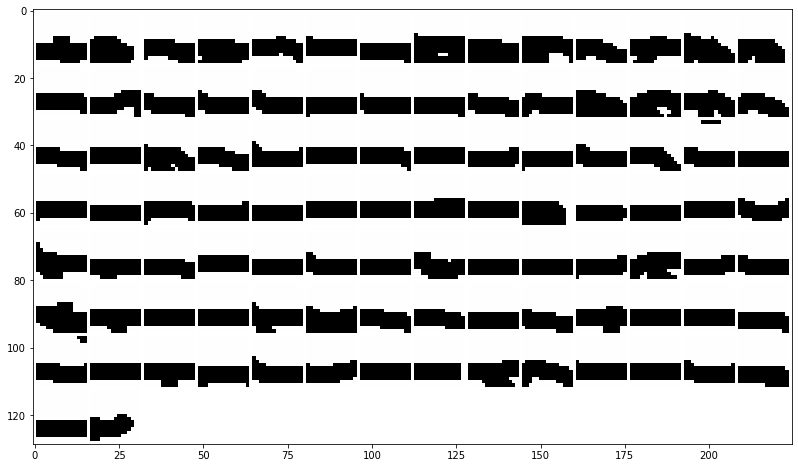

normalized regions:


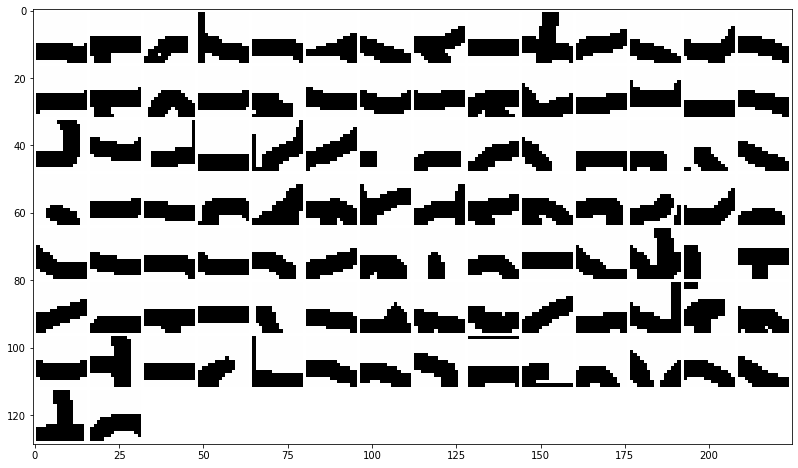

grid regions of 100 regions more=True or worst=False active for filter number: 40 :


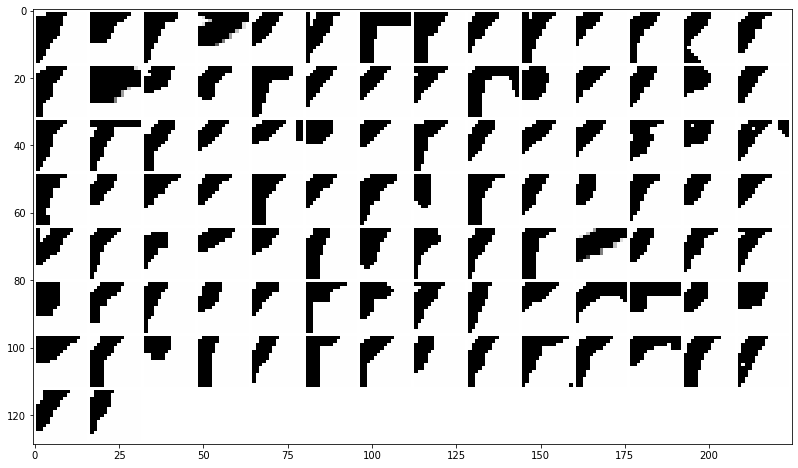

normalized regions:


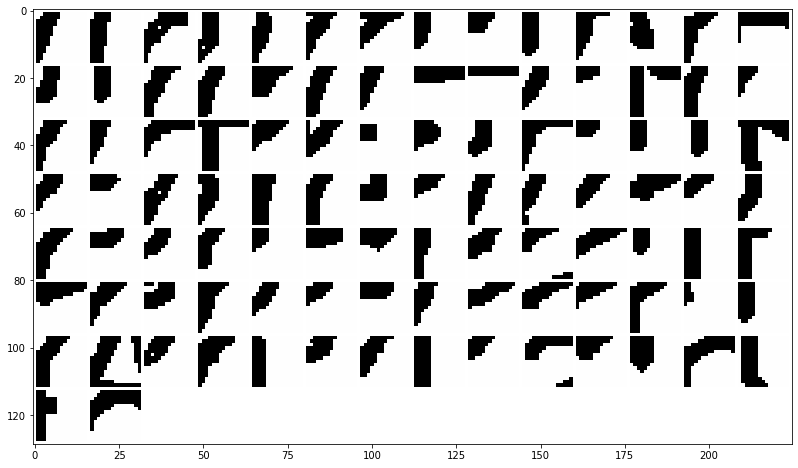

grid regions of 100 regions more=True or worst=False active for filter number: 45 :


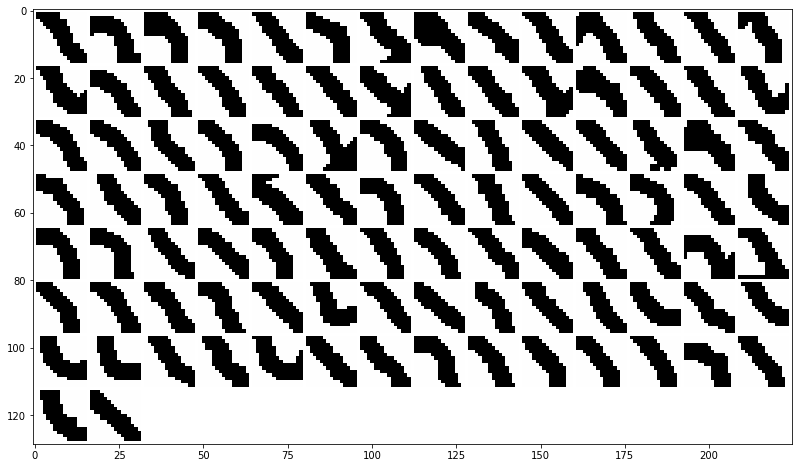

normalized regions:


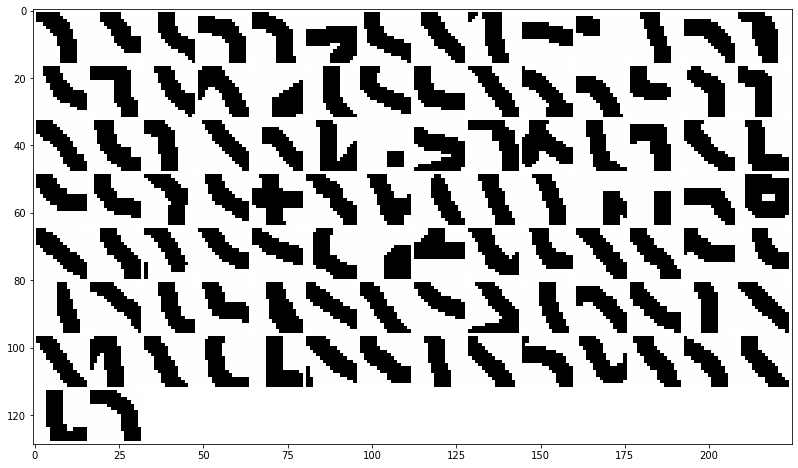

grid regions of 100 regions more=True or worst=False active for filter number: 50 :


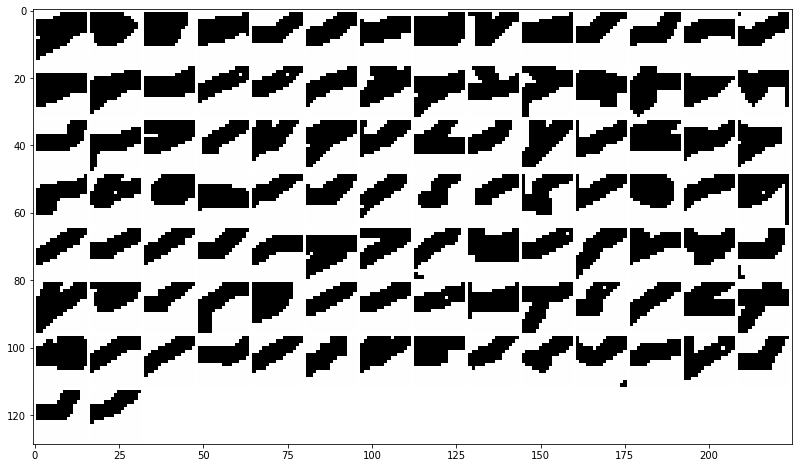

normalized regions:


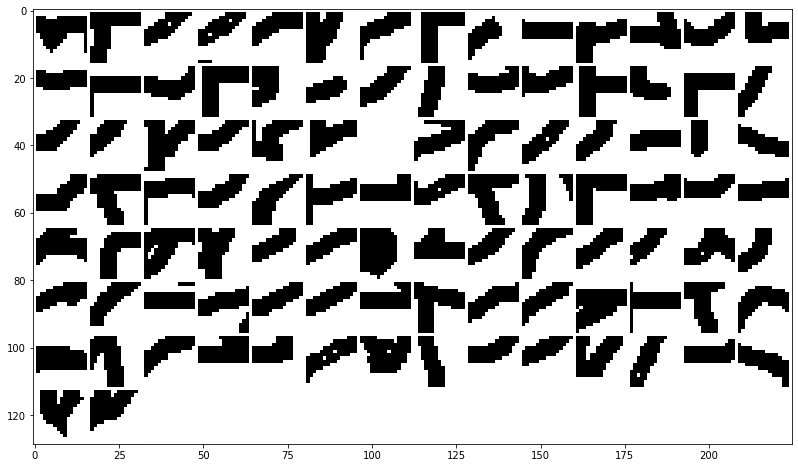

grid regions of 100 regions more=True or worst=False active for filter number: 55 :


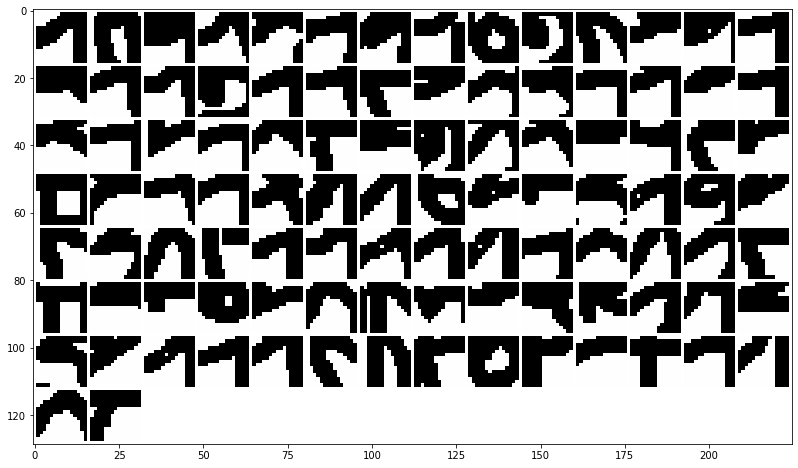

normalized regions:


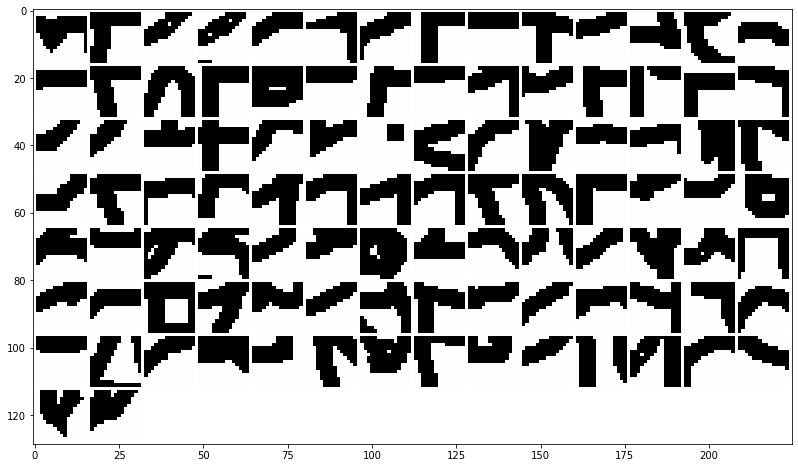

grid regions of 100 regions more=True or worst=False active for filter number: 60 :


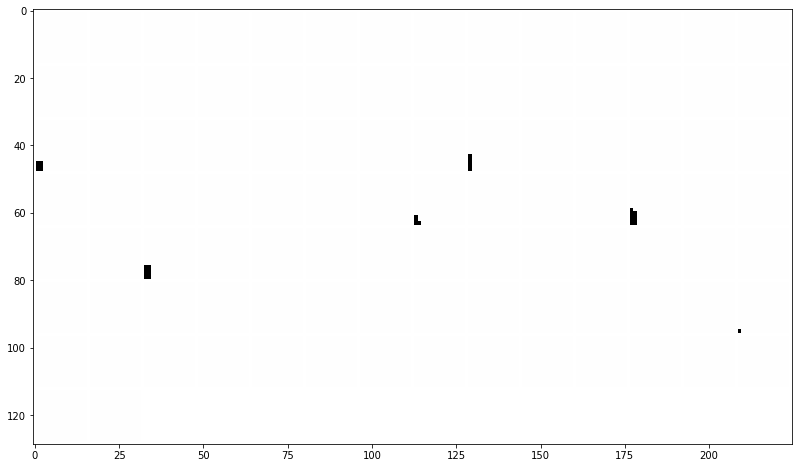

normalized regions:


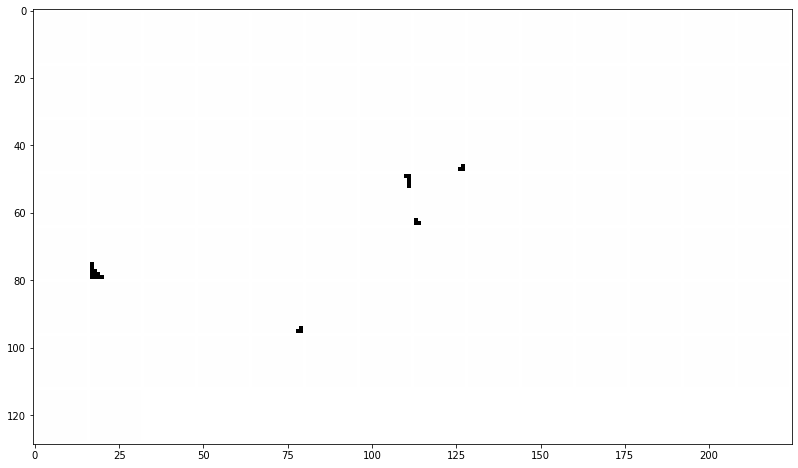

grid regions of 100 regions more=True or worst=False active for filter number: 65 :


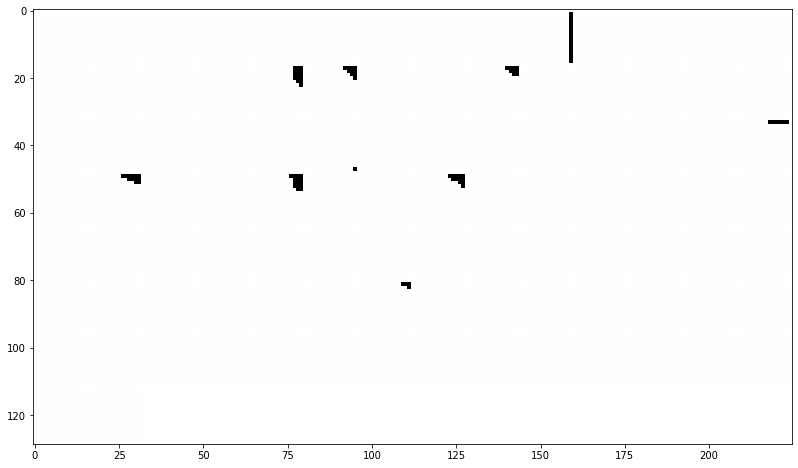

normalized regions:


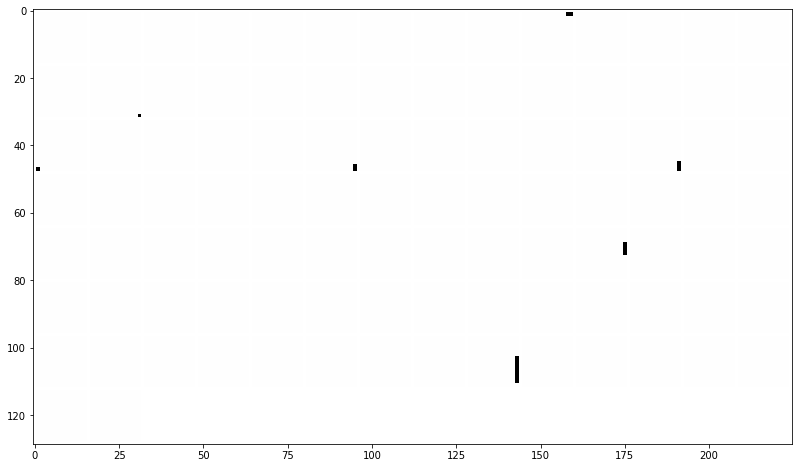

grid regions of 100 regions more=True or worst=False active for filter number: 70 :


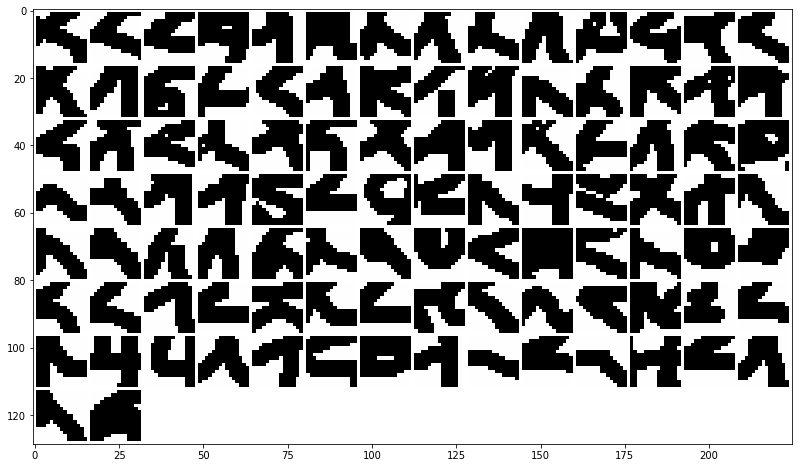

normalized regions:


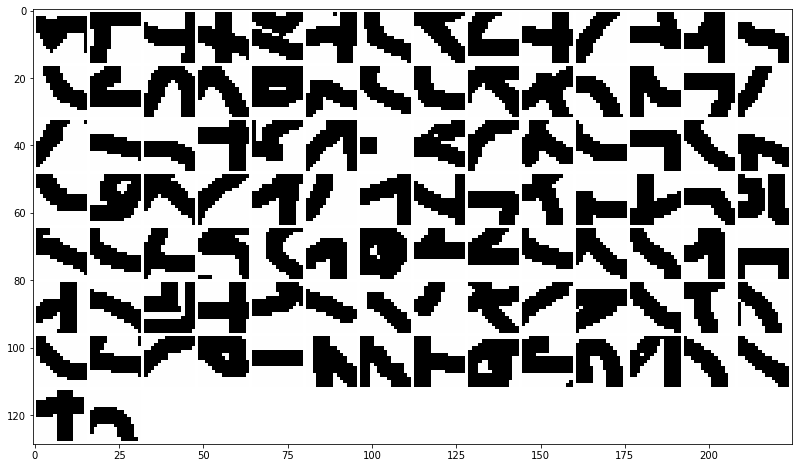

grid regions of 100 regions more=True or worst=False active for filter number: 80 :


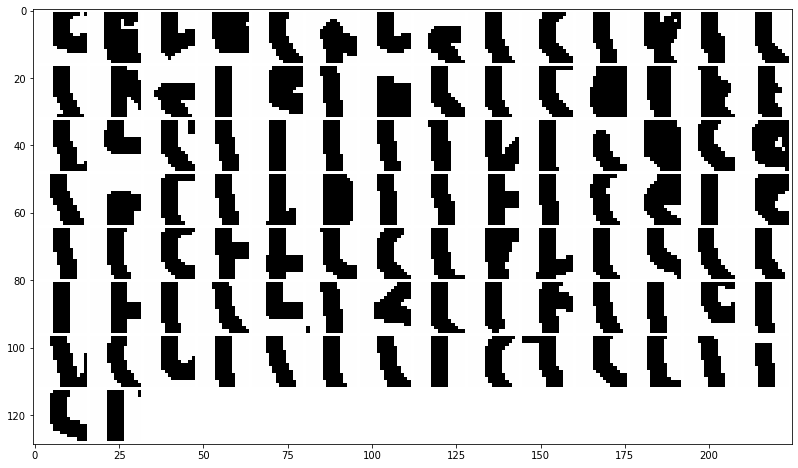

normalized regions:


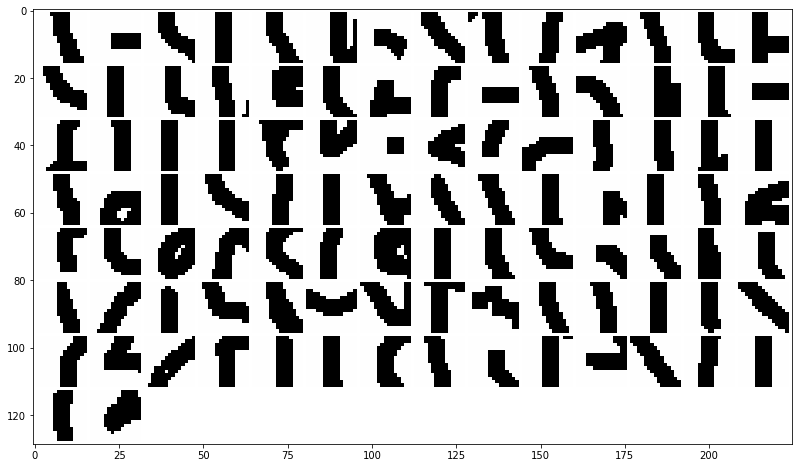

grid regions of 100 regions more=True or worst=False active for filter number: 90 :


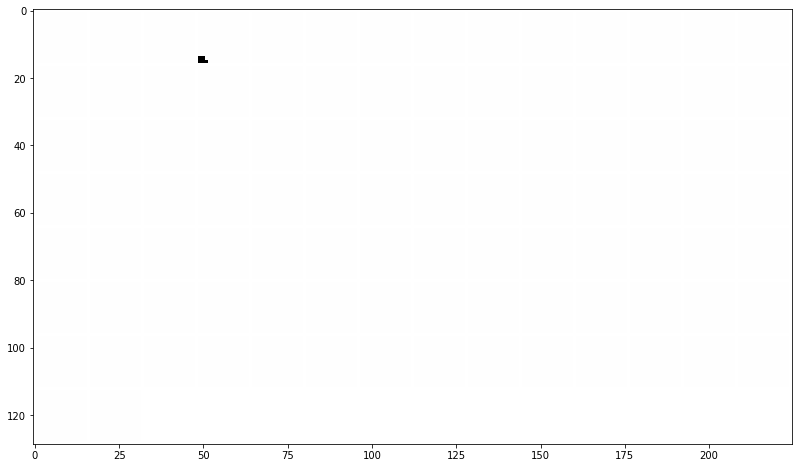

normalized regions:


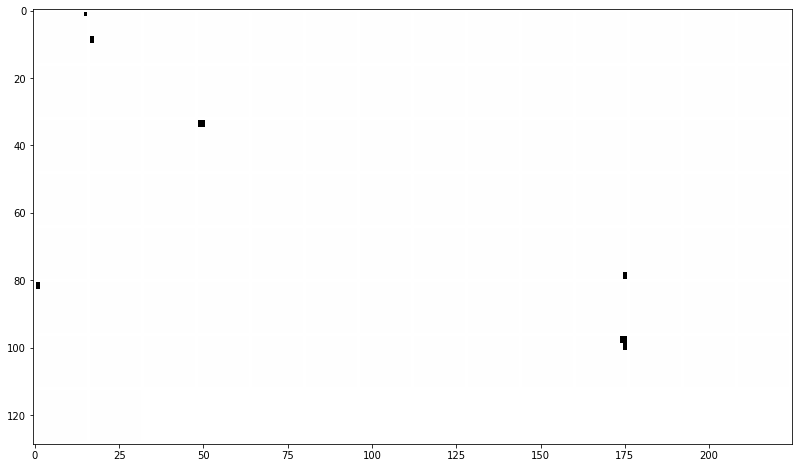

grid regions of 100 regions more=True or worst=False active for filter number: 100 :


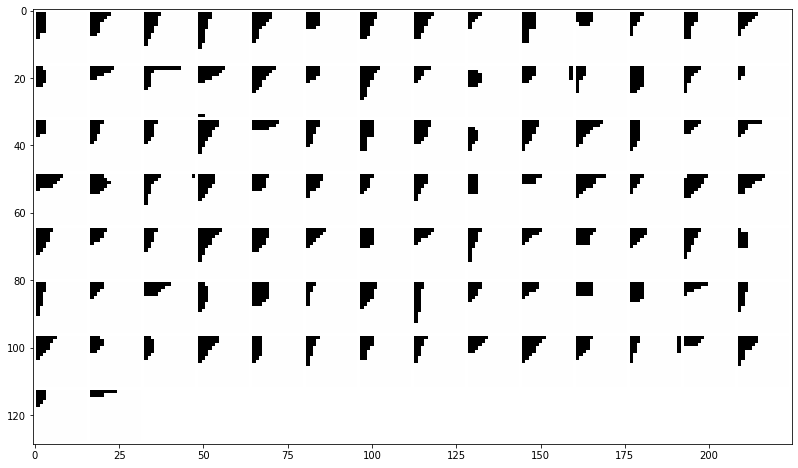

normalized regions:


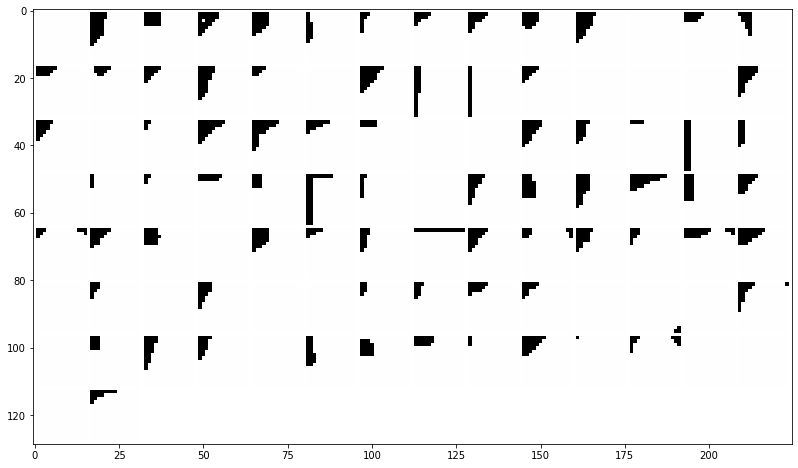

grid regions of 100 regions more=True or worst=False active for filter number: 127 :


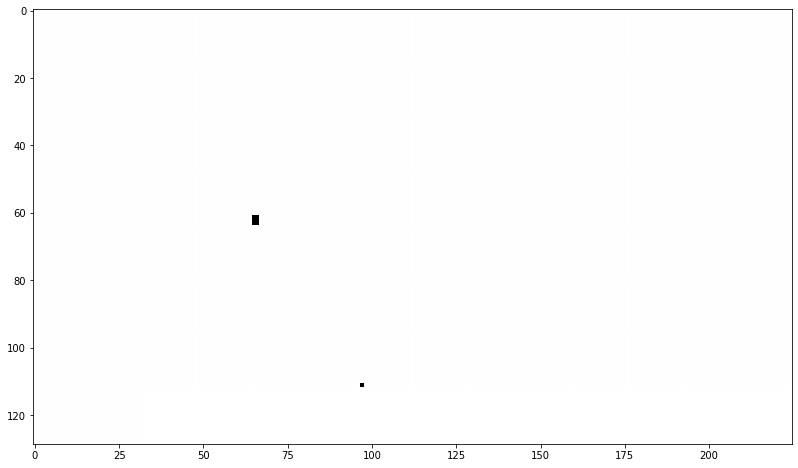

normalized regions:


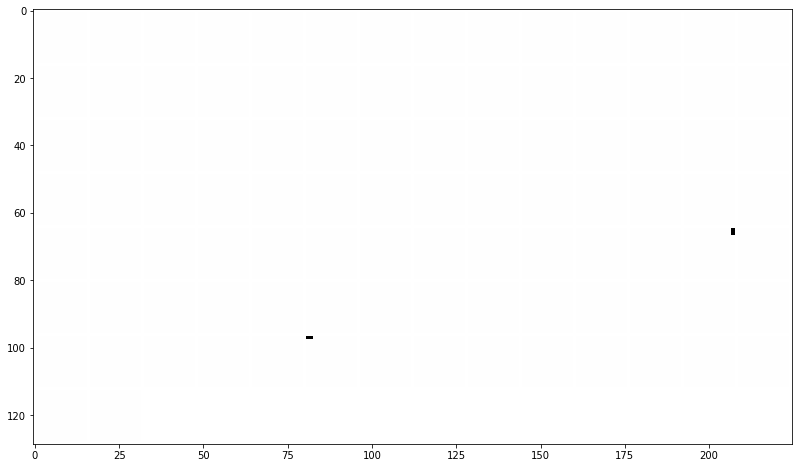

grid regions of 100 regions more=True or worst=False active for filter number: 150 :


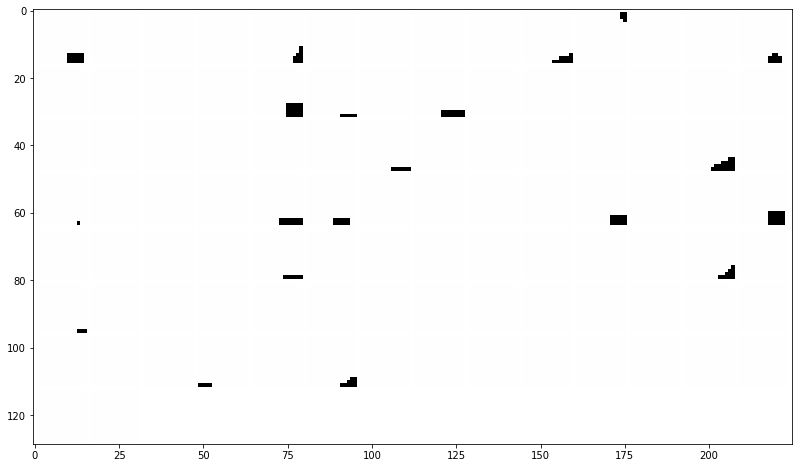

normalized regions:


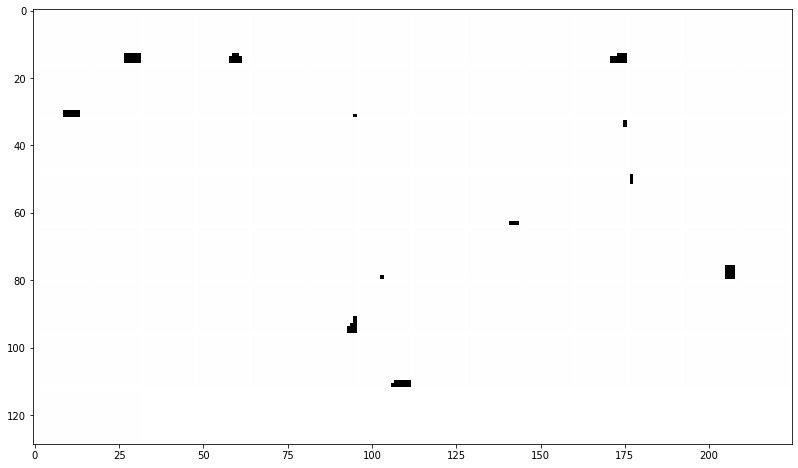

grid regions of 100 regions more=True or worst=False active for filter number: 200 :


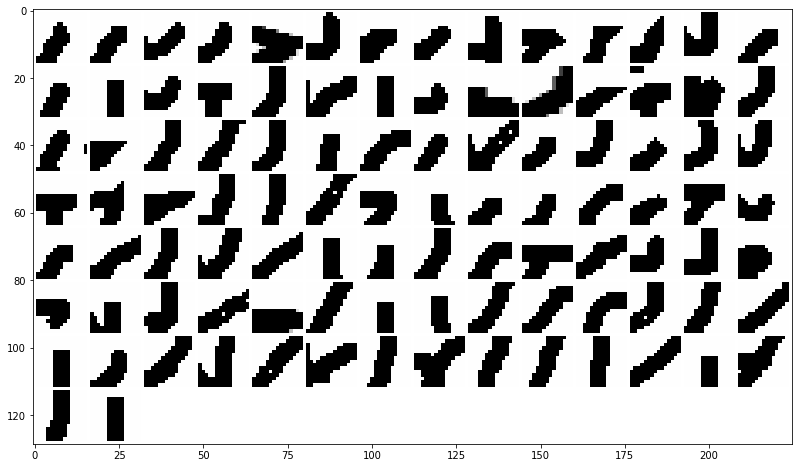

normalized regions:


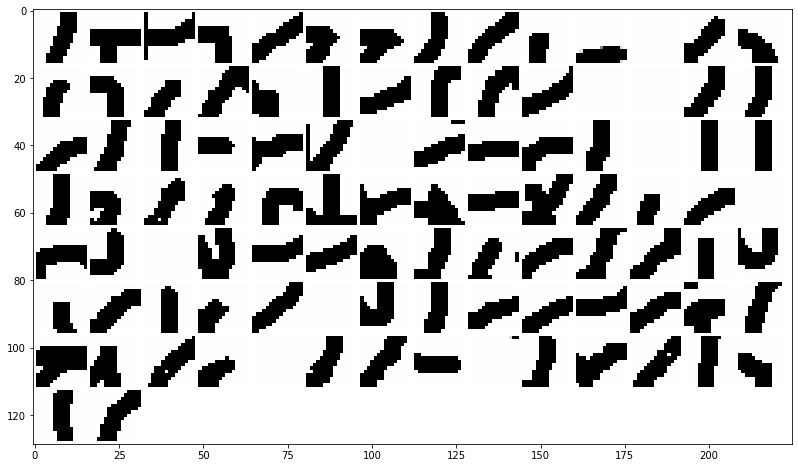

grid regions of 100 regions more=True or worst=False active for filter number: 250 :


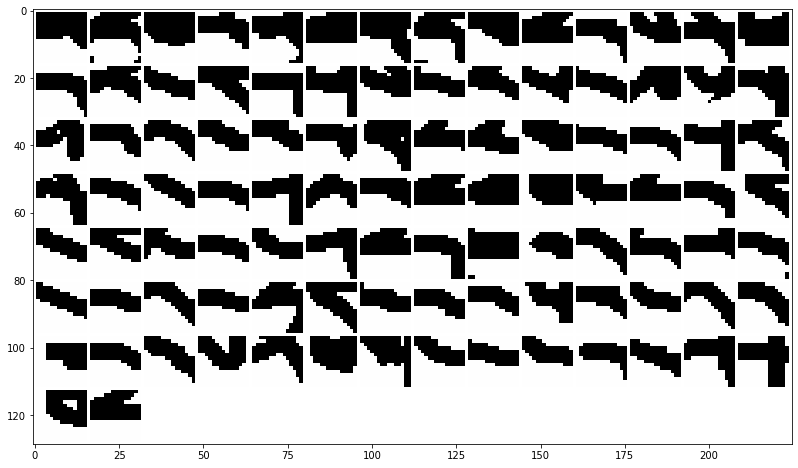

normalized regions:


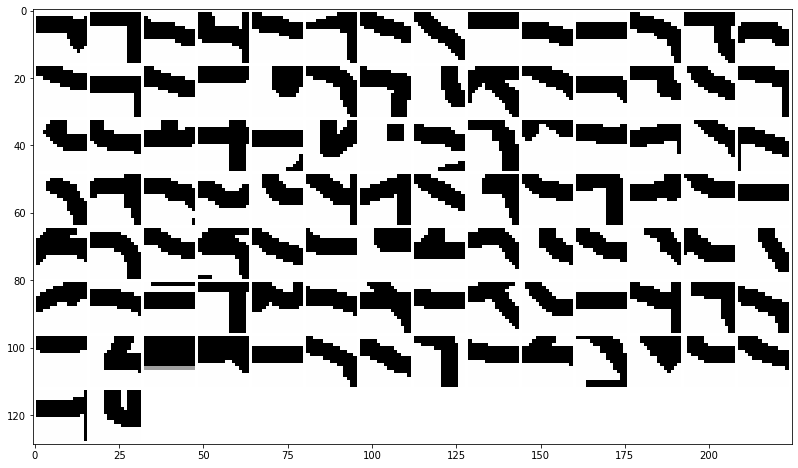

grid regions of 100 regions more=True or worst=False active for filter number: 255 :


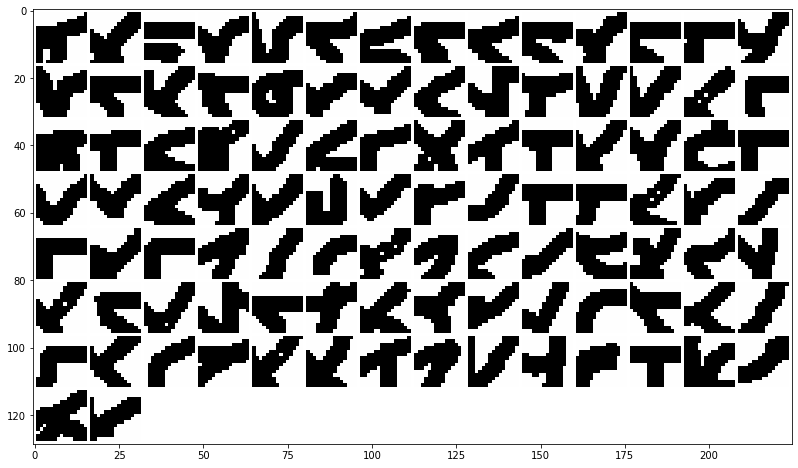

normalized regions:


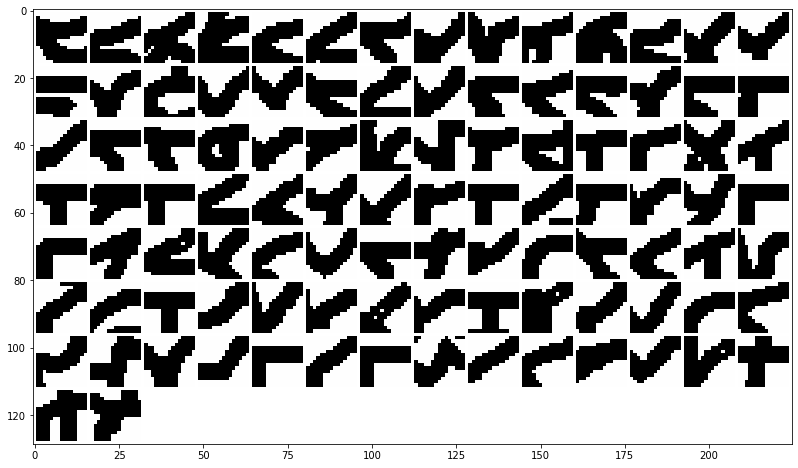

In [18]:
# parameters
list_filter_interest_layer3 = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,80,90,100,127,150,200,250,255]
best = True
worst = False
viz_mean_img = True
viz_grid = True
percentage = 10
nrow=14

# regions and activation of interest
regions = region_layer3_binary
activations = activation_layer3_binary
activations_normalized = activation_layer3_binary_normalized


selected_regions, activation_values, activation_values_normalized = get_regions_interest(regions, activations, activations_normalized, best, worst, viz_mean_img, viz_grid, percentage, list_filter_interest_layer3, nrow=nrow)

##### Binary model layer4:

In [0]:
viz_filters(model_binary)

In [19]:
# parameters
list_filter_interest_layer4 = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,80,90,100,127,150,200,250,255,300,350,400,450,500,511]
best = True
worst = False
viz_mean_img = True
viz_grid = True
percentage = 10
nrow=14

# regions and activation of interest
regions = region_layer4_binary
activations = activation_layer4_binary
activations_normalized = activation_layer4_binary_normalized


selected_regions, activation_values, activation_values_normalized = get_regions_interest(regions, activations, activations_normalized, best, worst, viz_mean_img, viz_grid, percentage, list_filter_interest_layer4, nrow=nrow)

Output hidden; open in https://colab.research.google.com to view.

## Viz all:

### No binary model:

In [0]:
viz_filters(model_no_binary)

In [0]:
g_ascent_no_binary = GradientAscent(model_no_binary, img_size=28)
g_ascent_no_binary.use_gpu = True

conv1_no_binary = model_no_binary.layer1
conv1_filters_no_binary = [0,1,2,3,4,5,6,7,8,9]
mean_gradient_layer1 = False
ind_x_layer1 = 7
ind_y_layer1 = 7


g_ascent_no_binary.visualize(conv1_no_binary, conv1_filters_no_binary, mean_gradient_layer1,
                             ind_x_layer1, ind_y_layer1, title='No binary model: conv layer 1')

In [0]:
# parameters
list_filter_interest_layer1 = [0,1,2,3,4,5,6,7,8,9]
best = True
worst = False
viz_mean_img = True
viz_grid = False
percentage = 100

# regions and activation of interest
regions = region_layer1_no_binary
activations = activation_layer1_no_binary

selected_regions = get_regions_interest(regions, activations, best, worst, viz_mean_img, viz_grid, percentage, list_filter_interest_layer1)

### Binary model:

In [0]:
viz_filters(model_binary)

In [0]:
g_ascent_binary = GradientAscent(model_binary, img_size=28)
g_ascent_binary.use_gpu = True

conv1_binary = model_binary.layer1
conv1_filters_binary = [0,1,2,3,4,5,6,7,8,9]
mean_gradient_layer1 = False
ind_x_layer1 = 7
ind_y_layer1 = 7


g_ascent_binary.visualize(conv1_binary, conv1_filters_binary, mean_gradient_layer1,
                             ind_x_layer1, ind_y_layer1, title='Binary model: conv layer 1')

In [0]:
# parameters
list_filter_interest_layer1 = [0,1,2,3,4,5,6,7,8,9]
best = True
worst = False
viz_mean_img = True
viz_grid = False
percentage = 100

# regions and activation of interest
regions = region_layer1_binary
activations = activation_layer1_binary

selected_regions = get_regions_interest(regions, activations, best, worst, viz_mean_img, viz_grid, percentage, list_filter_interest_layer1)

# Draft

## Test activation maximization with pre trained model:

In [0]:
import torchvision.models as models

In [0]:
model = models.vgg16(pretrained=True)

In [0]:
g_ascent = GradientAscent(model, img_size=224, filter_size=3)
g_ascent.use_gpu = True

conv1 = model.features[2]
conv1_filters = [17, 33, 34, 57]
mean_gradient_layer1 = False
ind_x_layer1 = 112
ind_y_layer1 = 112

conv2 = model.features[5]
conv2_filters = [27, 40, 68, 73]
mean_gradient_layer2 = False
ind_x_layer2 = 66
ind_y_layer2 = 66

conv3 = model.features[10]
conv3_filters = [31, 61, 147, 182]
mean_gradient_layer3 = False
ind_x_layer3 = 33
ind_y_layer3 = 33

conv4 = model.features[17]
conv4_filters = [238, 251, 338, 495]
mean_gradient_layer4 = False
ind_x_layer4 = 16
ind_y_layer4 = 16

conv5 = model.features[24]
conv5_filters = [45, 271, 363, 409]
mean_gradient_layer5 = False
ind_x_layer5 = 8
ind_y_layer5 = 8

lr = 1
num_iter = 30
MNIST = False

0
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


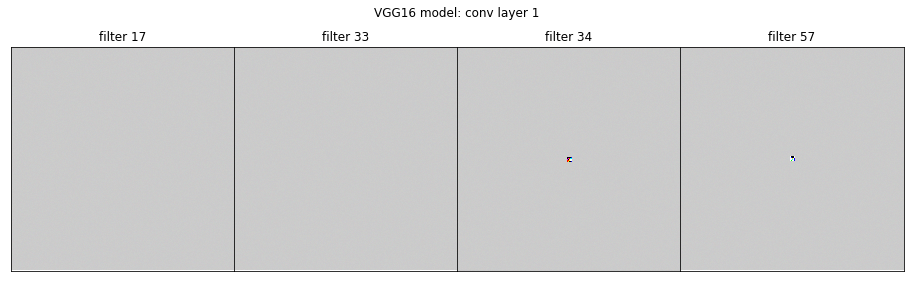

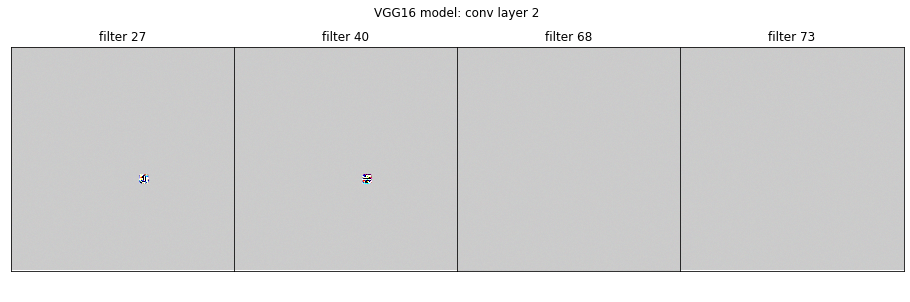

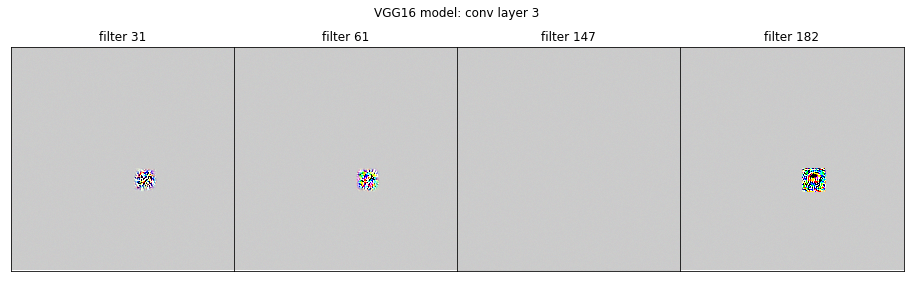

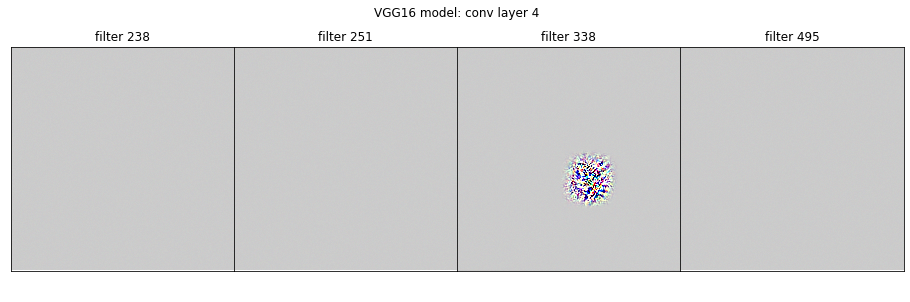

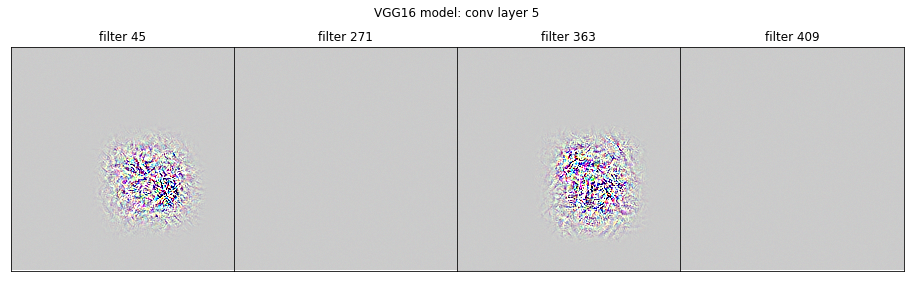

In [0]:
g_ascent.visualize(conv1, MNIST, conv1_filters, mean_gradient_layer1,
                             ind_x_layer1, ind_y_layer1, lr=lr, num_iter=num_iter, title='VGG16 model: conv layer 1', first_conv_layer=True)
g_ascent.visualize(conv2, MNIST, conv2_filters, mean_gradient_layer2,
                             ind_x_layer2, ind_y_layer2, lr=lr, num_iter=num_iter, title='VGG16 model: conv layer 2')
g_ascent.visualize(conv3, MNIST, conv3_filters, mean_gradient_layer3,
                             ind_x_layer3, ind_y_layer3, lr=lr, num_iter=num_iter, title='VGG16 model: conv layer 3')
g_ascent.visualize(conv4, MNIST, conv4_filters, mean_gradient_layer4,
                             ind_x_layer4, ind_y_layer4, lr=lr, num_iter=num_iter, title='VGG16 model: conv layer 4')
g_ascent.visualize(conv5, MNIST, conv5_filters, mean_gradient_layer5,
                             ind_x_layer5, ind_y_layer5, lr=lr, num_iter=num_iter, title='VGG16 model: conv layer 5')

In [0]:
g_ascent = GradientAscent(model, img_size=224, filter_size=3)
g_ascent.use_gpu = True

In [0]:
conv1 = model.features[2]
conv1_filters = [17, 33, 34, 57]
mean_gradient_layer1 = True
ind_x_layer1 = 112
ind_y_layer1 = 112

conv2 = model.features[5]
conv2_filters = [27, 40, 68, 73]
mean_gradient_layer2 = True
ind_x_layer2 = 66
ind_y_layer2 = 66

conv3 = model.features[10]
conv3_filters = [31, 61, 147, 182]
mean_gradient_layer3 = True
ind_x_layer3 = 33
ind_y_layer3 = 33

conv4 = model.features[17]
conv4_filters = [238, 251, 338, 495]
mean_gradient_layer4 = True
ind_x_layer4 = 16
ind_y_layer4 = 16

conv5 = model.features[24]
conv5_filters = [45, 271, 363, 409]
mean_gradient_layer5 = True
ind_x_layer5 = 8
ind_y_layer5 = 8

lr = 1
num_iter = 30
MNIST = False

In [0]:
g_ascent.visualize(conv1, MNIST, conv1_filters, mean_gradient_layer1,
                             ind_x_layer1, ind_y_layer1, lr=lr, num_iter=num_iter, title='VGG16 model: conv layer 1', first_conv_layer=True)
g_ascent.visualize(conv2, MNIST, conv2_filters, mean_gradient_layer2,
                             ind_x_layer2, ind_y_layer2, lr=lr, num_iter=num_iter, title='VGG16 model: conv layer 2')
g_ascent.visualize(conv3, MNIST, conv3_filters, mean_gradient_layer3,
                             ind_x_layer3, ind_y_layer3, lr=lr, num_iter=num_iter, title='VGG16 model: conv layer 3')
g_ascent.visualize(conv4, MNIST, conv4_filters, mean_gradient_layer4,
                             ind_x_layer4, ind_y_layer4, lr=lr, num_iter=num_iter, title='VGG16 model: conv layer 4')
g_ascent.visualize(conv5, MNIST, conv5_filters, mean_gradient_layer5,
                             ind_x_layer5, ind_y_layer5, lr=lr, num_iter=num_iter, title='VGG16 model: conv layer 5')

Output hidden; open in https://colab.research.google.com to view.

## Test activation maximization with pre trained model:

In [0]:
!pip install flashtorch

In [0]:
import torchvision.models as models
from flashtorch.activmax import GradientAscent as GA

In [0]:
model = models.vgg16(pretrained=True)

In [0]:
conv1_2 = model.features[2]
conv1_2_filters = [17, 33, 34, 57]

conv2_1 = model.features[5]
conv2_1_filters = [27, 40, 68, 73]

conv3_1 = model.features[10]
conv3_1_filters = [31, 61, 147, 182]

conv4_1 = model.features[17]
conv4_1_filters = [238, 251, 338, 495]

conv5_1 = model.features[24]
conv5_1_filters = [45, 271, 363, 409]

In [0]:
g_ascent = GA(model.features)

In [0]:
g_ascent.visualize(conv1_2, conv1_2_filters, title='conv1_2');
g_ascent.visualize(conv2_1, conv2_1_filters, title='conv2_1');
g_ascent.visualize(conv3_1, conv3_1_filters, title='conv3_1');
g_ascent.visualize(conv4_1, conv4_1_filters, title='conv4_1');
g_ascent.visualize(conv5_1, conv5_1_filters, title='conv5_1');

Output hidden; open in https://colab.research.google.com to view.

## TEst activation region max:

In [0]:
from utils.functions import Hardsigmoid
from visualize.viz import get_region_layer1
import matplotlib

In [0]:
def test_act_region_max(index_data, images):

  image = images[index_data].unsqueeze(0)
  label = labels[index_data].item()

  output = model_no_binary(image)

  keys  ='act_layer1'

  act_conv = activation[keys]
  print('{} for label {}'.format(keys, label))
  print(act_conv.shape)

  i=0
  act_max_abs = max(act_conv[0][i].min(), act_conv[0][i].max(), key=abs)
  act_max = act_conv[0][i].max()
  print(act_max_abs, act_max)
  ind_x = int((np.where(act_conv[0][i] == act_max)[0])[0])  # get index (x,y) of act_max
  ind_y = int((np.where(act_conv[0][i] == act_max)[1])[0])
  print(ind_x, ind_y)

  im = image.squeeze()
  name='no binary'
  stride=2
  padding=1
  filter_size=3
  len_img_h = 105
  len_img_w = 105
  region, begin_col, end_col, begin_raw, end_raw = get_region_layer1(im, ind_x, ind_y, name, stride, padding, filter_size, len_img_h, len_img_w, return_all=True)

  act_conv_im = activation[keys].squeeze()
  plt.imshow(act_conv_im[index_data], cmap='gray')
  plt.scatter(ind_y,ind_x,color='r')
  plt.show()

  fig,ax = plt.subplots(1)
  ax.imshow(im, cmap='gray')
  ax.scatter(((ind_y*stride)-padding)+1, ((ind_x*stride)-padding)+1,color='r')
  rect=matplotlib.patches.Rectangle((begin_raw-1, begin_col-1),3,3, edgecolor='r', facecolor="none")
  ax.add_patch(rect)
  plt.show()

  s_y = ((ind_y*stride)-padding)
  e_y = ((ind_y*stride)-padding)+3
  s_x = ((ind_x*stride)-padding)
  e_x=((ind_x*stride)-padding)+3

  print(im[s_y:e_y,s_x:e_x])
  print(region)
  plt.imshow(region, cmap='gray')
  plt.show()

  return region, begin_col, end_col, begin_raw, end_raw


In [0]:
activation = {}

for name, m in model_no_binary.named_modules():
        if type(m) == Hardsigmoid or type(m) == nn.ReLU:
            m.register_forward_hook(get_activation(name, activation))

index_data=10
if index_data == None:
    index_data = random.randint(0, len(train_loader))

dataiter = iter(train_loader)
images, labels = dataiter.next()

# model_no_binary.cpu()
# output = model_no_binary(image)

act_layer1 for label 253
torch.Size([1, 64, 53, 53])
tensor(5.3527) tensor(5.3527)
3 16


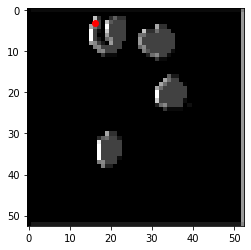

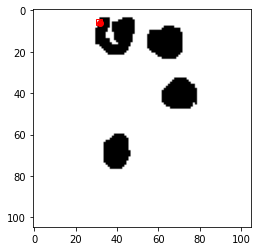

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])


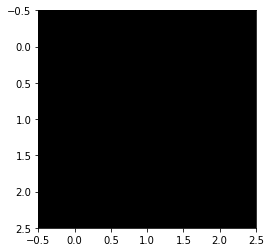

torch.Size([3, 3])
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
5 8 31 34


In [0]:
index_data=0

region, begin_col, end_col, begin_raw, end_raw = test_act_region_max(index_data, images)

print(region.shape)
print(region)
print(begin_col,end_col,begin_raw,end_raw)

## test region's score:

In [0]:
from numpy import linalg as LA

In [0]:
def get_activation(name, activation):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def test_score_region(model, filter_choice, index=None):

  if index is None:
    # dataiter = iter(train_loader)
    # images, _ = dataiter.next()
    index = np.random.randint(0,1000)
    image = images[index]
  else:
    image = images[index]

  print('image test number: {} with shape: {}'.format(index, image.shape))
  plt.imshow(image[0], cmap='gray')
  plt.show()

  activation = {}

  for name, m in model.named_modules():
      if type(m) == nn.Conv2d:
          m.register_forward_hook(get_activation(name, activation))

  out = model(image.unsqueeze(0)) 

  activation_layer1 = activation['layer1'][0]
  activation_layer2 = activation['layer2'][0]

  print('prediction:{}'.format(out.data.numpy().argmax()))       

  filter = filter_choice
  act_max_layer1 = activation_layer1[filter].max()
  print('value activation max for filte {} :{}'.format(filter, act_max_layer1))

  ind_x = int((np.where(activation_layer1[filter] == act_max_layer1)[0])[0]) 
  ind_y = int((np.where(activation_layer1[filter] == act_max_layer1)[1])[0])

  print('index of max value: x: {}, y: {}'.format(ind_x, ind_y))

  name = 'layer1'
  stride = 2
  padding=1
  filter_size=3
  len_img_h=105
  len_img_w=105
  im = image[0]
  print(im.shape)

  region, begin_col, end_col, begin_raw, end_raw = get_region_layer1(im, ind_x, ind_y, name, stride, padding, filter_size, len_img_h, len_img_w, return_all=True)

  print('region extracted: {}'.format(region))
  plt.imshow(region, cmap='gray')
  plt.show()

  random_im = np.uint8(np.random.uniform(0, 255, (105, 105)))/255
  print('random image generated:')
  plt.imshow(random_im, cmap='gray')
  plt.show()

  random_im[begin_col:end_col, begin_raw:end_raw] = region
  plt.imshow(random_im, cmap='gray')
  print('random image generated with region that maximize filter activation:')
  plt.show()

  activation_random_im = {}

  for name, m in model_no_binary.named_modules():
      if type(m) == nn.Conv2d:
          m.register_forward_hook(get_activation(name, activation_random_im))

  random_image = (torch.tensor(random_im.reshape((1,1,105,105))))
  out = model_no_binary(random_image.float())
  activation_layer1_random = activation_random_im['layer1'][0]

  act_max_random = activation_layer1_random[filter].max()

  ind_x_random = int((np.where(activation_layer1_random[filter] == act_max_random)[0])[0]) 
  ind_y_random = int((np.where(activation_layer1_random[filter] == act_max_random)[1])[0])

  activation_value_index_random = activation_layer1_random[filter][ind_x][ind_y]
  activation_value_index = activation_layer1[filter][ind_x][ind_y]

  print('activation max for image: {} with index: x:{}, y:{}'.format(act_max_layer1, ind_x, ind_y))
  print('activation max for random image with region: {} with index: x:{}, y:{}'.format(act_max_random, ind_x_random, ind_y_random))  

  print('activation value for ind_x: {} and ind_y: {} = {}'.format(ind_x, ind_y, activation_value_index))
  print('random activation value for ind_x: {} and ind_y: {} = {}'.format(ind_x_random, ind_y_random, activation_value_index_random))
  
  region_new_random, begin_col, end_col, begin_raw, end_raw = get_region_layer1(random_im, ind_x_random, ind_y_random, name, stride, padding, filter_size, len_img_h, len_img_w, return_all=True)

  plt.imshow(region_new_random, cmap='gray')
  print('region_new_random')
  plt.show()

  return region

image test number: 1 with shape: torch.Size([1, 105, 105])


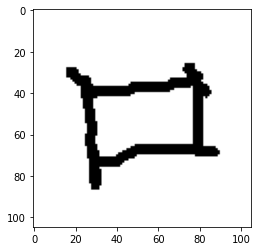

prediction:627
value activation max for filte 0 :0.7777348756790161
index of max value: x: 15, y: 8
torch.Size([105, 105])
index start: 15, 8
index hl: 29, 15
index extract region: 29, 32, 15, 18


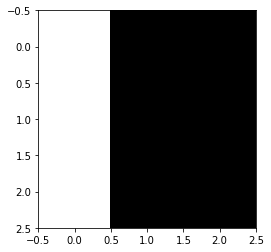

region extracted: tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]])


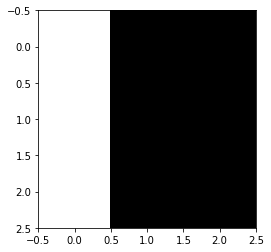

random image generated:


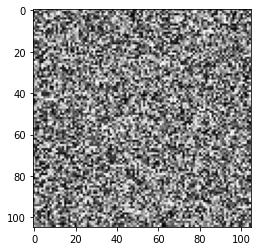

random image generated with region that maximize filter activation:


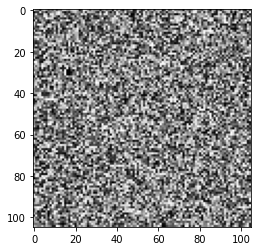

activation max for image: 0.7777348756790161 with index: x:15, y:8
activation max for random image with region: 0.7777348756790161 with index: x:15, y:8
activation value for ind_x: 15 and ind_y: 8 = 0.7777348756790161
random activation value for ind_x: 15 and ind_y: 8 = 0.7777348756790161
index start: 15, 8
index hl: 29, 15
index extract region: 29, 32, 15, 18


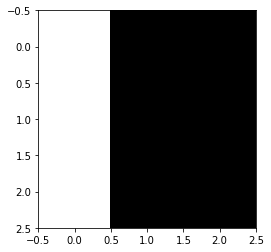

region_new_random


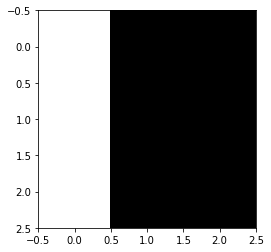

In [29]:
model = model_no_binary
filter_choice = 0
index=1


region = test_score_region(model, filter_choice, index=index)